<a href="https://colab.research.google.com/github/hcharlton/nndl/blob/master/notebooks/diffLogic_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentiable Logic Cellular Automata: from Game of Life to Pattern Generation

This notebook contains code to reproduce experiments and figures for the
"Differentiable Logic Cellular Automata: from Game of Life to Pattern
Generation" article.

Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

https://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or
agreed to in writing, software distributed under the License is distributed on
an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express
or implied. See the License for the specific language governing permissions and
limitations under the License.

**Note for the reader (as of March 20, 2025):**: We tested reproducibility of the results reported in
this article using publicly available Colab notebooks with T4 GPUs. Determinism
is ensured by setting the os.environ['XLA_FLAGS'] = '
--xla_gpu_deterministic_ops=true' flag, which resolves non-determinism caused by
specific JAX optimization routines, though at the cost of speed and efficiency.

In [1]:
# We tested reproducibility on jax version 0.4.33

!pip install jax[cuda12_pip]==0.4.33
!pip install jaxlib==0.4.33

# You might need to restart the kernel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Successfully uninstalled jax-cuda12-pjrt-0.5.1
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.5.1
    Uninstalling jax-cuda12-plugin-0.5.1:
      Successfully uninstalled jax-cuda12-plugin-0.5.1
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: jax
    Found existing installation: jax 0.5.2
    Uninstalling jax-0.5.2:
      Successfully uninstalled jax-0.5.2
ERROR: pip's 

In [2]:
"""Reproducibility:

This flag is necessary for ensuring reproducibility on Colab.
Removing it significantly boosts performance (5-10x) but compromises
result consistency due to inherent GPU non-determinism.
"""

import os

os.environ['XLA_FLAGS'] = ' --xla_gpu_deterministic_ops=true'

In [3]:
# @title Imports and Notebook Utilities
from collections import namedtuple
from datetime import datetime
from functools import partial
import io
import itertools
from base64 import b64decode
from typing import List, Optional, Sequence, Tuple

from einops import rearrange
import flax.linen as nn
import flax.linen as nn
from IPython.display import HTML, Image, clear_output
import jax
print(jax.__version__)
from jax import grad
from jax.lax import conv_general_dilated_patches
import jax.numpy as jnp
import jax.random as random
from jax.tree_util import tree_leaves, tree_map
from matplotlib import colors
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
import numpy as np
import optax
import PIL
import PIL.Image, PIL.ImageDraw, PIL.ImageFont, PIL.ImageOps
import requests


os.environ['FFMPEG_BINARY'] = 'ffmpeg'

0.4.33


In [4]:
# @title Hyperparameters

# Index of the pass-through gate used for network initialization.
PASS_THROUGH_GATE = 3
DEFAULT_PASS_VALUE = 10.0

# Number of possible gates with 2 inputs and 1 output.
NUMBER_OF_GATES = 16

"""
Fire rate for asynchronicity.

60% of cells will perform the update,
40% will have the update masked.
"""
FIRE_RATE = 0.6

TARGET_EMOJI = "🦎"
TARGET_SIZE_EMOJI = 20
TARGET_SIZE_G = 16
TARGET_SIZE_ASYNC = 14
TARGET_SIZE = 16

In [5]:
# @title Utils and Plotting


def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img


def load_byte(byte, max_size=TARGET_SIZE):
  img = PIL.Image.open(io.BytesIO(byte))
  img.thumbnail((max_size, max_size), PIL.Image.LANCZOS)
  img = np.float32(img) / 255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def visualize(frames, namefile, size, negate=1):
  # Create and save animation
  fig, ax = plt.subplots(figsize=(size, size))
  ax.set_xticks([])
  ax.set_yticks([])

  def animate(frame):
    ax.clear()
    ax.set_xticks([])
    ax.set_yticks([])

    if negate:
      frame = 1 - frame

    return [ax.imshow(frame, cmap='binary')]

  anim = animation.FuncAnimation(fig, animate, frames=frames, interval=200, blit=True)

  # Save the gif
  writer = animation.PillowWriter(fps=2)
  anim.save(namefile, writer=writer)
  plt.close()


def plot_show(img, negate=1):
  if negate:
    img = 1 - img
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(img, cmap='binary')
  ax.axis('off')
  plt.tight_layout()
  plt.show()


# Plot the histogram related to the statistics of the gates.
def plot_hist_gates(
    net, save_path=None, title='Distribution of Gates (Sorted)'
):
  gate_types = [
      'FALSE',
      'AND',
      'A AND (NOT B)',
      'A',
      '(NOT A) AND B',
      'B',
      'XOR',
      'OR',
      'NOR',
      'XNOR',
      'NOT B',
      'A OR (NOT B)',
      'NOT A',
      '(NOT A) OR B',
      'NAND',
      'TRUE',
  ]

  gate_counts = np.bincount(net, minlength=len(gate_types))
  sorted_indices = np.argsort(gate_counts)
  sorted_counts = gate_counts[sorted_indices]
  sorted_gate_types = [gate_types[i] for i in sorted_indices]
  fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

  ax.barh(
      sorted_gate_types,
      sorted_counts,
      color='#2E86C1',
      alpha=0.7,
      edgecolor='white',
      linewidth=1,
  )

  ax.set_xlabel('#Gates', fontsize=12, fontweight='bold')
  ax.set_ylabel('Type of gate', fontsize=12, fontweight='bold')
  ax.set_title(
      'Distribution of Gates (Sorted)', fontsize=14, fontweight='bold', pad=20
  )

  plt.style.use('seaborn-v0_8-darkgrid')
  ax.grid(True, linestyle='--', alpha=0.7, axis='x')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.set_facecolor('#f8f9fa')
  fig.set_facecolor('white')
  plt.tight_layout()

  if save_path:
    with open(save_path, 'wb') as f:
      plt.savefig(f, format='svg')
  plt.show()


# Plot the training loss functions.
def plot_training_progress(
    loss_train, loss_test, compute_every, save_path=None
):
  plt.style.use('seaborn-v0_8-darkgrid')

  fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

  ax.grid(True, color='gray', linestyle='-', linewidth=0.8, alpha=0.3)

  ax.plot(
      loss_train,
      color='#2E86C1',
      linewidth=2,
      label='Soft Gates Loss',
      alpha=0.9,
  )

  ax.plot(
      np.arange(0, len(loss_train), compute_every),
      loss_test,
      color='#E74C3C',
      linestyle='--',
      linewidth=2,
      label='Hard Gates Loss',
      alpha=0.9,
  )

  ax.grid(True, linestyle='--', alpha=0.7)

  ax.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
  ax.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
  ax.set_title(
      'Training Progress - Soft vs Hard Gates',
      fontsize=14,
      fontweight='bold',
      pad=20,
  )

  ax.legend(
      frameon=True, fancybox=True, shadow=True, fontsize=10, loc='upper right'
  )

  for spine in ax.spines.values():
    spine.set_linewidth(1.5)

  ax.set_facecolor('#f8f9fa')
  fig.set_facecolor('white')

  plt.tight_layout()

  if save_path:
    with open(save_path, 'wb') as f:
      plt.savefig(f, format='svg')

  plt.show()

In [6]:
# @title Model definition


def get_moore_connections(key):
  """Generate Moore neighborhood connections for a 9x1 vector.

  Center element is at index 4 and connects to all other elements.
  """
  neighbors = jnp.array([0, 1, 2, 3, 5, 6, 7, 8])
  a = neighbors
  b = jnp.full_like(neighbors, 4)
  perm = jax.random.permutation(key, neighbors.shape[0])
  a = a[perm]
  b = b[perm]
  return a, b


# From https://github.com/Felix-Petersen/difflogic/tree/main/difflogic
def get_unique_connections(in_dim, out_dim, key):
  assert (
      out_dim * 2 >= in_dim
  )  # Number of neurons must not be smaller than half of inputs
  x = jnp.arange(in_dim)
  # Take pairs (0, 1), (2, 3), (4, 5), ...
  a = x[::2]
  b = x[1::2]
  m = min(a.shape[0], b.shape[0])
  a = a[:m]
  b = b[:m]
  # If needed, add pairs (1, 2), (3, 4), (5, 6), ...
  if a.shape[0] < out_dim:
    a_ = x[1::2]
    b_ = x[2::2]
    m = min(a_.shape[0], b_.shape[0])
    a = jnp.concatenate([a, a_[:m]])
    b = jnp.concatenate([b, b_[:m]])
  # If still needed, add pairs with larger offsets
  offset = 2
  while out_dim > a.shape[0] and offset < in_dim:
    a_ = x[:-offset]
    b_ = x[offset:]
    a = jnp.concatenate([a, a_])
    b = jnp.concatenate([b, b_])
    offset += 1

  if a.shape[0] >= out_dim:
    a = a[:out_dim]
    b = b[:out_dim]
  else:
    raise ValueError(
        f'Could not generate enough unique connections: {a.shape[0]} <'
        f' {out_dim}'
    )

  # Random permutation
  perm = jax.random.permutation(key, out_dim)
  a = a[perm]
  b = b[perm]

  return a, b


def bin_op_all_combinations(a, b):
  # Implementation of binary operations between two inputs for all the different operations
  return jnp.stack(
      [
          jnp.zeros_like(a),
          a * b,
          a - a * b,
          a,
          b - a * b,
          b,
          a + b - 2 * a * b,
          a + b - a * b,
          1 - (a + b - a * b),
          1 - (a + b - 2 * a * b),
          1 - b,
          1 - b + a * b,
          1 - a,
          1 - a + a * b,
          1 - a * b,
          jnp.ones_like(a),
      ],
      axis=-1,
  )



def bin_op_s(a, b, i_s):
  # Compute all possible operations
  combinations = bin_op_all_combinations(
      a, b
  )  # Shape: (n_gate, n_possible_gates, 16)
  """
    Calculate the weighted sum of all possible gate operations.
    During training (soft decoding), the weights are the probabilities
    of each gate type. During inference (hard decoding), the weights
    are a one-hot vector representing the selected gate type.
    """
  result = jax.numpy.sum(combinations * i_s[None, ...], axis=-1)
  return result



def decode_soft(weights):
  # From the weights vector compute the probability distribution of choosing each gate using softmax
  return nn.softmax(weights, axis=-1)


def decode_hard(weights):
  return jax.nn.one_hot(
      jnp.argmax(weights, axis=-1), 16
  )  # Return the gate with maximum probability.


# Initialize gates as pass through gate
def init_gates(
    n,
    num_gates=NUMBER_OF_GATES,
    pass_through_gate=PASS_THROUGH_GATE,
    default_pass_value=DEFAULT_PASS_VALUE,
):
  """Initializes a gate matrix with default pass-through values.

  Args:
      n: The number of rows in the gate matrix.
      num_gates: The number of gates (columns). Defaults to NUMBER_OF_GATES.
      pass_through_gate: The index of the pass-through gate column. Defaults to
        PASS_THROUGH_GATE.
      default_pass_value: The default value for the pass-through gate. Defaults
        to DEFAULT_PASS_VALUE.

  Returns:
      An array representing the initialized gate matrix.
  """
  gates = jnp.zeros((n, num_gates))
  gates = gates.at[:, pass_through_gate].set(default_pass_value)
  return gates


def init_gate_layer(key, in_dim, out_dim, connections):

  # With 'random' connections the input of each gate are sampled randomly from the previous layer.
  if connections == 'random':
    key1, key2 = jax.random.split(key)

    c = jax.random.permutation(key2, 2 * out_dim) % in_dim
    c = jax.random.permutation(key1, in_dim)[c]

    c = c.reshape(2, out_dim)

    indices_a = c[0, :]
    indices_b = c[1, :]

  # With 'unique' connections each gate will have a different pair of inputs.
  elif connections == 'unique':
    indices_a, indices_b = get_unique_connections(in_dim, out_dim, key)

  # With 'first_kernel' the connections are specifically designed to mimic the Moore neighborhood.
  elif connections == 'first_kernel':
    indices_a, indices_b = get_moore_connections(key)
  else:
    raise ValueError(f'Connection type {connections} not implemented')

  wires = [indices_a, indices_b]
  gate_logits = init_gates(out_dim)
  return gate_logits, wires


def init_logic_gate_network(hyperparams, params, wires, key):
  for i, (in_dim, out_dim) in enumerate(
      zip(hyperparams['layers'][:-1], hyperparams['layers'][1:])
  ):
    key, subkey = jax.random.split(key)
    gate_logits, gate_wires = init_gate_layer(
        subkey, int(in_dim), int(out_dim), hyperparams['connections'][i]
    )
    params.append(gate_logits)
    wires.append(gate_wires)


def init_perceive_network(hyperparams, params, wires, key):
  for i, (in_dim, out_dim) in enumerate(
      zip(hyperparams['layers'][:-1], hyperparams['layers'][1:])
  ):
    key, subkey = jax.random.split(key)
    gate_logits, gate_wires = init_gate_layer(
        subkey, int(in_dim), int(out_dim), hyperparams['connections'][i]
    )
    """
    Replicate the gate logits for each of the 'n_kernels' perception kernels.
    This allows for parallel computation of the perception module,
    as all kernels share the same underlying structure and wiring.
    """
    params.append(
        gate_logits.repeat(hyperparams['n_kernels'], axis=0).reshape(
            hyperparams['n_kernels'], out_dim, NUMBER_OF_GATES
        )
    )
    wires.append(gate_wires)


# In the current implementation all the kernels share the same connection scheme
def init_diff_logic_ca(hyperparams, key):

  key, subkey = jax.random.split(key)
  """Initialize parameters for the update and perceive networks.

   Each network's parameters will be stored as a list of gate logits.

   'update':  List of gate logits for the update network.
              Each element is a JAX array with shape (out_dim, 16),
              where out_dim is the output dimension of the layer.
   'perceive': List of gate logits for the perceive network.
               Each element is a JAX array with shape (n_kernels * out_dim, 16),
               where n_kernels is the number of perception kernels
               and out_dim is the output dimension of the layer.
  """
  params = {'update': [], 'perceive': []}

  """Initialize wiring for the update and perceive networks.

   Each network's wiring will be stored as a list of connection indices.

   'update':  List of connection indices for the update network.
              Each element is a tuple of two JAX arrays (indices_a, indices_b)
              representing the input indices for each gate.
   'perceive': List of connection indices for the perceive network.
               The perceive kernels share the same wiring, so this list
               contains a single tuple of connection indices (indices_a, indices_b).
  """
  wires = {'update': [], 'perceive': []}

  # Initialize the gate
  init_logic_gate_network(
      hyperparams['update'], params['update'], wires['update'], subkey
  )

  key, subkey = jax.random.split(key)

  # Initialize perceive vector
  init_perceive_network(
      hyperparams['perceive'], params['perceive'], wires['perceive'], subkey
  )

  return params, wires


def run_layer(logits, wires, x, training):
  """Args:

      x: input vector, shape (input_dim, 1).
      wires: wire configuration, shape (out_dim, 1).
      logits: gate parameters, shape (n_out, 16).

  Returns:
      If training is True, the expected gate values.
      If training is False, the gates with maximum probability.
  """

  a = x[..., wires[0]]
  b = x[..., wires[1]]
  logits = jax.lax.cond(training, decode_soft, decode_hard, logits)
  out = bin_op_s(a, b, logits)
  return out


def run_update(params, wires, x, training):
  for g, c in zip(params, wires):
    x = run_layer(g, c, x, training)
  return x


def run_perceive(params, wires, x, training):
  """Applies a perception layer to a patch.

  Args:
      params: List of kernel parameters for each layer.
      wires: List of wire configurations for each layer.
      x: Input patch, shape [batch_size, patch_size, channel_size].
      training: Boolean indicating training mode.

  Returns:
      Output feature vector, shape [batch_size, channel_size].
  """

  # Apply each layer using vmap for kernel parallelism.
  run_layer_map = jax.vmap(run_layer, in_axes=(0, None, 0, None))
  x_prev = x
  x = x.T  # [channel_size, batch_size, patch_size]

  """
    Duplicate 'x' to create n_kernels copies for the first layer, which all share the same input.
    Subsequent layers receive unique inputs.
    """
  x = jnp.repeat(
      x[None, ...], params[0].shape[0], axis=0
  )  # [n_kernels, channel_size, batch_size, patch_size]

  # Iterate through layers, applying kernels and wire configurations.
  for g, c in zip(params, wires):
    x = run_layer_map(g, c, x, training)

  x = rearrange(
      x, 'k c s -> (c s k)'
  )  # [channel_size * patch_size * n_kernels]

  return jnp.concatenate(
      [x_prev[4, :], x], axis=-1
  )  # Concatenate the original input.


def run_circuit(params, wires, x, training):
  x = run_perceive(params['perceive'], wires['perceive'], x, training)
  x = run_update(params['update'], wires['update'], x, training)
  return x

In [7]:
# Test cases
key = jax.random.PRNGKey(0)
key_init, key = jax.random.split(key, 2)
n_kernels = 4
layers = [128] * 10 + [64, 32, 16]
connections = ['unique'] * len(layers)

"""Recap: Structure of the hyperparameters:

'update' is referring to the diff logic network of the update.
- Layers:  number of gates per layer (with exception of the first layer
           which represent the number of inputs)
- Connections: specify the topology of the connections, how the gates
           are connected. It can be mainly 'random', 'unique' or 'first_kernel'
           which will be used to the first kernel layer.

'perceive' is referring to the diff logic networks of the perception
          (or "convolutional kernels").
- Layers:  number of gates per layer (with exception of the first layer which
           represent the number of inputs)
- Connections: specify the topology of the connections, how the gates are connected.
           It can be mainly 'random', 'unique' or 'first_kernel' which is used
           only for the first kernel layer to enforce connections that mimic the cell-interactions.

For simplicity, all perception kernels share the same structure (type of connections,
number of layers, and number of gates per layer). They are evaluated in parallel.

"""

hyperparams = {
    'update': {'layers': layers, 'connections': connections},
    'perceive': {
        'n_kernels': n_kernels,
        'layers': [9, 8, 4, 2, 1],
        'connections': ['first_kernel', 'unique', 'unique', 'unique'],
    },
}

training = True
params, wires = init_diff_logic_ca(hyperparams, key_init)
print(
    params['perceive'][0]
    .reshape((
        hyperparams['perceive']['n_kernels'],
        hyperparams['perceive']['layers'][1],
        16,
    ))
    .shape
)
grid_ch_dim = 16
inp = jnp.ones((3 * 3, grid_ch_dim)).astype(jnp.float32)
x = run_circuit(params, wires, inp, training)
print('INPUT SHAPE', inp.shape)
print('OUTPUT SHAPE', x.shape)

# The output of the circuit is the new state for the central cell with shape (1, grid_ch_dim)
assert x.shape == (1, grid_ch_dim)

(4, 8, 16)
INPUT SHAPE (9, 16)
OUTPUT SHAPE (1, 16)


In [8]:
# @title get_grid_patches

@partial(jax.jit, static_argnums=(1,2))
def get_grid_patches(grid, patch_size, channel_dim, periodic):
  # Given a grid NxN it creates a list of (patch_size x patch_size, channel_dim) patches.

  pad_size = (patch_size - 1) // 2

  # Two possible modes exist: with or without periodic boundary conditions.
  padded_grid = jax.lax.cond(
      periodic,
      lambda g: jnp.pad(
          g, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode="wrap"
      ),
      lambda g: jnp.pad(
          g,
          ((pad_size, pad_size), (pad_size, pad_size), (0, 0)),
          mode="constant",
          constant_values=0,
      ),
      grid,
  )
  padded_grid = jnp.expand_dims(padded_grid, axis=0)
  patches = conv_general_dilated_patches(
      padded_grid,
      filter_shape=(patch_size, patch_size),
      window_strides=(1, 1),
      padding="VALID",
      dimension_numbers=("NHWC", "OIHW", "NHWC"),
  )[0]

  # Rearrange to have (list, patch_size x patch_size, channel_dim)
  patches = rearrange(patches, "x y (c f) -> (x y) f c", c=channel_dim)
  return patches

In [9]:
# Test

key = random.PRNGKey(42)
N = 3
C = 1
patch_size = 3
grid = random.randint(key, (N, N, C), minval=0, maxval=2).astype(jnp.float32)
patches = get_grid_patches(
    grid, patch_size=patch_size, channel_dim=grid.shape[-1], periodic=1
)
print(f"Grid\n {grid[..., 0]}")
print(patches[-1, :, 1].reshape(1, 3, 3))
print(patches[-1:, 1].reshape(-1))

assert patches.shape == (N * N, patch_size * patch_size, C)

Grid
 [[1. 0. 1.]
 [1. 1. 1.]
 [1. 0. 0.]]
[[[1. 1. 1.]
  [0. 0. 1.]
  [0. 1. 1.]]]
[1.]


In [10]:
# @title run iterations


# patches = [batch_size, n_patches, patch_size x patch_size, channels]
def v_run_circuit_patched(patches, params, wires, training):
  run_circuit_patch = jax.vmap(
      run_circuit, in_axes=(None, None, 0, None)
  )  # vmap over the patches
  x = run_circuit_patch(params, wires, patches, training)
  return x

@jax.jit
def run_async(grid, params, wires, training, periodic, key):
  patches = get_grid_patches(
      grid, patch_size=3, channel_dim=grid.shape[-1], periodic=periodic
  )
  x_new = v_run_circuit_patched(patches, params, wires, training)
  x_new = x_new.reshape(*grid.shape)
  update_mask_f32 = (
      jax.random.uniform(key, x_new[..., :1].shape) <= FIRE_RATE
  ).astype(jax.numpy.float32)
  x = grid * (1 - update_mask_f32) + x_new * update_mask_f32
  return x

@jax.jit
def run_sync(grid, params, wires, training, periodic):
  patches = get_grid_patches(
      grid, patch_size=3, channel_dim=grid.shape[-1], periodic=periodic
  )
  x_new = v_run_circuit_patched(patches, params, wires, training)
  x_new = x_new.reshape(*grid.shape)
  return x_new


@partial(jax.jit, static_argnames=['num_steps', 'periodic', 'async_training'])
def run_iter_nca(grid, params, wires, training, periodic, num_steps, async_training, key):
  def body_fn(carry, i):
    grid, key = carry
    if async_training:
      key, subkey = jax.random.split(key)
      x = run_async(grid, params, wires, training, periodic, subkey)
    else:
      x = run_sync(grid, params, wires, training, periodic)
    return (x, key), 0

  (grid, key), _ = jax.lax.scan(
      body_fn, (grid, key), jnp.arange(0, num_steps, 1)
  )
  return grid


v_run_iter_nca = jax.vmap(
    run_iter_nca, in_axes=(0, None, None, None, None, None, None, None)
)

In [11]:
"""Test

This test verifies that the output dimensions
of the diffLogic CA correspond to the grid dimensions.
"""

batch_size = 1
N = 5
C = 8
n_kernels = 4
layers = [128] * 10 + [64, 32, 16, C]
connections = ['random'] * len(layers)
key = jax.random.PRNGKey(42)

hyperparams = {
    'update': {'layers': layers, 'connections': connections},
    'perceive': {
        'n_kernels': n_kernels,
        'layers': [9, 8, 4, 2, 1],
        'connections': ['first_kernel', 'unique', 'unique', 'unique'],
    },
}
params, wires = init_diff_logic_ca(hyperparams, key)
grid = random.randint(key, (batch_size, N, N, C), minval=0, maxval=2).astype(
    jnp.float32
)

print('Input shape ', grid.shape)

# Run for 10 iterations
num_steps = 10
key, subkey = jax.random.split(key)
x = v_run_iter_nca(grid, params, wires, True, True, num_steps, False, subkey)

print('Output shape', x.shape)

assert x.shape == (batch_size, N, N, C)

Input shape  (1, 5, 5, 8)
Output shape (1, 5, 5, 8)


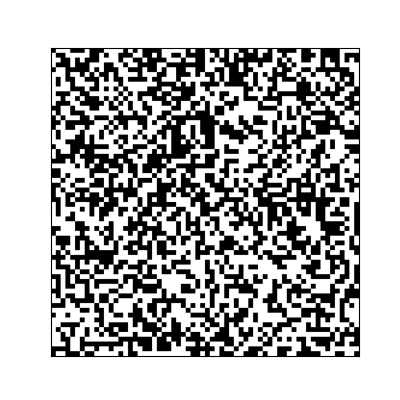

In [12]:
# @title Learning game of life
@jax.jit
def step(board):
  """Applies one step of Conway's Game of Life rules to the board.

  Args:
    board: A 2D array representing the game board (1 = live, 0 dead)

  Returns:
    board after one step of the game.

  """
  # Calculate the number of live neighbors for each cell.
  # jnp.roll shifts the board by the specified offsets (d)
  # to count neighbors in all 8 directions.
  n = sum(
      jnp.roll(board, d, (0, 1))
      for d in [
          (1, 0),  # Right
          (-1, 0),  # Left
          (0, 1),  # Down
          (0, -1),  # Up
          (1, 1),  # Down-right
          (-1, -1),  # Up-left
          (1, -1),  # Down-left
          (-1, 1),  # Up-right
      ]
  )

  # GOL rules:
  # - Birth: A dead cell with exactly 3 live neighbors becomes alive.
  # - Survive: A live cell with 2 or 3 live neighbors stays alive.
  # - Death: All other cells die.
  return (n == 3) | (board & (n == 2))  # Using bitwise OR and AND for efficiency


key = random.PRNGKey(42)
board = jax.random.randint(
    key, shape=(64, 64), minval=0, maxval=2, dtype=jnp.uint8
)

# Generate frames
frames = [zoom(board.astype(jnp.float32), 8)]
for _ in range(30):
  board = step(board)
  frames.append(zoom(board.astype(jnp.float32), 8))


visualize(frames, 'animation.gif', 4)
Image('animation.gif')

In [13]:
hyperparams = {'perceive': {}, 'update': {}}
hyperparams['seed'] = 23
hyperparams['lr'] = 0.05
hyperparams['batch_size'] = 20
hyperparams['num_epochs'] = 3000
hyperparams['num_steps'] = 1
hyperparams['channels'] = 1
hyperparams['periodic'] = 1
hyperparams['perceive']['n_kernels'] = 16
hyperparams['perceive']['layers'] = [9, 8, 4, 2, 1]
hyperparams['perceive']['connections'] = [
    'first_kernel',
    'unique',
    'unique',
    'unique',
]
init = (
    hyperparams['perceive']['n_kernels']
    * hyperparams['channels']
    * hyperparams['perceive']['layers'][-1]
    + hyperparams['channels']
)
hyperparams['update']['layers'] = (
    [init] + [128] * 16 + [128, 64, 32, 16, 8, 4, 2, hyperparams['channels']]
)
hyperparams['update']['connections'] = ['unique'] * len(
    hyperparams['update']['layers']
)
hyperparams['async_training'] = False

key = random.PRNGKey(hyperparams['seed'])
key, subkey = random.split(key, 2)


@partial(jax.jit, static_argnums=(1,))
def simulate_batch(boards, steps):
  def simulate_one(board):
    states = [board]
    for _ in range(steps):
      board = step(board)
      states.append(board)
    return jnp.stack(states)

  return jax.vmap(simulate_one)(boards)


def generate_binary_tensor():
  # Generate all possible combinations of 0s and 1s for 9 positions
  binary_numbers = jnp.arange(512)
  # Convert to binary and pad to 9 bits
  binary_array = (
      (binary_numbers[:, None] & (1 << jnp.arange(8, -1, -1))) > 0
  ).astype(jnp.float32)
  # Reshape to (512, 9, 1)
  tensor = binary_array.reshape(512, 9, 1)
  return tensor

initial_boards = generate_binary_tensor().reshape(-1, 3, 3).astype(jnp.uint8)

def sample_batch(key, trajectories, batch_size, state_size):
  n_samples = trajectories.shape[0]
  sample_idx = jax.random.randint(
      key, minval=0, maxval=n_samples, shape=(batch_size,)
  )
  init = jnp.zeros(
      (*trajectories[sample_idx, 0].shape, state_size), dtype=jnp.float32
  )
  init = init.at[..., 0].set(trajectories[sample_idx, 0])
  return init, trajectories[sample_idx, 1:, ..., None].astype(jnp.float32)


trajectories = simulate_batch(initial_boards, hyperparams['num_steps'])
batch_input, batch_output = sample_batch(
    subkey, trajectories, hyperparams['batch_size'], hyperparams['channels']
)

print(batch_input[8].reshape(3, 3))
print(batch_output[8, 0, :, :].reshape(3, 3))

ii = get_grid_patches(batch_input[8], 3, 1, 1)
print(ii[0].reshape(3, 3))

[[0. 1. 0.]
 [0. 1. 1.]
 [0. 0. 1.]]
[[0. 1. 0.]
 [0. 1. 1.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 1.]]


In [14]:
TrainState = namedtuple('TrainState', 'param opt_state key')

# Create optimizer
opt = optax.chain(
    optax.clip(100.0),  # Clips by value
    optax.adamw(
        learning_rate=hyperparams['lr'], b1=0.9, b2=0.99, weight_decay=1e-2
    ),
)

def init_state(hyperparams, opt, seed):
  key = random.PRNGKey(seed)
  key, subkey = random.split(key, 2)
  params, wires = init_diff_logic_ca(hyperparams, subkey)
  opt_state = opt.init(params)
  return TrainState(params, opt_state, key), wires


def loss_f(params, wires, train_x, train_y, periodic, num_steps, async_training, key):
  def eval(params, training):
    y = v_run_iter_nca(
        train_x, params, wires, training, periodic, num_steps, async_training, key
    )
    return jax.numpy.square(y[..., 0] - train_y[..., 0]).sum()

  return eval(params, 1), {'hard': eval(params, 0)}

val_and_grad = jax.value_and_grad(loss_f, argnums=0, has_aux=True)

# Helper function that can be used for clipping parameters.
upd_f = lambda p: p

@partial(jax.jit, static_argnums=(4, 5, 6))
def train_step(
    train_state, train_x, train_y, wires, periodic, num_steps, async_training
):
  params, opt_state, key = train_state
  key, k1 = jax.random.split(key, 2)
  (loss, hard), dx = val_and_grad(
      params, wires, train_x, train_y, periodic, num_steps, async_training, k1
  )
  dx, opt_state = opt.update(dx, opt_state, params)
  new_params = optax.apply_updates(params, dx)
  new_params = upd_f(new_params)
  return TrainState(new_params, opt_state, key), loss, hard

In [ ]:
train_state, wires = init_state(hyperparams, opt, hyperparams['seed'])

loss_soft = []
loss_hard = []

for i in range(hyperparams['num_epochs']):
  key, sample_key = random.split(key, 2)
  train_x, train_y = sample_batch(
      sample_key,
      trajectories,
      hyperparams['batch_size'],
      hyperparams['channels'],
  )
  train_state, soft_loss, hard_loss = train_step(
      train_state,
      train_x,
      train_y[:, 0, :, :],
      wires,
      hyperparams['periodic'],
      hyperparams['num_steps'],
      hyperparams['async_training'],
  )
  loss_soft.append(soft_loss)
  loss_hard.append(hard_loss['hard'])

  if i % 100 == 0:
    clear_output(wait=True)
    plot_training_progress(loss_soft, loss_hard, 1)
    print(i, soft_loss, hard_loss['hard'])

clear_output(wait=True)
plot_training_progress(loss_soft, loss_hard, 1, 'gof_loss.svg')

In [ ]:
"""Game of Life

We simulate the Game of Life using the learned
circuit on a 128x128 grid for 300 steps.
"""

N = 128
grid = random.randint(key, (N, N, 1), minval=0, maxval=2).astype(jnp.float32)

params, opt_state, key = train_state
training = False
periodic = True

print(grid.shape)

frames = []

nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 4))
for i in range(300):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  frames.append(zoom(nca_state[:, :, 0], 4))

visualize(frames, 'gof.gif', 5)
Image('gof.gif')

In [ ]:
"""Analysis of Gate Distributions:

This section investigates the learned gate distributions
for the Update and Perceive Networks in the Game of Life model.
"""

params, opt_state, key = train_state
analyze_circuit = jax.tree_util.tree_map(
    lambda x: jax.numpy.argmax(x, axis=-1), params
)
count_gates = jax.tree_util.tree_map(
    lambda x: ((x != 3) & (x != 5)).sum(), analyze_circuit
)
total_gates = sum(x for x in jax.tree_util.tree_leaves(count_gates))
print('TOTAL GATES:  ', total_gates)

perceive_networks = analyze_circuit['perceive']
update_networks = analyze_circuit['update']

# Perceive Network
perceive_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(perceive_networks)
]
perceive_net = jax.numpy.concatenate(perceive_networks_stats, axis=0)
perceive_net = perceive_net[((perceive_net != 3) & (perceive_net != 5))]

plot_hist_gates(
    perceive_net,
    'gof_perceive_gates.svg',
    'Distribution of Gates (Perceive Network)',
)

In [ ]:
# Update Network
update_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(update_networks)
]
update_net = jax.numpy.concatenate(update_networks_stats, axis=0)
update_net = update_net[((update_net != 3) & (update_net != 5))]

plot_hist_gates(
    update_net, 'gof_update_gates.svg', 'Distribution of Gates (Update Network)'
)

In [ ]:
# @title Learning Checkerboard
def create_checkerboard(image_size=(64, 64), shape_size=8):
  image = np.zeros(image_size)
  height, width = image_size
  # Create checkerboard pattern
  x, y = np.meshgrid(np.arange(width), np.arange(height))
  image = ((x // shape_size) + (y // shape_size)) % 2
  return image.astype(np.uint8)

img = create_checkerboard(image_size=(64, 64), shape_size=8)

plot_show(img)

In [ ]:
# Checkerboard pattern with synchronous training.

hyperparams = {'perceive': {}, 'update': {}}
hyperparams['seed'] = 23
hyperparams['lr'] = 0.05
hyperparams['batch_size'] = 2
hyperparams['num_epochs'] = 500
hyperparams['num_steps'] = 20
hyperparams['channels'] = 8
hyperparams['periodic'] = 0
hyperparams['perceive']['n_kernels'] = 16
hyperparams['perceive']['layers'] = [9, 8, 4, 2]
hyperparams['perceive']['connections'] = [
    'first_kernel',
    'unique',
    'unique',
    'unique',
]
init = (
    hyperparams['perceive']['n_kernels']
    * hyperparams['channels']
    * hyperparams['perceive']['layers'][-1]
    + hyperparams['channels']
)
hyperparams['update']['layers'] = (
    [init] + [256] * 10 + [128, 64, 32, 16, 8, hyperparams['channels']]
)
hyperparams['update']['connections'] = ['unique'] * len(
    hyperparams['update']['layers']
)
hyperparams['async_training'] = False

TARGET_SIZE = 16

train_state, wires = init_state(hyperparams, opt, hyperparams['seed'])
key = random.PRNGKey(hyperparams['seed'])

loss_soft = []
loss_hard = []

img = create_checkerboard((TARGET_SIZE, TARGET_SIZE), shape_size=2)

train_y = jnp.zeros(
    shape=(
        hyperparams['batch_size'],
        TARGET_SIZE,
        TARGET_SIZE,
        hyperparams['channels'],
    )
)
train_y = train_y.at[:, :, :, 0].set(img)

for i in range(hyperparams['num_epochs']):
  key, sample_key = random.split(key, 2)
  train_x = random.randint(
      key=sample_key,
      shape=(
          hyperparams['batch_size'],
          TARGET_SIZE,
          TARGET_SIZE,
          hyperparams['channels'],
      ),
      minval=0,
      maxval=2,  # maxval is exclusive
  ).astype(jnp.float32)

  train_state, soft_loss, hard_loss = train_step(
      train_state,
      train_x,
      train_y,
      wires,
      hyperparams['periodic'],
      hyperparams['num_steps'],
      hyperparams['async_training'],
  )
  loss_soft.append(soft_loss)
  loss_hard.append(hard_loss['hard'])

  if i % 100 == 0:
    clear_output(wait=True)
    plot_training_progress(loss_soft, loss_hard, 1)
    print(i, soft_loss, hard_loss['hard'])


clear_output(wait=True)
plot_training_progress(loss_soft, loss_hard, 1, 'checkerboard_loss.svg')

In [ ]:
"""Checkerboard pattern

Visualization of the recurrent dynamics of the learned circuit.
"""

grid = random.randint(
    key=sample_key,
    shape=(TARGET_SIZE, TARGET_SIZE, hyperparams['channels']),
    minval=0,
    maxval=2,  # maxval is exclusive
).astype(jnp.float32)

params, opt_state, key = train_state
wires = wires
training = False
periodic = False

frames = []

nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 16))
for i in range(20):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  frames.append(zoom(nca_state[:, :, 0], 16))

visualize(frames, 'board.gif', 5)
Image('board.gif')

In [ ]:
"""Analysis of Gate Distributions:

This section investigates the learned gate distributions
for the Update and Perceive Networks in the Synchronous Checkerboard model.
"""

params, opt_state, key = train_state
analyze_circuit = jax.tree_util.tree_map(
    lambda x: jax.numpy.argmax(x, axis=-1), params
)
count_gates = jax.tree_util.tree_map(
    lambda x: ((x != 3) & (x != 5)).sum(), analyze_circuit
)
total_gates = sum(x for x in jax.tree_util.tree_leaves(count_gates))
print('TOTAL GATES:  ', total_gates)


perceive_networks = analyze_circuit['perceive']
update_networks = analyze_circuit['update']

# Perceive Network
perceive_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(perceive_networks)
]
perceive_net = jax.numpy.concatenate(perceive_networks_stats, axis=0)
perceive_net = perceive_net[((perceive_net != 3) & (perceive_net != 5))]

plot_hist_gates(
    perceive_net,
    'checkerboard_perceive_gates.svg',
    'Distribution of Gates (Perceive Network)',
)

In [ ]:
# Update Network
update_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(update_networks)
]
update_net = jax.numpy.concatenate(update_networks_stats, axis=0)
update_net = update_net[((update_net != 3) & (update_net != 5))]

plot_hist_gates(
    update_net,
    'checkerboard_update_gates.svg',
    'Distribution of Gates (Update Network)',
)

In [ ]:
"""Checkerboard pattern: testing generalization

We simulate the learned circuit on a grid that is four times
bigger and for four times as many timesteps as during training.
"""

grid = random.randint(
    key=sample_key,
    shape=(TARGET_SIZE * 4, TARGET_SIZE * 4, hyperparams['channels']),
    minval=0,
    maxval=2,  # maxval is exclusive
).astype(jnp.float32)

params, opt_state, key = train_state
wires = wires
training = False
periodic = False

print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
for i in range(20 * 4):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  frames.append(zoom(nca_state[:, :, 0], 8))

visualize(frames, 'larger_board.gif', 5)
Image('larger_board.gif')

In [ ]:
"""Checkerboard pattern: testing fault-tolerance

We simulate the learned circuit on a grid that is four times
bigger and for four times as many timesteps as during training.

We extend the previous test by deactivating a 10x10 cell center
to evaluate pattern reconstruction under cell damage.
"""

grid = random.randint(
    key=sample_key,
    shape=(TARGET_SIZE * 4, TARGET_SIZE * 4, hyperparams['channels']),
    minval=0,
    maxval=2,
).astype(jnp.float32)

params, opt_state, key = train_state
wires = wires
training = False
periodic = False

print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
for i in range(20 * 4):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  # Deactivate cells
  nca_state = nca_state.at[
      nca_state.shape[0] // 2 - 10 : nca_state.shape[0] // 2 + 10,
      nca_state.shape[1] // 2 - 10 : nca_state.shape[1] // 2 + 10,
      :,
  ].set(0)
  frames.append(zoom(nca_state[:, :, 0], 8))

visualize(frames, 'fault_tolerance_board.gif', 5)
Image('fault_tolerance_board.gif')

In [ ]:
"""Checkerboard pattern: testing self-healing

We simulate the learned circuit on a grid that is four times
bigger and for four times as many timesteps as during training.

Similar to the previous test by deactivating a 10x10 cell center
to evaluate pattern reconstruction under cell damage.

We now re-activate the cells after 40 steps to evaluate self-healing.
"""

grid = random.randint(
    key=sample_key,
    shape=(TARGET_SIZE * 4, TARGET_SIZE * 4, hyperparams['channels']),
    minval=0,
    maxval=2,
).astype(jnp.float32)

params, opt_state, key = train_state
wires = wires
training = False
periodic = False

print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
for i in range(20 * 4):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  if i < 20 * 2:
    nca_state = nca_state.at[
        nca_state.shape[0] // 2 - 10 : nca_state.shape[0] // 2 + 10,
        nca_state.shape[1] // 2 - 10 : nca_state.shape[1] // 2 + 10,
        :,
    ].set(0)

  frames.append(zoom(nca_state[:, :, 0], 8))

visualize(frames, 'healing_board.gif', 5)
Image('healing_board.gif')

In [ ]:
"""Checkerboard pattern: testing robustness

Simulating the learned circuit on a 64x64 grid for 4000 steps,
we randomly reset a 10x10 square at each step and measure the
loss to assess synchronous circuit recovery with asynchronous updates.

We will use the computed err_sync to compare it to the asynchronously
trained circuit.
"""

grid = random.randint(
    key=sample_key, shape=(64, 64, hyperparams['channels']), minval=0, maxval=2
).astype(jnp.float32)

params, opt_state, key = train_state
wires = wires
training = False
periodic = False
target = create_checkerboard((64, 64), shape_size=2)
print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
err_sync = []
for i in range(4000):
  key, k1, k2, k3 = random.split(key, 4)
  nca_state = run_async(
      nca_state, params, wires, training, periodic, k1
  )  # async at inference

  index_x = random.randint(k2, shape=(), minval=0, maxval=nca_state.shape[0])
  index_y = random.randint(k3, shape=(), minval=0, maxval=nca_state.shape[0])
  i_x_0 = index_x
  i_x_1 = (
      index_x + 10 if index_x + 10 <= nca_state.shape[0] else nca_state.shape[0]
  )
  i_y_0 = index_y
  i_y_1 = (
      index_y + 10 if index_y + 10 <= nca_state.shape[1] else nca_state.shape[1]
  )
  nca_state = nca_state.at[i_x_0:i_x_1, i_y_0:i_y_1, :].set(0)
  frames.append(zoom(nca_state[:, :, 0], 8))
  err = jax.numpy.abs(nca_state[:, :, 0] - target)
  err_sync.append(err.sum())

In [ ]:
# @title Learning Chekerboard with Asynchronously Training
hyperparams = {'perceive': {}, 'update': {}}
hyperparams['seed'] = 23
hyperparams['lr'] = 0.05
hyperparams['batch_size'] = 1
hyperparams['num_epochs'] = 800
hyperparams['num_steps'] = 50
hyperparams['channels'] = 8
hyperparams['periodic'] = 0
hyperparams['perceive']['n_kernels'] = 16
hyperparams['perceive']['layers'] = [9, 8, 4, 2]
hyperparams['perceive']['connections'] = [
    'first_kernel',
    'unique',
    'unique',
    'unique',
]
init = (
    hyperparams['perceive']['n_kernels']
    * hyperparams['channels']
    * hyperparams['perceive']['layers'][-1]
    + hyperparams['channels']
)
hyperparams['update']['layers'] = (
    [init] + [256] * 14 + [128, 64, 32, 16, 8, hyperparams['channels']]
)
hyperparams['update']['connections'] = ['unique'] * len(
    hyperparams['update']['layers']
)
hyperparams['async_training'] = True


train_state, wires = init_state(hyperparams, opt, hyperparams['seed'])
key = random.PRNGKey(hyperparams['seed'])

loss_soft = []
loss_hard = []

img = create_checkerboard((TARGET_SIZE_ASYNC, TARGET_SIZE_ASYNC), shape_size=2)

train_y = jnp.zeros(
    shape=(
        hyperparams['batch_size'],
        TARGET_SIZE_ASYNC,
        TARGET_SIZE_ASYNC,
        hyperparams['channels'],
    )
)
train_y = train_y.at[:, :, :, 0].set(img)

for i in range(hyperparams['num_epochs']):
  key, sample_key = random.split(key, 2)
  train_x = random.randint(
      key=sample_key,
      shape=(
          hyperparams['batch_size'],
          TARGET_SIZE_ASYNC,
          TARGET_SIZE_ASYNC,
          hyperparams['channels'],
      ),
      minval=0,
      maxval=2,  # maxval is exclusive
  ).astype(jnp.float32)

  train_state, soft_loss, hard_loss = train_step(
      train_state,
      train_x,
      train_y,
      wires,
      hyperparams['periodic'],
      hyperparams['num_steps'],
      hyperparams['async_training'],
  )
  loss_soft.append(soft_loss)
  loss_hard.append(hard_loss['hard'])

  if i % 100 == 0:
    clear_output(wait=True)
    plot_training_progress(loss_soft, loss_hard, 1)
    print(i, soft_loss, hard_loss['hard'])

clear_output(wait=True)
plot_training_progress(loss_soft, loss_hard, 1, 'checkerboard_async_loss.svg')

In [ ]:
"""Checkerboard pattern with Asynchronous training

Visualization of the recurrent dynamics of the learned circuit.
"""

grid = random.randint(
    key=sample_key,
    shape=(TARGET_SIZE_ASYNC, TARGET_SIZE_ASYNC, hyperparams['channels']),
    minval=0,
    maxval=2,
).astype(jnp.float32)

params, opt_state, key = train_state
wires = wires
training = False
periodic = False

frames = []

nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 16))
for i in range(50):
  key, subkey = jax.random.split(key)
  nca_state = run_async(nca_state, params, wires, training, periodic, subkey)
  frames.append(zoom(nca_state[:, :, 0], 16))

visualize(frames, 'board_async.gif', 5)
Image('board_async.gif')

In [ ]:
"""Checkerboard pattern

Visualization of the recurrent dynamics of the learned circuit
using three different seed to compute asynchrnous masks.
"""

params, opt_state, key = train_state
wires = wires
training = False
periodic = False

frames = []
nca_state_1 = grid.copy()
nca_state_2 = grid.copy()
nca_state_3 = grid.copy()

ZOOM = 32
separator = jnp.zeros((TARGET_SIZE_ASYNC * ZOOM, 5)) + 0.5
frames.append(
    np.hstack([
        zoom(nca_state_1[:, :, 0], ZOOM),
        separator,
        zoom(nca_state_2[:, :, 0], ZOOM),
        separator,
        zoom(nca_state_3[:, :, 0], ZOOM),
    ])
)

for i in range(50):
  key, subkey = jax.random.split(key)
  nca_state_1 = run_async(
      nca_state_1, params, wires, training, periodic, subkey
  )
  key, subkey = jax.random.split(key)
  nca_state_2 = run_async(
      nca_state_2, params, wires, training, periodic, subkey
  )
  key, subkey = jax.random.split(key)
  nca_state_3 = run_async(
      nca_state_3, params, wires, training, periodic, subkey
  )
  frames.append(
      np.hstack([
          zoom(nca_state_1[:, :, 0], ZOOM),
          separator,
          zoom(nca_state_2[:, :, 0], ZOOM),
          separator,
          zoom(nca_state_3[:, :, 0], ZOOM),
      ])
  )

# Display the concatenated video
visualize(frames, 'board_async_multi.gif', 5)
Image('board_async_multi.gif')

In [ ]:
"""Checkerboard pattern with Asynchrnous Training: testing self-healing

We simulate the learned circuit on a grid that is four times
bigger and for four times as many timesteps as during training.

Similar to the previous test by deactivating a 10x10 cell center
to evaluate pattern reconstruction under cell damage.

We now re-activate the cells after 100 steps to evaluate self-healing.
"""

grid = random.randint(
    key=sample_key,
    shape=(TARGET_SIZE_ASYNC * 4, TARGET_SIZE_ASYNC * 4, hyperparams['channels']),
    minval=0,
    maxval=2,
).astype(jnp.float32)

params, opt_state, key = train_state
wires = wires
training = False
periodic = False

print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
for i in range(50 * 4):
  key, subkey = jax.random.split(key)
  nca_state = run_async(nca_state, params, wires, training, periodic, subkey)
  if i < 50 * 2:
    nca_state = nca_state.at[
        nca_state.shape[0] // 2 - 10 : nca_state.shape[0] // 2 + 10,
        nca_state.shape[1] // 2 - 10 : nca_state.shape[1] // 2 + 10,
        :,
    ].set(0)

  frames.append(zoom(nca_state[:, :, 0], 8))

visualize(frames, 'healing_board.gif', 5)
Image('healing_board.gif')

In [ ]:
"""Checkerboard pattern: testing robustness

We simulate the learned circuit on a 64x64 grid for 4000 steps.
At each time step, we randomly reset a 10x10 square and measure
the loss function to test how quickly the asynchronously trained
circuit recovers.

We will use the computed err_async to compare it to the synchronously
trained circuit.
"""

grid = random.randint(
    key=sample_key, shape=(64, 64, hyperparams['channels']), minval=0, maxval=2
).astype(jnp.float32)

params, opt_state, key = train_state
wires = wires
training = False
periodic = False
target = create_checkerboard((64, 64), shape_size=2)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
err_async = []
for i in range(4000):
  key, k1, k2, k3 = random.split(key, 4)
  nca_state = run_async(
      nca_state, params, wires, training, periodic, k1
  )  # async at inference

  index_x = random.randint(k2, shape=(), minval=0, maxval=nca_state.shape[0])
  index_y = random.randint(k3, shape=(), minval=0, maxval=nca_state.shape[0])

  i_x_0 = index_x
  i_x_1 = (
      index_x + 10 if index_x + 10 <= nca_state.shape[0] else nca_state.shape[0]
  )
  i_y_0 = index_y
  i_y_1 = (
      index_y + 10 if index_y + 10 <= nca_state.shape[1] else nca_state.shape[1]
  )
  nca_state = nca_state.at[i_x_0:i_x_1, i_y_0:i_y_1, :].set(0)
  frames.append(zoom(nca_state[:, :, 0], 8))
  err = jax.numpy.abs(nca_state[:, :, 0] - target)
  err_async.append(err.sum())

In [ ]:
"""Testing Robustness

This plot shows the robustness error difference between
synchronous and asynchronous training, as previously calculated.
"""

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.plot(
    err_async[:4000], color='#2E86C1', linewidth=2, label='Async', alpha=0.9
)

ax.plot(err_sync[:4000], color='#E74C3C', linewidth=2, label='Sync', alpha=0.9)

ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlabel('Iterations', fontsize=12, fontweight='bold')
ax.set_ylabel('Error', fontsize=12, fontweight='bold')

ax.set_title(
    'Error Comparison - Async vs Sync', fontsize=14, fontweight='bold', pad=20
)

ax.legend(
    frameon=True, fancybox=True, shadow=True, fontsize=10, loc='upper right'
)

for spine in ax.spines.values():
  spine.set_linewidth(1.5)

ax.set_facecolor('#f8f9fa')
fig.set_facecolor('white')

plt.tight_layout()

save_path = 'async_sync.svg'

with open(save_path, 'wb') as f:
  plt.savefig(f, format='svg')

plt.show()

In [ ]:
# @title base64 lizard image
'''
Importing the Lizard image in base64 format.
'''
lizard_byte = b64decode("iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAAXNSR0IArs4c6QAAAERlWElmTU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA6ABAAMAAAABAAEAAKACAAQAAAABAAAAIKADAAQAAAABAAAAIAAAAACshmLzAAAFrElEQVRYCcVXzW9bRRD/7b73bOfbaUnlfualtETQiDoUiYoPyZYoibi0pqQS6gH7ABKnNleEmlZIPcAh4i9wOABSU9RcUJMiSBASKiCIQQRSVClu2qahH66DE3++t8usU6e29RJwaGGl9e7OzM7Mm/nt7Br4nxtby752pjcsmRyUEhPSyEUQmkiuJb8enr7qpjMH/GQ8qviM4RCz3UkBRFaVXyeDr7aPMT5YwZMI8+HekxW0B7BwTIE+3BsQkOPl+vnsEmS9Dtvr6cBro/Fy3r+ZO6aAQh3Qx+agTS8g/8buomHPOzGIx1uQfbtroJQKPtxTjJIE/FLPhdaDEccUSCn36j8moP2QALudK36g9cImWE9tAAHSLBIIIzSGqR+nMAa45VbzmptjBAh08Rx9OUtbkDsa4OYM8s3HYJH1UuOMT9K8/FS0l3i1jI4RYJL9JB9xQ5DxFp2h08PxRL2GRu0+ZBiTITIURzqtojIi+sb6azFcknV0wDayIyRQ/Do3heP0z0n0WgLdDTo895ywX70wIqan+sWVONj8fHkkSrr/0eiYAgUmdvaliJTsXFZIXKZodNZpkORAypaBKQJfbn7uKyQXBgAJkUyYTtYIpMeJTjKqlsiIcrpa7n5Mqzm0VpVQ4zK6v8nAwQ0udF3PYNKW+IhSMp2xYSWTkLdvx5HNhnDyeqxcBRlXGFHNpO4F4UoUWLD6CDumQO1STYHRFixyNWdjlvqW2TSeJgeCLQb2UE1we1vBH91l8q6uYzgX8C7vWv4lXMRpZlJX9CR1+iK7QkaRnCNAR4xQHiW+X1iso86F8eeadPPgRhfadI62Syl8R6C84OL4NW3jDuGDMhXji0v91rXZQUKln7yPMZ/PZN5WZTQm9FzQqU5oyouKRl/CpBElz/YrumTiQwGeWxIy4KHj2O7m6Li8iDaDo3lzHU58eROZVhdmPdyX5TwsFxd9sCy11ccY87DmFpX/t+ThL2KKWN0cQUjGV0JFkXhd/Dblv7VzJ77RGtBAp4Dt34jdUwvoTFmoI+MvUkryTTq+TXHMbNkC+8qVJFyekPTtiMu+0Xi10fK1YwrYmZ5zlP8AJSgp7yRM+cc84PFAazfRUW/g+WYdp0fmMB1oQ7rZQFMih0VKzc25DN7bXo9LC5mYODreXW5otbkjCNXdT7nv5pJFkEot781mh2yG7pmsnTx/t4Dwyz5caHOD38qi8U4ekhzZ5dHwLDm3rdHjVxfaakbL6Y4RKBfAu9sP0VH34sTVoSL9k16T6TJqUIS2Egj3Nep4ho7pNpobeYH8zSw+dmv4+s/CxMIro8EKXQ6Lv3fAYRNOml40uMdZq9ffuKG1WCEPeA346UTsOz+H9w9uw2eJPH63RAdCa2PAEYRONitoXISRSftlJo1UIoGLW7dSkBrRSMd06agJH9WMzRSRG5YIUAKHKvZWLRwxUCVTsSzmVvAhaFpcMVjbprhweYKTqULsOzoVWqqA9msZtNBp8UDurdjssKgpAqWXEt/TuayqUAAMw7QhBxYLLHQxVZh5ko5lC3VNXd2M+x1sVpBqioClZ2OqppOGZFGLYRSvYg3slKrxN/Ji6PuCwBRd4YRH4omVelJhtWxRMwjpkrmr6gMl3SQ9SXoHtK7ooxLeWW9MbqYqmaHa/AuBcunw6Jo21mSuKK6asOGecdqowusVUnTjyOexkkjdp70zzRoz6c5Cku4Iq2+MgRxj4ANKhi7vU+XyNWGgZERaLEL6oeswRZlxxc8J+cEtIQdLssu4oaoKaRJNOUIvbqxEbV0RIEWrN7rM6IE6QwLF/KvnmjwyFlIbKH3Kb3CwoNU3OqHmD94BUnrvL11UGVBNOaFGul8OqVFd8aWHyUNxQBnhZ3uilPCwmpc3CsGE7BsLlmgPzQFlQOXflvIYxbmYDvXCElqu3+lhUnLoPx//Aq5HH06LSa+UAAAAAElFTkSuQmCC")

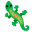

In [ ]:
# @title Learning to Grow the lizard

# Outline of the lizard, creating a mask with 1 and 0 to use as target image
target_img = load_byte(lizard_byte, TARGET_SIZE_EMOJI) > 0.26

target_img = (
    target_img[..., 2] | target_img[..., 1] | target_img[..., 0]
).astype(jnp.float32)


plot_show(zoom(target_img[..., None], 8))

In [ ]:
hyperparams = {'perceive': {}, 'update': {}}
hyperparams['seed'] = 23
hyperparams['lr'] = 0.06
hyperparams['batch_size'] = 1
hyperparams['num_epochs'] = 3500
hyperparams['num_steps'] = 12
hyperparams['channels'] = 128
hyperparams['periodic'] = 1
hyperparams['perceive']['n_kernels'] = 4
hyperparams['perceive']['layers'] = [9, 8, 4, 2, 1]
hyperparams['perceive']['connections'] = [
    'first_kernel',
    'unique',
    'unique',
    'unique',
]
init = (
    hyperparams['perceive']['n_kernels']
    * hyperparams['channels']
    * hyperparams['perceive']['layers'][-1]
    + hyperparams['channels']
)
hyperparams['update']['layers'] = (
    [init] + [512] * 8 + [256, hyperparams['channels']]
)
hyperparams['update']['connections'] = ['unique'] * len(
    hyperparams['update']['layers']
)
hyperparams['async_training'] = False

In [ ]:
TrainState = namedtuple('TrainState', 'param opt_state key')

# Create optimizer
opt = optax.chain(
    optax.clip(100.0),  # Clips by value
    optax.adamw(
        learning_rate=hyperparams['lr'], b1=0.9, b2=0.99, weight_decay=1e-2
    ),
)

val_and_grad = jax.value_and_grad(loss_f, argnums=0, has_aux=True)

upd_f = lambda p: p


@partial(jax.jit, static_argnums=(4, 5, 6))
def train_step(
    train_state, train_x, train_y, wires, periodic, num_steps, async_training
):
  params, opt_state, key = train_state
  key, k1 = jax.random.split(key, 2)
  (loss, hard), dx = val_and_grad(
      params, wires, train_x, train_y, periodic, num_steps, async_training, k1
  )
  dx, opt_state = opt.update(dx, opt_state, params)
  new_params = optax.apply_updates(params, dx)
  new_params = upd_f(new_params)
  return TrainState(new_params, opt_state, key), loss, hard


train_state, wires = init_state(hyperparams, opt, hyperparams['seed'])
key = random.PRNGKey(hyperparams['seed'])

loss_soft = []
loss_hard = []

train_y = jnp.zeros(
    shape=(
        hyperparams['batch_size'],
        TARGET_SIZE_EMOJI,
        TARGET_SIZE_EMOJI,
        hyperparams['channels'],
    )
)
train_y = train_y.at[:, :, :, 0].set(target_img)

train_x = jnp.zeros(
    shape=(
        hyperparams['batch_size'],
        TARGET_SIZE_EMOJI,
        TARGET_SIZE_EMOJI,
        hyperparams['channels'],
    )
)

# Seed
train_x = train_x.at[:, TARGET_SIZE_EMOJI // 2, TARGET_SIZE_EMOJI // 2, :].set(
    1
)

In [ ]:
for i in range(hyperparams['num_epochs']):
  train_state, soft_loss, hard_loss = train_step(
      train_state,
      train_x,
      train_y,
      wires,
      hyperparams['periodic'],
      hyperparams['num_steps'],
      hyperparams['async_training'],
  )
  loss_soft.append(soft_loss)
  loss_hard.append(hard_loss['hard'])

  if i % 100 == 0:
    clear_output(wait=True)
    plot_training_progress(loss_soft, loss_hard, 1)
    print(i, soft_loss, hard_loss['hard'])


clear_output(wait=True)
plot_training_progress(loss_soft, loss_hard, 1, 'lizard_logo_loss.svg')

In [ ]:
"""Growing the Lizard

Visualization of the recurrent dynamics of the learned circuit.
"""

grid = train_x[0]

params, opt_state, key = train_state
wires = wires
training = False
periodic = True

print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
for i in range(12):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  frames.append(zoom(nca_state[:, :, 0], 8))

visualize(frames, 'lizard.gif', 5)
Image('lizard.gif')

In [ ]:
"""Growing the Lizard: testing generalization

Visualization of the recurrent dynamics of the
learned circuit on a grid twice the size of the training grid.
"""

grid = jnp.zeros(
    shape=(
        TARGET_SIZE_EMOJI * 2,
        TARGET_SIZE_EMOJI * 2,
        hyperparams['channels'],
    )
)

# Seed
grid = grid.at[TARGET_SIZE_EMOJI * 2 // 2, TARGET_SIZE_EMOJI * 2 // 2, :].set(1)

params, opt_state, key = train_state
wires = wires
training = False
periodic = True

print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
for i in range(12):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  frames.append(zoom(nca_state[:, :, 0], 8))

visualize(frames, 'lizard.gif', 5)
Image('lizard.gif')

In [ ]:
"""Growing the Lizard: visualization of the hidden states

Visualization of the first 32 channels
"""

params, opt_state, key = train_state
wires = wires
training = False
periodic = True

frames = []

nca_state = train_x[0]
# Create subplot grid for all 32 channels
initial_grid = np.vstack([
    np.hstack([zoom(nca_state[:, :, 8 * j + i], 4) for i in range(8)])
    for j in range(4)
])
frames.append(initial_grid)

for i in range(12):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  channel_grid = np.vstack([
      np.hstack([zoom(nca_state[:, :, 8 * j + i], 4) for i in range(8)])
      for j in range(4)
  ])
  frames.append(channel_grid)

visualize(frames, 'hidden_lizard.gif', 5)
Image('hidden_lizard.gif')

In [ ]:
"""Analysis of Gate Distributions:

This section investigates the learned gate distributions
for the Update and Perceive Networks in the growing Lizard model.
"""

params, opt_state, key = train_state
analyze_circuit = jax.tree_util.tree_map(
    lambda x: jax.numpy.argmax(x, axis=-1), params
)
count_gates = jax.tree_util.tree_map(
    lambda x: ((x != 3) & (x != 5)).sum(), analyze_circuit
)
total_gates = sum(x for x in jax.tree_util.tree_leaves(count_gates))
print('TOTAL GATES:  ', total_gates)

perceive_networks = analyze_circuit['perceive']
update_networks = analyze_circuit['update']

# Perceive Network
perceive_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(perceive_networks)
]
perceive_net = jax.numpy.concatenate(perceive_networks_stats, axis=0)
perceive_net = perceive_net[((perceive_net != 3) & (perceive_net != 5))]


plot_hist_gates(
    perceive_net,
    'lizard_perceive_gates.svg',
    'Distribution of Gates (Perceive Network)',
)

In [ ]:
# Update Network
update_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(update_networks)
]
update_net = jax.numpy.concatenate(update_networks_stats, axis=0)
update_net = update_net[((update_net != 3) & (update_net != 5))]

plot_hist_gates(
    update_net,
    'lizard_update_gates.svg',
    'Distribution of Gates (Update Network)',
)

In [ ]:
# @title base64 G image
'''
Importing the Multicolor G image in base64 format.
'''
g_byte = b64decode("iVBORw0KGgoAAAANSUhEUgAABLAAAASwCAYAAADrIbPPAAAAAXNSR0IArs4c6QAAAERlWElmTU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA6ABAAMAAAABAAEAAKACAAQAAAABAAAEsKADAAQAAAABAAAEsAAAAABAZIJmAABAAElEQVR4AezdC5xdVXkw/LXOmUlCwiWQzCRQFPHWt+IFTCYRoZJkhihabNWm1lq1tlpra1v71Xqrr2L9aq32bfvZWlurvXhrK62+XhGYhCggkEkEL7RaEKIoJjMJCQiBkDlnfeukgBBymcu57H3Of36/Q+bsvfZaz/Nfh7k8s/Y6IfggQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0E6B2M7BjEWAAAECBAgQaLXAtrVPXtA3uWDhvjS5MFYrx8RQPzrU4zGVSjgqhHR0vR6OjZUwL8dxdMyfp/s+b8QVUzi+8W9KuW3jeAqNn5UWNo7lj/n52dz/+fSA/6ZwXD5SOeBo42mjh90PO55CPR+7/WHHG8dywDmu3fnflGLYlXuop3y8kkItx3pHvnJfjvTOWKnfm/+9Kzfa2zhfTeGO/Pnt9Wp9V22yfseJPwq3xy1bclsfBAgQIECAAIHyCyhglX8OZUCAAAECBLpSoFGIqk9WF8+JfYP1lBbnIs3iXIRanFIlf54W52LTwlBJC0OKjaJT/jc/4v5iU39XgswsqbvzZXfkR6NYdkf+wW93rqg1Cmp35LrY7hjjRK6xjcda2FGvVCZiJe6o9oXtiy66pnGNDwIECBAgQIBAYQQUsAozFQIhQIAAAQLdL5DWnTbntomjB/f1hZNDqC3Jq4pOzgWVJTHEnwihviSvKDoxKwzkx+L8yCumfHRCIBcL780/JO7Ixa0deW7G8xKw8RhD/jzsyKvTbkmV+MN6LX3/qH1zb114xRW7OhGjMQkQIECAAIHeElDA6q35li0BAgQIEGiZQFq1qm9X349OmgzhkTFVTsm3vz0ir4p6RB7wkbkQkh9xaf58sGUB6LhTAo1VXt/Pjx/mwtctlZj/TY3n6Qf5lsZb+yv17x8/ecytcePG/NLwQYAAAQIECBCYmYAC1szcXEWAAAECBHpOIBcn4s41Z55Uj7VH592ZHpMBHpOLVKfmFTqn5GJFfoTG6qm+noOR8FQEGsWrW/Jtnzfl18zN+fVyc/785lqluv/fJeuv2T6VTrQhQIAAAQIEeldAAat3517mBAgQIEDgYQJp3brq+K6tp+TiwuNDjI/LhYZcrMqFqlysyj80PDpf0Nj83AeBZgvsya+vm/PrLBe3wk0xpZtDrNyYapPfGgjHbrV6q9nc+iNAgAABAuUTUMAq35yJmAABAgQIzFpg16rTF07GuXkFVS5Q5cJUfle+0/LG6E/Ixar/lZ8vmPUAOiDQPIHGOynekn9ovSkXuP4z78V1fX4Lx5viZPjm4Maxbc0bRk8ECBAgQIBAkQUUsIo8O2IjQIAAAQKzFLhtZNlx++qV0/K79z0x1dMTU4yn5W/+p+Vu84bpPgiUXmA8Z/CtvOfWt/PeW9+ux/jNStz3jYFLr7219JlJgAABAgQIEHiIgALWQzg8IUCAAAEC5RRovLvfjp3znlivVJ+Y39nviXk1VX6ERrEqb57ug0DPCezMr/+v5df/N/LWbd/IKwy/tm9e7T9P+uyWPT0nIWECBAgQINAlAgpYXTKR0iBAgACB3hForKqarFeeEmI4I2d9en40/n1CfvTnhw8CBA4uUMuHv5MLWl+PIX29ngtbIaavLxkdu+ngzR0lQIAAAQIEiiSggFWk2RALAQIECBA4QOD7wysWzQlpKKS4LBescrEqNYpVjX2rfA8/wMpTAjMSiGFX3vttc752c94TbkutXtt80oZrvzujvlxEgAABAgQItEzAD78to9UxAQIECBCYnkBatqx/x7F9T06V+tkxxmX1lJblb9Q/lXvx/Xp6lFoTmK3A7bmo9c38f96WvG/clnotbTnxsrHrZ9up6wkQIECAAIGZC/iBeOZ2riRAgAABAjMWSBeEyvavLH9CtR7PTCmtzB0N5TpV4zbAvhl36kICBFop8MPc+eb8w/NYTPHKev2uTYMbr7+zlQPqmwABAgQIEPixgALWjy18RoAAAQIEWiawbe2TF1Tq/WeEevWsvO/O2XmgM/NjUcsG1DEBAq0WqOWN4r+dB7kixFzQskqr1d76J0CAAIEeF1DA6vEXgPQJECBAoDUCeaP1R+5LlWfkb7SNQtVZ+fHE/Ki2ZjS9EiBQEIFbchxX5oLWV2ItfmVxOuprcePGyYLEJgwCBAgQIFBqAQWsUk+f4AkQIECgKALb1q44tTKZzsl75qzKMT0jP04tSmziIECgUwLxzhTSpkpKX06xsmHghLuuiRdef2+nojEuAQIECBAos4ACVplnT+wECBAg0DGB7SND+Z0A49khpbPyN9NzcyAKVh2bDQMTKI3A3Xlz+K+GSrgi3344Onj8ni8raJVm7gRKgAABAh0WUMDq8AQYngABAgTKIbBt7dMHK5OT56SYRiohPjOvqjilHJGLkgCBAgvclX8Yv6qe99AKIV0xuKv+pbhly74Cxys0AgQIECDQMQEFrI7RG5gAAQIEiiyw87yVx9b31nPBKozkb5bDebXEaUWOV2wECHSFwO05iy/nx/pKtX7x4ku2fKsrspIEAQIECBBogoACVhMQdUGAAAEC5RdI69ZVx2/77oq8CuJZ+ZvjSM4ofx76yp+ZDAgQKLHA1hTixTn+L1bu6V8/cOWVPypxLkInQIAAAQKzElDAmhWfiwkQIECgzAK3rlq2uK9SXd24LTB/Q3xuzmVpmfMROwECXS1Qy28ScV0uaH2uUoufXXzZNV/NX7fy4lAfBAgQIECgNwQUsHpjnmVJgAABAllg/yqrHTc/LVbDeXkD9mflX/2emg/7XujVQYBAGQW25aAvjiF9cW+oXHry+k07y5iEmAkQIECAwFQF/NA+VSntCBAgQKCUArtWnb5wstr3rHqK58dKLlylcHwpExE0AQIEDi1Qy6e+klL4TKxWPj146TU3HLqpMwQIECBAoJwCCljlnDdREyBAgMBhBH646mmP6uurrc2/zJ2f769Zm7/ZzTlMc6cIECDQbQI35YQ+l9+E4rODkws2xo0bJ7stQfkQIECAQO8JKGD13pzLmAABAl0nkC4IlfEvDz0tr7B6bqNolb+5PaHrkpQQAQIEZiYwnm+g/mysh8/cc0//pY+46qq7Z9aNqwgQIECAQGcFFLA66290AgQIEJihQFq1qm+8eufqSgzPTyn+XO7GBuwztHQZAQI9I7AnhnhpivXPzK32/9/jLr7qtp7JXKIECBAgUHoBBazST6EECBAg0DsCN5z32LnH7jv+p2NeZZWzfmF+LOmd7GVKgACBpgrU8p6AV+e3sbiwXu3/l6WXfCWv1PJBgAABAgSKK6CAVdy5ERkBAgQIZIFta5+8oDI579khpufnp8/Jj2PAECBAgEBTBfbl3tbnr7MXWpnVVFedESBAgEATBRSwmoipKwIECBBojkBjpdXCvcevDZW4LqXUuD1Q0ao5tHohQIDAkQSszDqSkPMECBAg0BEBBayOsBuUAAECBA4USOtOm7Nj14Jz8/EX5qLVz+Z/jz2wjecECBAg0FaB/1mZlcInqnMr/7HoomvuaOvoBiNAgAABAg8SUMB6EIZPCRAgQKC9Amnduur4rq2rY0q/mEJ8Xv6mdEJ7IzAaAQIECExRoPHuhZ/Jm8B/dPHu2sVxy5ZGccsHAQIECBBom4ACVtuoDUSAAAEC9wv8cPXQadVqeEneQPil+diJ9x/3LwECBAiUQCCGXSmFC2Osf2RgdMuV+ReKVIKohUiAAAECJRdQwCr5BAqfAAECZRHYsebMn6jHyZ/P8b4sP84oS9ziJECAAIFDC+QVWd9NMf1riJUPDV56zQ2HbukMAQIECBCYnYAC1uz8XE2AAAEChxHYed7KY2t76y/I72z1khDiOblp5TDNnSJAgACB8go0VmFdlWL46Lxq378dd/FVt5U3FZETIECAQBEFFLCKOCtiIkCAQIkF0gWhMn7F0JpQDy+PMTwvp3JUidMROgECBAhMX2BvvuRTuZj1ocGzxzbEC/J3BB8ECBAgQGCWAgpYswR0OQECBAj8j8DOVStPrlXSi/Nqq1/PRx7NhQABAgQIZIHvhxg+Vpus/u2JG6/eSoQAAQIECMxUQAFrpnKuI0CAAIFw86pV8xZU9pwfc9Eq3zsynEl8X/G6IECAAIGDCdTzN4gNKcUPDCy669PxwuvvPVgjxwgQIECAwKEE/KJxKBnHCRAgQOCQAhPnrlher6dX5m8iL8yNjjtkQycIECBAgMDDBcbzHz0+Uo3VDy0evfq/Hn7aEQIECBAg8HABBayHmzhCgAABAgcRmDjrrGPCUfe+KL91+qvy6acepIlDBAgQIEBgegIpXJlC+rs75u7+xOMuurGxd5YPAgQIECBwUAEFrIOyOEiAAAEC9wvsHF75hFqsvzQ///WQwvH3H/cvAQIECBBoosDu3NeH69X4l0sv2XRzE/vVFQECBAh0iYACVpdMpDQIECDQTIED9rYaaWbf+iJAgAABAocReNBeWad8Ml54Ye0wbZ0iQIAAgR4SUMDqocmWKgECBI4kMDG84vH5Vo7fyu1elh/2tjoSmPMECBAg0DqBGG+MKby/f++cf1x4xRW7WjeQngkQIECgDAIKWGWYJTESIECghQLpglAZv2JoTf4l4XfzMM/JD98bWuitawIECBCYtsDe/J3pM6ke/nLJhrGvTPtqFxAgQIBAVwj4JaUrplESBAgQmL7A94dXLOqP9V+NKb46X33q9HtwBQECBAgQaLvAVSHFvxhY5PbCtssbkAABAh0WUMDq8AQYngABAu0WGB9ZfkZIldeEkF6Uxz6q3eMbjwABAgQINEFga4zpvZX+6ocWXXTNHU3oTxcECBAgUHABBayCT5DwCBAg0AwBtwk2Q1EfBAgQIFBAgR/lmP6xVqv+xYkbr95awPiERIAAAQJNElDAahKkbggQIFBEgca7Cc7v2/MLMdXfmLe2+qkixigmAgQIECDQBIF67uMLqZ7eteSyzVc2oT9dECBAgEDBBBSwCjYhwiFAgEAzBMZXDS1NffE3Ykr5VsGwqBl96oMAAQIECJRCIIYtKcT3Dk7O/3jcuHGyFDELkgABAgSOKKCAdUQiDQgQIFAegcb+VqkeXxdjWJej7i9P5CIlQIAAAQJNF7g5xfCePZML/vHUjRvvaXrvOiRAgACBtgooYLWV22AECBBojcD4yLKz88bsb8i9Pyc/fG1vDbNeCRAgQKCMAilMpEr8mzmT9/7l8Ruv213GFMRMgAABAn7J8RogQIBAaQUaG7Pv+PLQc0Il/mFKaWVpExE4AQIECBBoj8D+Dd9jX/1dAxdv+WF7hjQKAQIECDRLwF/pmyWpHwIECLRJ4IbzHjv32H0nvDDvb/XmPORPtmlYwxAgQIAAgW4R2Btj/ESanPyjwY1fvbFbkpIHAQIEul1AAavbZ1h+BAh0jcCuVacv3NfX/5qQwm/npAa7JjGJECBAgACBzgjsy8N+rFKt/+niS7Z8qzMhGJUAAQIEpiqggDVVKe0IECDQIYFbVy1b3NcXXxtSbLyj4HEdCsOwBAgQIECgWwXqObFP5TdBeceSyzZ9rVuTlBcBAgTKLqCAVfYZFD8BAl0rsG3t0wdjffI3862Cv5eTPLZrE5UYAQIECBAohkDKYXw+pvrbBjZs+WoxQhIFAQIECNwvoIB1v4R/CRAgUBCB20aWPXIyVX4/h/PK/DiqIGEJgwABAgQI9IrA/kJWiOmtg6Obr+2VpOVJgACBogsoYBV9hsRHgEDPCGxfs+wxeVPZN6UQX5K/OM/pmcQlSoAAAQIEiilQz/tO/ns1Vt6+aP01/1nMEEVFgACB3hFQwOqduZYpAQIFFXjQiqtX5RDnFjRMYREgQIAAgV4VaOyR9YW8R9Zb7JHVqy8BeRMgUAQBBawizIIYCBDoSYGda4ceUauF1+XkFa568hUgaQIECBAomUA9xPAflUr9rd61sGQzJ1wCBLpCQAGrK6ZREgQIlElg56qVJ9eq9T/IMf96fswrU+xiJUCAAAECBML+Qla9Et+w9JJNN/MgQIAAgfYIKGC1x9koBAgQCBPnnnFSSv1vCik1Nmd3q6DXBAECBAgQKLfAPXm39/ftC/FPTl6/aWe5UxE9AQIEii+ggFX8ORIhAQIlF7j9mWeesLc2+fq8Eezv5FS8q2DJ51P4BAgQIEDgoQLxzvyOhe+r9lfeueiia+546DnPCBAgQKBZAgpYzZLUDwECBA4Q2Lb2yQsqk/Nek3+ofWM+tfCA054SIECAAAEC3SWwI6T4Z7fPve0vH3fRjXu7KzXZECBAoPMCClidnwMRECDQZQJp2bL+HcdXXp5SuCCndmKXpScdAgQIECBA4DACMcTv5j9evXPx8Y/6ULzwwtphmjpFgAABAtMQUMCaBpamBAgQOJxAuiBUxr+8/MUxxrfndqcerq1zBAgQIECAQNcLXJtifNOS0U0Xd32mEiRAgEAbBBSw2oBsCAIEul9gfPXyZ4cY/zS/vfYTuz9bGRIgQIAAAQLTELi4Vg+/f+JlY9dP4xpNCRAgQOAAAQWsA0A8JUCAwHQEJlavXFav1N+dv5iumc512hIgQIAAAQI9JVDPK7Q/Vk/xD5asv2Z7T2UuWQIECDRJQAGrSZC6IUCgtwR2rh16xGQtvCV/EX1FzrzSW9nLlgABAgQIEJiZQLwzxfB/9kzOf9epGzfeM7M+XEWAAIHeFFDA6s15lzUBAjMU2H322cffO2/vG0IKv5u7mDfDblxGgAABAgQI9LbALXl/rLcMjm76SP6FLPU2hewJECAwNQEFrKk5aUWAQI8LpHWnzdlx24LX1EP6w/yF84Qe55A+AQIECBAg0BSBeEUlpP9n8fqxsaZ0pxMCBAh0sYACVhdPrtQIEGiOwPbhFT8XY3hPSOmxzelRLwQIECBAgACBBwTyXYXhY5Va5U2LNl7z/QeO+oQAAQIEHiKggPUQDk8IECDwY4Eda5f9r3qt8uf5yHk/PuozAgQIECBAgEBLBPbk2wrfc0f/bX/yuItu3NuSEXRKgACBEgsoYJV48oROgEBrBG5/5pkn7J2cfFvu/Tfzo681o+iVAAECBAgQIHAQgRhvDLX67w5etvkLBznrEAECBHpWQAGrZ6de4gQIHCiQli3rn1hYaRStLsiPhQee95wAAQIECBAg0EaBz9Wr8XeWXrLp5jaOaSgCBAgUVkABq7BTIzACBNopML56+bNDJf5FHvPx7RzXWAQIECBAgACBwwjcnX9he9edtQXvPnXjxnsO084pAgQIdL2AAlbXT7EECRA4nMDOVStPrveld6aUXnK4ds4RIECAAAECBDoocEveH+stS0Y3fbiDMRiaAAECHRVQwOoov8EJEOiUwC1nnnnUnAW1N8SU3pBjmNepOIxLgAABAgQIEJiqQExhfaxUf3vx6NX/NdVrtCNAgEC3CChgdctMyoMAgSkLbBtZ/rOVtP92wVOnfJGGBAgQIECAAIFiCNyTf4l75+IT9vxpvPD6e4sRkigIECDQegEFrNYbG4EAgYIIjK966mNDtfKXIcTnFCQkYRAgQIAAAQIEZipwQ70SXr300rH1M+3AdQQIECiTgAJWmWZLrAQIzEigcbvg3AX7/jCk+LrcwdwZdeIiAgQIECBAgEDxBFIO6UNz9s59/cIrrthVvPBERIAAgeYJKGA1z1JPBAgUUGBieOXqlOp/E2L4XwUMT0gECBAgQIAAgVkL5CrWbZUY3rR4dOzv8y94jaKWDwIECHSdgAJW102phAgQaAiMrxpaGvviu727oNcDAQIECBAg0EMCG2M9/cbAZZu/3UM5S5UAgR4RUMDqkYmWJoFeEch/cozjIytekt9d8M9zzot6JW95EiBAgAABAgTuE7g7xfjuwePveqdN3r0mCBDoJgEFrG6aTbkQ6HGB8ZHlZ6QU/zZ/YVvR4xTSJ0CAAAECBAh8o5LSKxZv2LwJBQECBLpBQAGrG2ZRDgR6XODW85fNr+6p/FH+gva7maKvxzmkT4AAAQIECBC4X6AWQ/zze/ZU3/aIq666+/6D/iVAgEAZBRSwyjhrYiZA4AGB8TVDz8gbtP99PvD4Bw76hAABAgQIECBA4MEC34kxvWJgdPPGBx/0OQECBMokoIBVptkSKwECDwjsWnX6wnur/X+av4i9Mh/0tewBGZ8QIECAAAECBA4qkPJeoX8fa3t+f3Dj9XcetIWDBAgQKLCAX/oKPDlCI0Dg4AITa4bOTzG8P5/9iYO3cJQAAQIECBAgQOAQAjdXUsx7Y23acIjzDhMgQKCQAgpYhZwWQREgcDCBiWcuOzFNVv4qn3vBwc47RoAAAQIECBAgMCWB/auxKvfMed3AlVf+aEpXaESAAIEOCyhgdXgCDE+AwJEF8nL3uGNk6JX5J6335NbHHvkKLQgQIECAAAECBKYgsDWvan/lktGx0Sm01YQAAQIdFVDA6ii/wQkQOJLAbSPLHjmZKh/M7c49UlvnCRAgQIAAAQIEpi2Q/0YYP5Cq9/z+0ku+fte0r3YBAQIE2iSggNUmaMMQIDB9gfE1K9aFSvq7kMLx07/aFQQIECBAgAABAtMQuDkven/Z4PpNl0/jGk0JECDQNgEFrLZRG4gAgakK3LfX1d/l9udP9RrtCBAgQIAAAQIEZi1Qy+/t/GcDx+95a7zw+ntn3ZsOCBAg0EQBBawmYuqKAIHZC1h1NXtDPRAgQIAAAQIEZinwjRQqv7xk/TVfn2U/LidAgEDTBBSwmkapIwIEZiOwc9XKk2t9tQ+FFNfOph/XEiBAgAABAgQINEXg7tzLGwfWj/1V/qUxv6eODwIECHRWQAGrs/5GJ0AgCzRWXaWY/jZ/QToBCAECBAgQIECAQHEE8s9no5Va5eWLNl7z/eJEJRICBHpRQAGrF2ddzgQKIrBr1ekLJ6v9f5X/pPfLBQlJGAQIECBAgAABAg8XuD3G8PqB0bEPPPyUIwQIEGiPgAJWe5yNQoDAAQLbR1Y8M6b0D/nwSQec8pQAAQIECBAgQKCAAimFj/fNrbx60UXX3FHA8IREgECXCyhgdfkES49A0QRuOfPMo+YumHxb3knhD3JslaLFJx4CBAgQIECAAIFDC8QQv1tP6ZeWbBj7yqFbOUOAAIHmCyhgNd9UjwQIHEJg2+plKyuVyofz6ccfoonDBAgQIECAAAECxRfYl0J8y+BPb/qzeEGoFz9cERIg0A0CCljdMItyIFBwgbzHVZwYHvqdHOZ78qO/4OEKjwABAgQIECBAYAoC+We8DZXK5EsGLr321ik014QAAQKzElDAmhWfiwkQOJLAzrVDj6hNho+EGM45UlvnCRAgQIAAAQIESiaQwkSsxJcPjG76fMkiFy4BAiUTUMAq2YQJl0CZBLavWfG8ENMH8xeaE8oUt1gJECBAgAABAgSmJZAXY4W/un3Ortc/7qIb907rSo0JECAwRQEFrClCaUaAwNQF9m/UPn/yXfmKxm2DPggQIECAAAECBHpD4KuhUvnFwUuvuaE30pUlAQLtFFDAaqe2sQj0gMDEmmVPTbHy8ZzqT/ZAulIkQIAAAQIECBB4qMCP8i+Zrx5YP/axhx72jAABArMTUMCanZ+rCRC4T6CxUfuOkeWvraf4rvyFZQ4YAgQIECBAgACB3hWIMf3t7v7dr3VLYe++BmROoNkCCljNFtUfgR4UuG1k2XGTqfrBENLP92D6UiZAgAABAgQIEDi4wLUp1dct2bDlOwc/7SgBAgSmLqCANXUrLQkQOIjAjjXLV9Rj/Nd86tSDnHaIAAECBAgQIECgtwXuyH/k/LXB9Zv/vbcZZE+AwGwFFLBmK+h6Aj0q0LhlcGJ4qLFJ+3vyo79HGaRNgAABAgQIECBwZIH971I4sLv+urhly74jN9eCAAECDxdQwHq4iSMECBxB4NZVyxb39VX/OaT07CM0dZoAAQIECBAgQIDAfQLxiljZ98KBS6+9FQkBAgSmK6CANV0x7Qn0uMDEyPJVKcXGu8qc1OMU0idAgAABAgQIEJi+wHiK4cVLRsdGp3+pKwgQ6GWBSi8nL3cCBKYu0LhlcHx46E25eNX4YUPxaup0WhIgQIAAAQIECPxYYDCm8MW8FcVb0wXB76M/dvEZAQJHELAC6whAThMgEMLO81YeW7u3/g/Z4gU8CBAgQIAAAQIECDRFIMYv9E/e++LjN163uyn96YQAga4WUMDq6umVHIHZC4yfO3R6qIfGu8Y8Zva96YEAAQIECBAgQIDAgwRivLFWSz934mVj1z/oqE8JECDwMAFLNh9G4gABAvcLbB9Z8dJcvLoyP1e8uh/FvwQIECBAgAABAs0TSOmx1Uq8evvIciv9m6eqJwJdKWAFVldOq6QIzE7g5lWr5s2v3PXeGMMrZ9eTqwkQIECAAAECBAhMSSCFGN49cPbYm+MF+U+oPggQIHCAgALWASCeEuh1ge0jQ4/OG2v+R3Y4vdct5E+AAAECBAgQINBugfT5/trkL9sXq93uxiNQfAEFrOLPkQgJtE0g3zL4zJDSx/MXhhPaNqiBCBAgQIAAAQIECDxYIO+LVa/Un7f0ks3ffPBhnxMg0NsC9sDq7fmXPYH9AimEOL5mxRtiSp9XvPKiIECAAAECBAgQ6KhA3herUqtcNT68/Oc7GofBCRAolIAVWIWaDsEQaL/A+KrTjg598/8hpLCu/aMbkQABAgQIECBAgMAhBVL+GfWPBzaMvTX/4pr/5uqDAIFeFlDA6uXZl3vPC4yveupjQ7X6yQzxpJ7HAECAAAECBAgQIFBUgf+oV/e+bOklX7+rqAGKiwCB1gsoYLXe2AgECikwPjz0rPxOLx/Pf8s6vpABCooAAQIECBAgQIDAjwW+1hfrzz1hdMv3fnzIZwQI9JKAPbB6abblSiAL7N/vanjoTfnTzyteeUkQIECAAAECBAiUROApk6ly9Y7hoaGSxCtMAgSaLGAFVpNBdUegyAI3nPfYucfdu/ADec/2lxY5TrERIECAAAECBAgQOITA3vwH2VcsWT/20UOcd5gAgS4VUMDq0omVFoEDBSaeuezEUKt+KqW08sBznhMgQIAAAQIECBAokUDKW2G8e+DssTfHC0K9RHELlQCBWQgoYM0Cz6UEyiIwfu7Q6akePp3/h39kWWIWJwECBAgQIECAAIHDC8R/n5xfe9lJn92y5/DtnCVAoBsEFLC6YRblQOAwAuNrVqwLMf1TbjL/MM2cIkCAAAECBAgQIFBGgeuq1fDcRZeM3VLG4MVMgMDUBWziPnUrLQmUSmD/Zu1rht6Ri1f/lgNXvCrV7AmWAAECBAgQIEBgigKn12rhqu2rVzxliu01I0CgpAJWYJV04oRN4HACt56/bH7fXZWP5L0Bnn+4ds4RIECAAAECBAgQ6BKBH6UY1y0Z3XRxl+QjDQIEDhBQwDoAxFMCZRdobNaeJiufznl4i+GyT6b4CRAgQIAAAQIEpiNQSym+ZsmGTX87nYu0JUCgHAIKWOWYJ1ESmJLAtrXLn1itVT6XQjplShdoRIAAAQIECBAgQKD7BN47sH7stfmX3byrhg8CBLpFQAGrW2ZSHj0vsH3NyrUx1j+RIY7reQwABAgQIECAAAECvS0Qw4V3TS546akbN97T2xCyJ9A9AgpY3TOXMulhgYmRoV9PKbwvE/T1MIPUCRAgQIAAAQIECDxIIF3WX5t8/vEbr9v9oIM+JUCgpAIKWCWdOGETaAikdeuqE7u2/nFeHP0GIgQIECBAgAABAgQIPFQg30P4n7U0+eyTNlz73Yee8YwAgbIJKGCVbcbES+A+gW1rn7ygUpv7r/npz0AhQIAAAQIECBAgQOCQAj8MMT1ncHTztYds4QQBAoUXUMAq/BQJkMDDBbatffpgpbbvc/mMdxp8OI8jBAgQIECAAAECBA4QiHfmdyh8wZIN11xywAlPCRAoiUClJHEKkwCB+wS2jww9OhevLs9PFa+8KggQIECAAAECBAhMSSAdHWL9sxNrlr9oSs01IkCgcAIKWIWbEgEROLTAjjXLV8QUrsotHn/oVs4QIECAAAECBAgQIHCgQL79aE6K8WMTw0O/f+A5zwkQKL6AAlbx50iEBPYLTKxe/tx6jJflJ4NICBAgQIAAAQIECBCYkUD+e3D4s/GRoXflf22pMyNCFxHojID/YTvjblQC0xIYH1n+qyHFv8sX9U3rQo0JECBAgAABAgQIEDiUwD8N1Ba8Mm7cOHmoBo4TIFAcAQWs4syFSAg8TKDxV6GJ4RX/bwjpzQ876QABAgQIECBAgAABArMTSOGTd9UXvPjUjRvvmV1HriZAoNUCClitFtY/gRkKpHXrquM7t74/xvDKGXbhMgIECBAgQIAAAQIEjiSQwpf6KvWfPWF0y+1Hauo8AQKdE1DA6py9kQkcUuCG8x4797h7T/hoXnn184ds5AQBAgQIECBAgAABAs0RSOGbldD3rMUbrvpBczrUCwECzRawiXuzRfVHYJYCt40sO+64vcdfrHg1S0iXEyBAgAABAgQIEJiqQAxPrMXJD0+1uXYECLRfwIbQ7Tc3IoFDCmwfXrlkMtUvyu+HcsYhGzlBgAABAgQIECBAgEBTBfLes9/LP4PbuqOpqjoj0FwBK7Ca66k3AjMW2LZ2xakx1C/PHShezVjRhQQIECBAgAABAgSmJ3Bf8Wr1ktGxm6Z3pdYECLRToNrOwYxFgMDBBbavXvGUSkiX5bOnHLyFowQIECBAgAABAgQItEBga71WXbV0w6abW9C3LgkQaKKAAlYTMXVFYCYCO4aHhvJy5UvytYMzud41BAgQIECAAAECBAhMX+C+lVdrFK+mb+cKAp0QcAthJ9SNSeA+gYlzh86ph7A+P10EhQABAgQIECBAgACB9gjcV7xy22B7uI1CoCkCClhNYdQJgekLTIyseE6qh4vylcdM/2pXECBAgAABAgQIECAwEwHFq5mouYZA5wUUsDo/ByLoQYHx4aEXppQ+lVM/qgfTlzIBAgQIECBAgACBjggoXnWE3aAEmiKggNUURp0QmLrA9jXLX5JbfzQ/+qd+lZYECBAgQIAAAQIECMxGQPFqNnquJdB5AQWszs+BCHpIYHx4+W/FGP8pp9zXQ2lLlQABAgQIECBAgEBHBRSvOspvcAJNEVDAagqjTggcWWB8ZOgtIcS/zi39f3dkLi0IECBAgAABAgQINEtga71WPWfJ6NhNzepQPwQItF/AL9LtNzdiDwpsH1lxQUjhHT2YupQJECBAgAABAgQIdEygsfIqxTB84sart3YsCAMTINAUgdiUXnRCgMAhBcbXDL0jxJBXX/kgQIAAAQIECBAgQKBdAm4bbJe0cQi0R8A+PO1xNkoPCuRvmHF8zYr/E2L6vR5MX8oECBAgQIAAAQIEOiageNUxegMTaJmAFVgto9VxLws0ilcTw0N/kQ1+t5cd5E6AAAECBAgQIECg3QKKV+0WNx6B9ggoYLXH2Sg9JLC/eDWy4r0hpdf0UNpSJUCAAAECBAgQINBxAcWrjk+BAAi0TKDasp51TKAHBdIFoTJRXfHBENKrejB9KRMgQIAAAQIECBDopEDj3QZXLd2w6eZOBmFsAgRaI6CA1RpXvfagQGPl1Xh1xftjSK/swfSlTIAAAQIECBAgQKBjAvetvFqjeNWxKTAwgZYLVFo+ggEI9IBAo3i1Y83Q+3LxysqrHphvKRIgQIAAAQIECBRH4L7i1eolo2M3FScqkRAg0GwB70LYbFH99ZxAo3iVN2z/65z4q3sueQkTIECAAAECBAgQ6KCA4lUH8Q1NoM0CVmC1Gdxw3SWwv3jV2LA9hN/srsxkQ4AAAQIECBAgQKDYAopXxZ4f0RFotoACVrNF9ddTAjuGl7/Luw321JRLlgABAgQIECBAoAACilcFmAQhEGizgFsI2wxuuO4RGF8z9Cf5G+fruycjmRAgQIAAAQIECBAovoDiVfHnSIQEWiGggNUKVX12vcDE8PI/Vbzq+mmWIAECBAgQIECAQPEEttZr1dUnbrx6a/FCExEBAq0UUMBqpa6+u1JgYs3yt6UQrbzqytmVFAECBAgQIECAQFEF7lt5Nax4VdQZEheB1grE1navdwLdJTA+PPS7OaO/7K6sZEOAAAECBAgQIECg2AJuGyz2/IiOQDsEFLDaoWyMrhAYH1n+qyHFD+Zk/H/TFTMqCQIECBAgQIAAgTIIKF6VYZbESKD1An4Rb72xEbpAYPua5S+JMf5TTsU7d3bBfEqBAAECBAgQIECgHAKKV+WYJ1ESaIeAAlY7lI1RaoHta1Y8L8b0iZyEPeNKPZOCJ0CAAAECBAgQKJOA4lWZZkusBFovoIDVemMjlFhg+5qVa2OsfyanMLfEaQidAAECBAgQIECAQKkEFK9KNV2CJdAWgWpbRjEIgRIKTJw7dE4I6XM59HklDF/IBAgQIECAAAECBMoqsLVeq65aumHTzWVNQNwECDRfwAqs5pvqsQsEtg+vfHIM9S/lVBZ2QTpSIECAAAECBAgQIFAKASuvSjFNgiTQEQF7+nSE3aBFFhhf9dTHhlC/OMeoeFXkiRIbAQIECBAgQIBAVwkoXnXVdEqGQNMF3ELYdFIdlllg4twzTgqxb2PO4eQy5yF2AgQIECBAgAABAmUSULwq02yJlUBnBCqdGdaoBIonsGvV6QtTve8LObJHFS86EREgQIAAAQIECBDoTgHFq+6cV1kRaLaAAlazRfVXSoFbz182f1+lv7Fh+1NKmYCgCRAgQIAAAQIECJRQQPGqhJMmZAIdElDA6hC8YYsjkJYt6+/bU/n3EMNZxYlKJAQIECBAgAABAgS6W0DxqrvnV3YEmi2ggNVsUf2VSiBdECrjx8d/zkGfV6rABUuAAAECBAgQIECg3AJb67XqOUtGx24qdxqiJ0CgXQLehbBd0sYppMD45cvfE0N8USGDExQBAgQIECBAgACBLhS4b+XV8Ikbr97ahelJiQCBFgnEFvWrWwKFF9g+PPSb+X+A9xU+UAESIECAAAECBAgQ6BIBtw12yURKg0AHBBSwOoBuyM4LjA8PvTBH8fH8cBtt56dDBAQIECBAgAABAj0goHjVA5MsRQItFFDAaiGurospMDGyfFVK8Ys5urnFjFBUBAgQIECAAAECBLpLQPGqu+ZTNgQ6IaCA1Ql1Y3ZMYNva5U+s1OLlOYCFHQvCwAQIECBAgAABAgR6SEDxqocmW6oEWihQbWHfuiZQKIGdq1aenAPakB9LChWYYAgQIECAAAECBAh0qYDiVZdOrLQIdEDA/j8dQDdk+wV2rTp94WS1fnEe+RHtH92IBAgQIECAAAECBHpSYGu9Vj1nyejYTT2ZvaQJEGiqgAJWUzl1VkSBtGxZ/2S1/8J8v+wTihifmAgQIECAAAECBAh0m0Bj5VWKYfjEjVdv7bbc5EOAQGcEFLA6427UNgqML6z+Vf4GOtLGIQ1FgAABAgQIECBAoGcF3DbYs1MvcQItFVDAaimvzjstMDE89L9jSK/qdBzGJ0CAAAECBAgQINALAopXvTDLciTQGQHvQtgZd6O2QWB8ZOgXQgr/mofyOm+DtyEIECBAgAABAgR6W0DxqrfnX/YEWi3gF/tWC+u/IwLjI8vODqkymgef25EADEqAAAECBAgQIECghwQUr3posqVKoEMCClgdgjds6wS2r1n2mBgqV+V1VwOtG0XPBAgQIECAAAECBAg0BBSvvA4IEGiHgD2w2qFsjLYJ3P7MM0+IsXKR4lXbyA1EgAABAgQIECDQ2wJb67XqOUtGx27qbQbZEyDQagEFrFYL679tAmnZsv57901+Ig/4uLYNaiACBAgQIECAAAECPSrQWHmVYhg+cePVW3uUQNoECLRRQAGrjdiGaq3AjuMq/1/jG2hrR9E7AQIECBAgQIAAAQJuG/QaIECg3QJ97R7QeARaITA+PPQ7+Zvoq1vRtz4JECBAgAABAgQIEPixgOLVjy18RoBA+wRs4t4+ayO1SGD7mpVrY6x/PnevINsiY90SIECAAAECBAgQaAgoXnkdECDQKQEFrE7JG7cpAhOrl/9kqsSrc2cLm9KhTggQIECAAAECBAgQOKiA4tVBWRwkQKBNAvbAahO0YZov0HjHwVy8+mzuWfGq+bx6JECAAAECBAgQIPCAgOLVAxQ+IUCgQwIKWB2CN+zsBNKqVX17J/f9e+7FOw7OjtLVBAgQIECAAAECBI4ksLVeq56zZHTspiM1dJ4AAQKtErBnUKtk9dtSgYnqXf8nhLi6pYPonAABAgQIECBAgECPC9y38mr4xI1Xb+1xCukTINBhAXtgdXgCDD99ge1rlr8kxvjh6V/pCgIECBAgQIAAAQIEpirgtsGpSmlHgEA7BBSw2qFsjKYJjI8sPyOkeGXu8KimdaojAgQIECBAgAABAgQeIqB49RAOTwgQKICAAlYBJkEIUxPYPrxySQz1zbn1yVO7QisCBAgQIECAAAECBKYroHg1XTHtCRBoh4BN3NuhbIxZC6Rly/pjqv9b7kjxataaOiBAgAABAgQIECBwcAHFq4O7OEqAQOcFFLA6PwcimILAjuPje0MM50yhqSYECBAgQIAAAQIECMxAQPFqBmguIUCgbQJuIWwbtYFmKjCxZsUrUkx/P9PrXUeAAAECBAgQIECAwBEFttZq1dXebfCIThoQINAhAQWsDsEbdmoC4+cOnR7q4Su5tU3bp0amFQECBAgQIECAAIFpCVh5NS0ujQkQ6JCAWwg7BG/YIwvc/swzT8jFq0/mlopXR+bSggABAgQIECBAgMC0BRSvpk3mAgIEOiSggNUheMMeXiBdECp7Jyc/lludeviWzhIgQIAAAQIECBAgMBMBxauZqLmGAIFOCShgdUreuIcVmPjy0Ntzg2cdtpGTBAgQIECAAAECBAjMSEDxakZsLiJAoIMC9sDqIL6hDy4wMbziZ1JIn85nFVgPTuQoAQIECBAgQIAAgRkLKF7NmM6FBAh0UEABq4P4hn64wK1rzjilL/ZtyWcWPfysIwQIECBAgAABAgQIzEZA8Wo2eq4lQKCTAla4dFLf2A8RuHnVqnm5eNXYtF3x6iEynhAgQIAAAQIECBCYvYDi1ewN9UCAQOcEFLA6Z2/kAwQWVPe8Lx966gGHPSVAgAABAgQIECBAYJYCilezBHQ5AQIdF3ALYcenQAANgYnh5b+YQvwXGgQIECBAgAABAgQINFdA8aq5nnojQKAzAgpYnXE36oME8qbtj8+btm/Oh4550GGfEiBAgAABAgQIECAwSwHFq1kCupwAgcII9BUmEoH0pMCt5y+bn+5K/xGi4lVPvgAkTYAAgc4ITOZhd4cYd4eUdue/5u1OMexK9bC7EtOuvCK48Xx3pZ5251/8dqdK3FcJaTLUqj+6P9x6tb7r/s9rk/U75k8eVWs8nzhm257HXXTj3vvP7T921lnH9Mf4kJ+56vPuPmZfqPSFVDm6Ug/9oa9+dD2F/vwHnQXVFI7KsR1bT3FhTOmY/D3y2P3fJ1M4NqawMMfW2CtycX40/j2qMYYPAgQIHEJga71WXX3ixqu3HuK8wwQIECiNgBVYpZmq7gx0fHjFh0JIv9qd2cmKAAECBNorEO8MoX5LLkD9sBLjD1I9/SBU4q0phVtSvfbD/tT3g1q4c/fgxutzu+74aPwhaN7dYXGtHhbXK9WBUK8Phlg5MYZ0Us5waX7c/+9P5M/nd0fWsiBAYIoCW2uKV1Ok0owAgTIIKGCVYZa6NMbtIytemv+y/M9dmp60CBAgQKDZAilM5C7/O1Tyox6/kyrhlvxHkFv7UuXW+j19twxceeUDK6SaPXQ39Ldr1ekL741zTqmE+il5VdmpeVXXo0IKp+TcTskrzR6Vfyg8oRvylAMBAvsFFK+8EAgQ6DoBBayum9JyJGTfq3LMkygJECDQAYG9uZjynRjD9Xnsm/IPKjfVG/9Ohm8Obhzb1oF4embI3Wefffy+/n2PTjE9Oie9/998y+JpudD1pPz82J6BkCiBkgvkr6Hfy//frl4yOnZTyVMRPgECBB4ioID1EA5P2iFwy5lnHjVv/uRY/uZ6WjvGMwYBAgQIFFLgrhzV13OB5Lq8ouq6vJLqv0Os/ffApdfeWshoezyonWuHHjFZj08I9fSkXFxsfP9+Yn48IT/cltjjrw3pF07AyqvCTYmACBBoloACVrMk9TNlge3DK/42783xqilfoCEBAgQIlFugcetfDNflr/3X5kSujdV03aLjHn1DvPDC/Ruflzu53o0+XRAq419edmqoVJ4S6+GMENMZIcSnZpETe1dF5gQ6KqB41VF+gxMg0GoBBaxWC+v/IQLbR4aen//a/h8POegJAQIECHSNQOPWlfx1fnNeVXVtTPG6Si1et2jjNd/vmgQlckSB8VVDS0OlUcyqPDXG+vK8qf7T8kWNDeV9ECDQOgHFq9bZ6pkAgYIIKGAVZCJ6IYydq1aeXKvW820i+9/2uxdSliMBAgS6XaCeC1bfykleEWK8Mm+qfvnSSzbd3O1Jy2/6AhPnnnFSqPUty6+Rs0I9nJ1X5C3Lvcybfk+uIEDgQIHGHw7seXWgiucECHSjgAJWN85qAXNK69ZVJ27buiGH9owChickAgQIEJiawN35Xes25aaX5z2rvtJXSV85YXTL7VO7VCsCPxa44bzHzj32noXLYyU2fi5oPM7Kj2N+3MJnBAhMUcDKqylCaUaAQPkFFLDKP4elyGBieOit+a9Dby9FsIIkQIAAgfsFdscQv5SLVZfXQ/zK4O7a5rhly777T/qXQLMEGn/o2rH7u2fk1VnPqMd0Tv4B9adzsfT4ZvWvHwJdKqB41aUTKy0CBA4uoIB1cBdHmygwPrLs7JAql+Uu+5rYra4IECBAoPkCuU4VGhutj+Y/OowO7qp/ScGq+ch6PLLA/oLWju+dnmIaifmRX48/na+ae+QrtSDQGwL5/wm3DfbGVMuSAIEHCShgPQjDp80X2H322cfvm3vvtSmkU5rfux4JECBAoAkCeYP1eEl+B7mL51b7Ro+7+KrbmtCnLgg0VWB81WlHx74F5+SfJ0byyqzzcuc/2dQBdEagXAJWXpVrvkRLgECTBBSwmgSpm4MLjA8P/Ws+88KDn3WUAAECBDogcHcuVl0eU+XiyXq6+MTLxq7vQAyGJDArge1rlj0mxspz8mv5OSHFc3JnVmfNStTFJRJQvCrRZAmVAIHmCihgNddTbw8SyPtevTgvb/7ogw75lAABAgQ6I7Ajr7L6TIzhk/fcVd3wiKuuurszYRiVQPMFGquzUnXBSAy5mBXC+fmxpPmj6JFAIQQUrwoxDYIgQKBTAgpYnZLv8nF3rlp5cq2v/nUbsHb5REuPAIEiC+yIMV4U6unCxbfXv2gvqyJPldiaJZAuCJWJK5Y9PYTKz+Si7QtCSo9tVt/6IdBJAXtedVLf2AQIFEVAAasoM9FFcez/4fHy5aP5B8fVXZSWVAgQIFAGgZvzLzmfzH88+OTgM8aujhfk93TzQaBHBfL/C3Hn8NDyegrPz29O8ILM8LgepZB2+QWsvCr/HMqAAIEmCChgNQFRFw8V2L5m6HX5NpX3PPSoZwQIECDQIoGbcr+fC7F+4cDolivzN/b8e7sPAgQOFPjh6qHTKtW4Lqb0y/ncYw487zmBIgpYeVXEWRETAQKdElDA6pR8l467bWTZkyqpMpbTs5lql86xtAgQKITAD/J+Px+rVcNHll6y+ZuFiEgQBEoi0FiZNTGy7KyQKi/K5d51eXXWQElCF2bvCVh51XtzLmMCBA4joIB1GBynpidww3mPnXvcvQs35Z8Lnzy9K7UmQIAAgSkI3JX3tPpkPdU/MvjTm9e7PXAKYpoQOIJAWrWqb6Jy57khxpfmpj+XH/OOcInTBNoloHjVLmnjECBQGgEFrNJMVfEDnRgZek9K4XXFj1SEBAgQKI1APX+j3lCP8SNx8q5PDm68/s7SRC5QAiUT2H322cfvnbf3FyshviyltLJk4Qu3uwQUr7prPmVDgECTBBSwmgTZ692Mjyw7Oy/F/1J2qPS6hfwJECAwW4H8zfn6lOJHqvX4sUUbr/n+bPtzPQEC0xPYObzyCfVQe1kK+1dmLZ3e1VoTmJWA4tWs+FxMgEA3CyhgdfPstim3bWufvKBSn3edt6puE7hhCBDoVoHb821MH4m1+E8Dl12zpVuTlBeBMgmkZcv6JxbGn40hvirvnTWcY/ezc5kmsHyxKl6Vb85ETIBAGwV8E24jdrcONT489Nc5t9/q1vzkRYAAgdYKpP/KvxP/Xajt+ZBbBFsrrXcCsxEYX/XUx4a+6ivyxu8vz/0MzqYv1xI4UMC7DR4o4jkBAgQeLqCA9XATR6YhsGPNijX1mEbzJV5L03DTlACBnhfYm79oXlhP4f1LNox9pec1ABAokUBad9qcHbcd9fx8e+Fv57CfXqLQhVpcASuvijs3IiNAoEACig4FmoyyhbL/1sHa3K/luB9TttjFS4AAgQ4J/CDF+MF6/773nXjRtRMdIr4OiAAAQABJREFUisGwBAg0SWB8ZPkZeb+638g/UL8kd3lUk7rVTQ8JWHnVQ5MtVQIEZi2ggDVrwt7tIN86+Pc5+1f0roDMCRAgMCWB/e8kmH/J/cBAff6n4saNk1O6SiMCBEojsG3t0wcrk5MvDzG9Jgd9cmkCF2hHBRSvOspvcAIESiiggFXCSStCyLl49awcxxfyw2uoCBMiBgIEiijwoxTS36dq5a+XXrLp5iIGKCYCBJor0Li9cOK2BS+KIf1BLk6c1tze9dZlAm4b7LIJlQ4BAq0XUHxovXHXjbBr1ekL91X7v5kT+4muS05CBAgQmL3AttzFe/tr+95//Mbrds++Oz0QIFA2gVy8ijtGVjw7pfT6HPszyha/eFsuoHjVcmIDECDQjQIKWN04qy3OaXx4+Qfzz2W/1uJhdE+AAIGyCXwnB/xXe/f0feARV111d9mCFy8BAq0RaOyTFUPl93Ix65fyCNXWjKLXsgi4bbAsMyVOAgSKKKCAVcRZKXBM284dGq7Uw6U5RK+dAs+T0AgQaKvAVXl/q/cMPmPTp+MFod7WkQ1GgEBpBCaGVzw+31b85hzwi/OjrzSBC7SZAlZeNVNTXwQI9JyAIkTPTfnME771/GXz+/ZUvp578K6DM2d0JQEC3SGQ/4gePp9i+P+WjI6NdkdKsiBAoB0CP1z1tEdVq7Xfy2O9Kj/mtmNMY3RewMqrzs+BCAgQKL+AAlb557BtGWxfs+LPY0yNH7h8ECBAoFcFGu8g+NFqqLxn0fpr/rNXEeRNgMDsBW5dc8Yp/ZXqG+sp/mr+gXzO7HvUQ4EFrLwq8OQIjQCB8ggoYJVnrjoa6baRlU+rpPoVOQh7N3R0JgxOgECHBGoxxo+nyck/Gtz41Rs7FINhCRDoQoGda4ceUa+nN+dbkRv7i/Z3YYq9npLiVa+/AuRPgEDTBBSwmkbZvR013hJ6x23zv5qXPns76O6dZpkRIHBwgXre8e8/KpX6WxdfsuVbB2/iKAECBGYv0FiRVY19b84/nDcKWf5gOHvSjvfgtsGOT4EACBDoMgEFrC6b0Faks3146I/yC+V/t6JvfRIgQKCgAvv3uAoxvXVwdPO1BY1RWAQIdKHAjpGn/VQ91N4eUvj5nJ6f1Us6x4pXJZ04YRMgUGgB3xQLPT2dD27byLInVVJlS47EkvbOT4cICBBovUDelz1+pl4Pb1ty2aavtX44IxAgQODgAhPnrlie6umd+ey5B2/haIEF3DZY4MkRGgEC5RVQwCrv3LU88nRBqExcPnR5HujpLR/MAAQIEOiwQP6GOJofb168fmysw6EYngABAg8IbB8ZGokp/Fk+8JQHDvqksAJWXhV2agRGgEAXCChgdcEktiqF/K6Dv5HfdfD9repfvwQIECiIwOUpxDcsWb/pqoLEIwwCBAg8RCCtW1eduO27vxJC+qN84qSHnPSkSAJWXhVpNsRCgEDXCShgdd2UNieh8VVDS/P2of+Ve1vYnB71QoAAgWIJ/M9fyeP/Hhzd9JH8zbCx55UPAgQIFFrg1vOXze+7q/rbeX++N+dAjy10sD0WnJVXPTbh0iVAoCMCClgdYS/+oONrhv4tbxv6C8WPVIQECBCYnkD+JeO2SkrvWLzo7r+JF15/7/Su1poAAQKdF5h45rIT02R8V97j/SU5Gj/Pd35KrLzq/ByIgACBHhDwDa8HJnm6KY4PDz0rX3PRdK/TngABAgUX2JeLV/9YnzP5lhMvunai4LEKjwABAkcUuG+j9/fmhmcesbEGLRGw8qolrDolQIDAQQUUsA7K0rsH9y9N31P5RhZ4dO8qyJwAgS4U+Fyo1X5vcONXb+zC3KREgEAPC+QCShwfWfGSmNK7M8OSHqZoe+qKV20nNyABAj0uUOnx/KV/gED/3ZW350OKVwe4eEqAQDkF8i8Xm0Ks//Tg+rHzFa/KOYeiJkDg8AL5r9FpyeimD/fF+k+mFP8it548/BXONklga71WPWfJ6NhNTepPNwQIECBwBAErsI4A1Euntw+vfHIM9S05575eyluuBAh0pcAPYoyvXzy66V8av9x1ZYaSIkCAwEEEtq9e8ZRY2f8u0m4rPIhPkw7Z86pJkLohQIDAdASswJqOVhe3bSw/j6ne2ENB8aqL51lqBHpAoLHy4L3VOZUnDIxu+rjiVQ/MuBQJEHiIwJLLNn1tYP3YWSnGl+UTOx5y0pNZC+Sfmb+XYhg+cePVW2fdmQ4IECBAYFoCVmBNi6t7G48Pr8g/5KR/6t4MZUaAQNcLxLClksKrF68fG+v6XCVIgACBKQjc/swzT7hncvJP8g/8r8zN/dw/BbPDNWkUr7LiarcNHk7JOQIECLROwDey1tmWpuddq05fuK/a/60csI0/SzNrAiVA4EECO2OKb1y8YdOH8je1/PuFDwIECBB4sMCONSvW1GP6QD72mAcf9/m0BNw2OC0ujQkQINB8AbcQNt+0dD3u65vzjhy04lXpZk7ABHpeIN8hEz9SmzP5UwMbNn1Q8arnXw8ACBA4hEAu8G/Yu6fvSXn10J/mJrVDNHP4EAJuGzwEjMMECBBos4AVWG0GL9pw20aWPamSKl/Ncdn7qmiTIx4CBA4jkL6e6uE3l1y2+crDNHKKAAECBA4QGB9ZfkZI8UP58BkHnPL0IAJuGzwIikMECBDokIAVWB2CL8Kw+RtyfpOayl/nWBSvijAhYiBAYCoCe/Kyq7cPnHD3kOLVVLi0IUCAwEMFBkc3Xzuwu74yF7HemH8WvPehZz17sIDi1YM1fE6AAIHOC1iB1fk56FgE42uGXp6Xkv9DxwIwMAECBKYncHG1Gl656JKxW6Z3mdYECBAgcDCB7cMrnxxD/cP53FMOdr7Hj9nzqsdfANInQKB4AgpYxZuTtkR038bt386DDbZlQIMQIEBg5gK35wWjvz+wftM/2Odq5oiuJECAwMEE0rrT5kzcNv+CfO71+VE9WJsePKZ41YOTLmUCBIov4BbC4s9RSyLM7zp4Qe5Y8aolujolQKCJAo1VV08aXO8dBptoqisCBAg8IBAvvP7ewfVjb67X62flg40/bvb0R+O2wRTD8Ikbr97a0xCSJ0CAQAEFrMAq4KS0OqQdI0/7qXqqfS2P09/qsfRPgACBGQrcEWP4g8WjY39v1dUMBV1GgACBaQrccuaZR81dMPm2kMIf5Et77g/d9rya5gtGcwIECLRZQAGrzeBFGG58eOiLOY5nFiEWMRAgQOAgAhdVa5VfX7Txmu8f5JxDBAgQINBige1rVq6Nsf5PeZgTWzxUkbp322CRZkMsBAgQOIiAAtZBULr50MTq5c9Nlfjpbs5RbgQIlFbg9rzq6vVWXZV2/gROgEAXCdy6atnivmql8WY/53dRWgdNxcqrg7I4SIAAgcIJKGAVbkpaF9B9m3R+I4/w+NaNomcCBAjMSMA7DM6IzUUECBBorcD2kRUvjSm9P48yv7UjdaZ3xavOuBuVAAECMxHouXvbZ4LULddM7FzwezkXxatumVB5EOgOgT0xpN/IGwg/a9ElY7d0R0qyIECAQPcILBnd9OEUKmfmQs9/dk9WD2SytV6rnrNkdOymB474hAABAgQKK2AFVmGnprmBTTxz2YlpstJ4Z5ljmtuz3ggQIDBTgfT1aqi+aNH6a7rxl6KZoriOAAEChRRobPA+Z/7kX+ZfHn69kAFOPyh7Xk3fzBUECBDoqIAVWB3lb9/guXj1zjya4lX7yI1EgMChBVJI6a/uqh29UvHq0EjOECBAoEgCj7jqqruXrB97VYzxxSHEO4sU2wxiUbyaAZpLCBAg0GkBK7A6PQNtGH/76hVPiZX01TyUgmUbvA1BgMBhBXbEFH51YMPYZw/bykkCBAgQKKxAflOgn8xvCnRhDvBJhQ3yEIHZ8+oQMA4TIECgBAIKGiWYpNmGWKmkP8t9mOvZQrqeAIFZCeRfGjZUUt/pilezYnQxAQIEOi4wcNnmb99VW7AiB/LBjgczjQAUr6aBpSkBAgQKKGAFVgEnpZkhTawZOj/F8Jlm9qkvAgQITFNgMsX4x4Nnb/qjeEGoT/NazQkQIECgwAJleZdCxasCv4iERoAAgSkKKGBNEaqMzdK6ddUdt239Wv6GfVoZ4xczAQJdIbA1pfDiJRvGvtIV2UiCAAECBB4mMH7u0On5zxOfzCdOfdjJAhxQvCrAJAiBAAECTRBwW1kTEIvaxfiurb+ueFXU2REXge4XyIWrj8d75jxZ8ar751qGBAj0tsDgpWPXTdbqK/Ieh+sLKLG1Xques2R07KYCxiYkAgQIEJiGgBVY08AqU9OJs846Js2794Yc85IyxS1WAgS6QmAypPiWwQ2b/rQrspEEAQIECExJoLH6f2LX1j8OKbw+X9Dx3zOsvJrStGlEgACB0gh0/BtLaaRKFuj4mqE/yT82vLFkYQuXAIHyC9ya6ukXlly2+crypyIDAgQIEJiJwPjw0AvzdR/KjwUzub4Z1yheNUNRHwQIECiWgAJWseajKdHsXDv0iFotfDt3dlRTOtQJAQIEpibw5VALLxzcOLZtas21IkCAAIFuFdi+esVTYiX935zfozqQ49Zarbr6xI1Xb+3A2IYkQIAAgRYJ2AOrRbCd7DYXr96Rx1e86uQkGJtAjwnkv3R/YGB3fUTxqscmXroECBA4hMCSyzZ97d4Ql+fbCb90iCYtOdxYeZXfgXtY8aolvDolQIBARwWswOoof/MH37Z2+RMrtXhd7rna/N71SIAAgQMF4p0hpFcMrh/7twPPeE6AAAECBG4477Fzj7v3+L/NEr/Sag23DbZaWP8ECBDorIAVWJ31b/rouXj1ztyp4lXTZXVIgMBBBG6oV+tnKl4dRMYhAgQIENgv8LiLbtybv0+8PD95bX7UW8WieNUqWf0SIECgOAJWYBVnLmYdyfjIsrNDqlw+6450QIAAgSMLfLa/tu+lx2+8bveRm2pBgAABAgRCGF+9/NmhEv8lWxzbTA/Fq2Zq6osAAQLFFbACq7hzM/3IUvVPpn+RKwgQIDAtgRRSfMvA+rGfVbyalpvGBAgQ6HmBwcs2fyFUwjkZ4tYmYmyt16rnLBkdu6mJfeqKAAECBAooYAVWASdlJiFNrF7+3FSJn57Jta4hQIDAFAXuiTH+2sDopo9Psb1mBAgQIEDgYQIT555xUqr3fT6fOP1hJ6dxwMqraWBpSoAAgS4QsAKrCyYxrVtXzcuxG3tf+SBAgECrBH5YSekcxatW8eqXAAECvSMwcOm1t8Z75jwjZ/zFmWateDVTOdcRIECgvAIKWOWduwcin9i59SX5m/hpDxzwCQECBJor8I3JNHnm4g2bNzW3W70RIECAQK8KDFx55Y8GTtjzs/l2kI9O10Dxarpi2hMgQKA7BNxCWPJ5TOtOmzNx2/xv5zQeVfJUhE+AQDEFPhtqe35pcOP1dxYzPFERIECAQJkFcjEqTowsf0feX/EPp5jH1lqtuvrEjVdvnWJ7zQgQIECgSwSswCr5RI7fNv8VOYVHlTwN4RMgUEyB9w6c8KjnKV4Vc3JERYAAgW4QyH9NT4Ojm9+SYvjNnE/9cDk1Vl7ldsOKV4dTco4AAQLdK2AFVonn9uZVq+YtqN51Q07h5BKnIXQCBIonMJl/n3jt4PrN7yteaCIiQIAAgW4V2L5mxfNiTI03Cpl3YI5uGzxQxHMCBAj0noAVWCWe86Mrd/5GDl/xqsRzKHQCBRT4UUjpuYpXBZwZIREgQKDLBZZs2PSpSorPyWn+6MGpKl49WMPnBAgQ6F0BK7BKOvfb1j55QaU29zs5/CUlTUHYBAgUT2BrpVo/b/ElW75VvNBERIAAAQK9IrBjzfIV9Rg/n/NdnB/2vOqViZcnAQIEjiBgBdYRgIp6Otbm/VaOTfGqqBMkLgLlE/hGrEyepXhVvokTMQECBLpNoPGut5VYfUbO63Ibtnfb7MqHAAECMxewAmvmdh27cnzVaUeH6vzG6qvBjgVhYAIEukYgxnjN3hSec/L6TTu7JimJECBAgAABAgQIECDQVQJWYJVwOmN1/u/lsBWvSjh3QiZQQIHP7TuqtkbxqoAzIyQCBAgQIECAAAECBB4QUMB6gKIcn6RLw3HxuL2vKEe0oiRAoNACMfzjQG3B80767JY9hY5TcAQIECBAgAABAgQI9LxAX88LlAxgMvb9zrGv+PYj93zhkeHe/1pYsuiFS4BAgQTeOzA69tp8H3l+cycfBAgQIECAAAECBAgQKLaAPbCKPT8PiS5dFo6erPXfnA823pEl3HvdonDXxSeHUDeND4HyhACBwwmkFOIbl6zf9O7DNXKOAAECBAgQIECAAAECRRKwAqtIs3GEWCYn+14T4v8UrxpN55y+M1QW3RPu+r+nhvqdpvIIfE4TIBDCZIjpVUtGx/4BBgECBAgQIECAAAECBMokYOlOSWYrfTbMnzxq/+qrh23eXr+zPxexTgmTtxxdkmyESYBABwT2hHpaN3jZ5i90YGxDEiBAgAABAgQIECBAYFYCNnGfFV/7Lp48qu/VebSHFa8aEVSO3heOefF3wryf3ta+gIxEgECZBO6qpHi+4lWZpkysBAgQIECAAAECBAg8WKD64Cc+L6ZA3vtqXj1V/jWEeMwhI8xr6fofeWfoW7on7Lvp2HyjkNrkIa2cINBbAnfFmH5mYP3YZb2VtmwJECBAgAABAgQIEOgmAVWOEszmvsn+V+bi1UlTCbX/cXeEY3/lv0N14J6pNNeGAIHuFrg9b9h+7sDo5o3dnabsCBAgQIAAAQIECBDodgErsAo+w2lz6K/vrf5LXmC1cKqhxqNqYc6Tbgv1u/pDbftRU71MOwIEukvg9nqsPGvp+k1Xd1dasiFAgAABAgQIECBAoBcFrMAq+Kzvu73/13Lx6pTphhn762HBs78XFpx3S94kK033cu0JECi3wO5KSmuXjl6jeFXueRQ9AQIECBAgQIAAAQL3CViBVeCXQmP1Vbinmve+CsfPNMzq0rvDnMf+KOzbekxI95jumTq6jkBpBGLYlf8y8czFGzaPlSZmgRIgQIAAAQIECBAgQOAIAlZgHQGok6f37ep/SV47depsY6jmjd2Pedl/h/5H3zHbrlxPgECRBVKYSKmyavH6McWrIs+T2AgQIECAAAECBAgQmLaAJTnTJmvPBekToZrmV/8lj7aoGSM2bimcc9ruvBd8foPC7x3djC71QYBAsQTG65X6yNL1Y98oVliiIUCAAAECBAgQIECAwOwFrMCavWFLeqgt6v+l3PHjm9p5TOGos7eFo19wU4jzak3tWmcECHRUYHs1VFYvHd2ieNXRaTA4AQIECBAgQIAAAQKtErACq1Wys+g3XRAq9UfuX301MItuDnlpddHe0P+EXWHy+0eHdGf/Ids5QYBAKQRuDzGdO2DlVSkmS5AECBAgQIAAAQIECMxMwAqsmbm19KraWXPOzwP8VCsHqR63LxzzyzeGOafvbOUw+iZAoLUCe0Ks/8zg6OZrWzuM3gkQIECAAAECBAgQINBZAQWszvofdPQU0+sOeqLJB2NfPSw475Yw//zvhcYeWT4IECiPQH6Dh3tTjM8fHN1yRXmiFikBAgQIECBAgAABAgRmJpC39PZRJIF7R/uH8qRsandMtW1HhTs/eWqo3z6n3UMbjwCB6Qvsy1vavWBgw9hnp3+pKwgQIECAAAECBAgQIFA+ASuwCjZnMaQ3dCKk6tK7wzEv/+/Qf+odnRjemAQITF2gHlN6meLV1MG0JECAAAECBAgQIECg/AI2cS/QHN598bxTK5X0NzmkjhQWG7cRzjltV4h9KUxuPaZAMkIhQOA+gXzXYHj1wPrN/0yEAAECBAgQIECAAAECvSTQkUJJLwFPJ9f+aq2x91Vni4r5/sV5Z24PR6+7KcR5k9MJX1sCBFoskPfHe8PA6NgHWjyM7gkQIECAAAECBAgQIFA4AXtgFWRK0hfDCZN9/d/L4SwoSEihfkd/uPNTp4barfOLEpI4CPSsQF569fYlo5su6FkAiRMgQIAAAQIECBAg0NMCVmAVZPon+/pek0MpTPGqwVI5dl845sU3hjlPvq0gSsIg0JsCKcW/ULzqzbmXNQECBAgQIECAAAEC/yOggFWAV0L6Qpiby0WvLkAoDwsh9tXDgud8L8w//3t5b6z6w847QIBAiwVS+MTgMzY1bi/2QYAAAQIECBAgQIAAgZ4VUMAqwNTvm9P/KyGkpQUI5ZAhzH3ibeGYl94QKgvvPWQbJwgQaLrA5bfP3fXSeEFQPW46rQ4JECBAgAABAgQIECiTQGc3DC+TVItiTSnEdHP1w7n7gRYN0bRuK0dPhrlPuS3Ub5sXajvnNa1fHREgcDCB9F9z+/rXnvTFr995sLOOESBAgAABAgQIECBAoJcEbOLe4dmeHJ3zcymkT3U4jOkNn0K45+ol4e4v5UVjyUtoenhaE5iCQAoToV57+uDGr944hdaaECBAgAABAgQIECBAoOsF3ELY4SlOKZVvb5tcs5p35vZwzItuCpUF+zosaHgCXSewp16pPFfxquvmVUIECBAgQIAAAQIECMxCwPKZWeDN9tJ7L+1/Wozhqtn208nr63f0h7s+9agweWuh3kCxkyTGJjAbgVo9phcsHd386dl04loCBAgQIECAAAECBAh0m4AVWJ2d0d/p7PCzH71y7L5w9C/fGOYun5h9Z3og0OsCKb1W8arXXwTyJ0CAAAECBAgQIEDgYAJWYB1MpQ3H0sVhcLLa/7081Nw2DNeWIfZ+8/hw90WPCGlSXbQt4AbpLoEU3jW4YexN3ZWUbAgQIECAAAECBAgQINAcAZWG5jhOu5fJat9v5Iu6pnjVAJj7xF3hmJfeECrH3zttDxcQ6GmBFD4x8IyxP+xpA8kTIECAAAECBAgQIEDgMAJWYB0Gp1Wn0mWhb7LWd3MI8eRWjdHJftM91XDX504J+244tpNhGJtAOQRSuPL2ubuGH3fRjXvLEbAoCRAgQIAAAQIECBAg0H4BK7Dabx5qk3Oe363FqwZnnFcLR7/gpjB/5AchVFIHhA1JoDQCt8bq5C8oXpVmvgRKgAABAgQIECBAgECHBBSwOgCfYvqtDgzb3iHz2r65QxPhmF/6Tqgcva+9YxuNQDkE7slfgH9u4NJrby1HuKIkQIAAAQIECBAgQIBA5wTcQthm+70b/n/27jxAsqs8DP05Vb3Mrm00EgIkIRBYRoCsLQgtSEgCiwQMAmGzagGDY8fY5IWAiYnHGDB2EvPivMBzbF6IiW0sbGMMAWsXm7ARYFaDRisIIYSW2Xumu6vuebeFZI9GPVNV3XWr7vKrf9R977nf+c7v3GlNf3PuuVNPbWXpG3m3jbHPtk+GnR89OnTuWj1ibd0RKLFACpflm7b/zxJnKDUCBAgQIECAAAECBAiURsAKrBFPRTtLb8y7bEzxaoG3tXY+rH3VLWHFafeMWFt3BMopEEP6XcWrcs6NrAgQIECAAAECBAgQKKeAAtYI5yXfvP3AfEeoV46wy/J0le+FtfLsu8Pqn/luiJNZefKSCYHRC1y1/uAnvG303eqRAAECBAgQIECAAAEC1RVQwBrh3M13Ji/Nu2v0c3RTP7k5rLvsptBav3uE8roiUBqB2+dCfHn8yEe6pclIIgQIECBAgAABAgQIEKiAQLsCOdYixZRCTLe3P5gP5pBaDGgZg4gru2H6+M0h2zIduvetWEYklxKolMD2bhbOfey1N363UllLlgABAgQIECBAgAABAiUQsAJrRJPQvbb903lXTx5Rd6XvJk5388cJ7wirzrsrhHb+YKUPgXoLZDGFVz7muhu/Ve9hGh0BAgQIECBAgAABAgSKEVDAKsb1UVFTav/Sow42/UC+lf30KfeGtT93a2itnm+6hvHXWSDF/3jotTd+vM5DNDYCBAgQIECAAAECBAgUKdCot+EVCbm/2OmaFUd1UvfWvI1HNvcBlW2fDDs/enTo3NXoLcL2oeNwlQViiB9bf80XX5z/sLXUsMoTKXcCBAgQIECAAAECBMYqYAXWCPg7IfuFvBvFq/1Yt9bOh7WvuiWsOO2e/bRyikDlBO6cDeG1ileVmzcJEyBAgAABAgQIECBQMgFFlYInJF0XJrIsfjCEuLbgrqofPv8tf/LoHaF92K7QuW1dCF311epPaqNHMJ+/vOFfHXHtjZsarWDwBAgQIECAAAECBAgQGIKACsEQEPcXopumn58Xr47YXxvnHikw9eStYd3Fm0L70N2PPOE7AhUSiDG95bBrb7yhQilLlQABAgQIECBAgAABAqUVUMAqeGpSt/vagruoZfjWIbNh7Ws2hanjttRyfAZVe4FPrL/6S/937UdpgAQIECBAgAABAgQIEBiRgEcIC4TOHx88PEvt9+VdcF6Cc2ynMPUTW0I73x9r/vb8kcLknQNLYHTJ6AXunAvxggNuv2tm9F3rkQABAgQIECBAgAABAvUUsAKrwHntdCYuycNPFthFI0JPnXB/WPuKW0JrTacR4zXISgss7Hv1c4+75ov3V3oUkidAgAABAgQIECBAgEDJBBSwipyQVry4yPBNij3xuJ1h7eu+EyaP2t6kYRtrxQTse1WxCZMuAQIECBAgQIAAAQKVEfBMVkFTNX/NxFn5I2+fLih8c8NmMez6zOFh998dlj9S2FwGIy+lwCcOvebGF+Y/VN2ZpZweSREgQIAAAQIECBAgUGUBK7AKmr2Uos3bi7BtpbDy7LvDmgtvC3FFt4gexCSwFIGFfa8uUbxaCp1rCBAgQIAAAQIECBAg0FvACqzeRgO3SFeFAzpx8gf5hasGvtgFfQtk90+HHR99Qujeu6LvazQkUIBAJ4utMw+/+u//roDYQhIgQIAAAQIECBAgQIBALmAFVgG3wXxr8uV5WMWrAmz3DNk6ZDasvXhTmHr6A3se9jWBkQqkGN+leDVScp0RIECAAAECBAgQINBAAQWsAiY9puDxwQJcFwsZJ7Ow+l9+L6y+4M68HGvrocWMHCtU4CsbNnffVWgPghMgQIAAAQIECBAgQIBA8AjhkG+C2aumntaK6etDDitcHwLdH64KO/8qf6Rw62QfrTUhsGyB3d0snPyY62781rIjCUCAAAECBAgQIECAAAEC+xWwAmu/PIOfzItXrxv8KlcMQ6B9+ExYc8lNYfIJ24cRTgwC+xdI6c2KV/sncpYAAQIECBAgQIAAAQLDErACa1iSeZz0yTDdmZq8K//ykCGGFWpQgRTDrs8fFnZ/9vBBr9SeQL8CVx16zY3P89bBfrm0I0CAAAECBAgQIECAwPIErMBant8jru5OTz0/P6B49QiVMXyTb0K28owfhjUX3R7iys4YEtBlzQW2tNvhtYpXNZ9lwyNAgAABAgQIECBAoFQCClhDnI6UslcOMZxQyxSYfNLWsO41m0J7w65lRnI5gUcI/MIhV96YvzXAhwABAgQIECBAgAABAgRGJeARwiFJ548PrssfH/xhHm7lkEIKMySB1GmFmSsfG+a+ZnHckEgbGyb/gfm/80cHX91YAAMnQIAAAQIECBAgQIDAmASswBoS/Pzk5EvzUIpXQ/IcZpg4kYXVz78zrHrB90KczIYZWqxmCdw1OTv9xmYN2WgJECBAgAABAgQIECBQDgEFrCHNQ4zB44NDsiwqzPTxD4S1r7gltNbOF9WFuPUVSFkrXHzg5z63ub5DNDICBAgQIECAAAECBAiUV8AjhEOYm3TlqiM6rfnv5aHaQwgnRMEC2a6JMPOxI8P87esK7kn4ugikFP7wsGtvfH1dxmMcBAgQIECAAAECBAgQqJqAFVhDmLFOa+7leRjFqyFYjiJEK38z4ZqfvS2sPPvuUXSnj+oL/HB6bvot1R+GERAgQIAAAQIECBAgQKC6AgpYQ5m76PHBoTiOMEi+9nDFafeENRfdFmJe0PIhsC+BFNO/8ejgvnQcJ0CAAAECBAgQIECAwGgEPEK4TOfZK6Z+otVO315mGJePUSDbNhl2/NUTQvfuVWPMQtclFfjEhmtufEFJc5MWAQIECBAgQIAAAQIEGiNgBdYyp7rVCq9aZgiXj1mgtW4+rH3VLWHqGfePORPdl0xgW7vb+tcly0k6BAgQIECAAAECBAgQaKSAfZuWMe35xs4x3d76wzzEQcsI49ISCMRWClPHbgutg+ZC5/a1IWQWJ5ZgWsaaQgzpV9Zfd+N1Y01C5wQIECBAgAABAgQIECDwoIAVWMu4ETrXTpyWQjhmGSFcWjKB6eMfCGtffXNoHThXssykM2KBL6w/80sLxWkfAgQIECBAgAABAgQIECiBgALWMiYhJpu3L4OvtJe2D9sV1l26KUw+cVtpc5RYoQKz7dB6XdwYskJ7EZwAAQIECBAgQIAAAQIE+hbwCGHfVI9smK4LE1lqfyA/uvqRZ3xXB4E4kYWpn9wc4kQKnTvyRwp9miMQw28ees0X/7I5AzZSAgQIECBAgAABAgQIlF/ACqwlzlE3tZ+bX7phiZe7rAoC+TZYK067J6x9xa2htWq+ChnLcfkC3zj0oJnfXX4YEQgQIECAAAECBAgQIEBgmAIKWEvV7LZeutRLXVctgYmjtoc1F98c2ofPVCtx2Q4qsPBehjfEj3zLBmiDymlPgAABAgQIECBAgACBggW8am0JwAuPD3a6k3fnl65fwuUuqahA6saw69ojwuyXDq3oCKTdQ+CDG6658dIebZwmQIAAAQIECBAgQIAAgTEIWIG1BPROd+Ls/DLFqyXYVfmS2E5h1fl3hVUv+G6+N5b9vas8l4vkvj2f07ctctwhAgQIECBAgAABAgQIECiBgALWEiYhxnjhEi5zSU0Epo/fHNbmjxS2DvKkWU2mNMQQNx56xZcXVlX6ECBAgAABAgQIECBAgEAJBRSwBpyUtDG0UoovGvAyzWsm0N6wK6y77KYw9eStNRtZE4eTvr1+S/e/NXHkxkyAAAECBAgQIECAAIGqCChgDThTnWdNnBZCesyAl2leQ4E41Q2rL7w9rDw7X7gTUw1H2JQhxX8bv/xlr5lsynQbJwECBAgQIECAAAEClRRQwBp02trxJYNeon2NBfLXIKw47Z6w9hW3htZqNZDKzXQKf5Vv3P63lctbwgQIECBAgAABAgQIEGiYgALWgBOeL7Tx+OCAZk1oPnHkjrD2kk1h4rE7mzDcuoxxVzYR/11dBmMcBAgQIECAAAECBAgQqLOAAtYAszt37eRJ+YNiTxjgEk0bJNBaNx/WvuqWB1dkNWjYlR1qivF3D7/yi7dXdgASJ0CAAAECBAgQIECAQIMEFLAGmOyYefvgAFzNbNpKD+6JtfqF3w1xMmumQTVGfWdq7f5P1UhVlgQIECBAgAABAgQIECCggDXIPRDThYM017a5AlNP3fzgWwpbh+xuLkKJR55ietPhV37d854lniOpESBAgAABAgQIECBAYE+BfAtqn34EZq+demorS9/sp602BB4WSLPtMPOJI8PcpgMePuS/4xe4Pt+4/ZzxpyEDAgQIECBAgAABAgQIEOhXwAqsPqVaWebtg31aafbPAnG6G1ZfeHtYdd5dIbTzHdR8xi2QUohvG3cS+idAgAABAgQIECBAgACBwQQUsPr2sv9V31QaPlIgX+c4fcq9Ye3P3Rpaa+Yfec53oxWI4S8Ou+aLXxhtp3ojQIAAAQIECBAgQIAAgeUKKGD1IbjrihULbx58Rh9NNSGwT4GJI3eEtZdsChOPtfXSPpGKPdFphfZvFNuF6AQIECBAgAABAgQIECBQhIACVh+q7Vb3X/XRTBMCPQVaa+fD2lfdElacdk/PthoMVyCm8Ifrr/67bw83qmgECBAgQIAAAQIECBAgMAoBBaw+lGOMz++jmSYE+hNopbDy7LvD6p+5I8SprL9rtFquwK4YJt613CCuJ0CAAAECBAgQIECAAIHxCChg9XBPN4SVIaRn92jmNIGBBaZ+cktYd8lNoX3o7oGvdcGAAin8l/XXfiHfSd+HAAECBAgQIECAAAECBKoooIDVY9a6u6bPy5vkRSwfAsMXaB0yG9a++uYw9RNbhh9cxIcF7ptoZf/54W/8lwABAgQIECBAgAABAgSqJ6CA1WvOsszjg72MnF+WQJzuhtUvviOsvuDOENppWbFc/GiBmNK7Dr76y1sffcYRAgQIECBAgAABAgQIEKiKgAJWj5nKYrigRxOnCQxFYOqE+8Pal98aWqvnhxJPkAcF7tgyveX9LAgQIECAAAECBAgQIECg2gIKWPuZv9mrpp4WQzhqP02cIjBUgYnH7whrf/6mMHnU9qHGbWqwfD3b24/91C2zTR2/cRMgQIAAAQIECBAgQKAuAgpY+5nJVsvjg/vhcaoggdbKTljzc7eF6VPuDSGvoPosWeAbG8688U+XfLULCRAgQIAAAQIECBAgQKA0AgpY+5uKFO1/tT8f54oTaKWw6ry7wuqX3BYW9sjyWYJAir8VN4ZsCVe6hAABAgQIECBAgAABAgRKJqCAtY8JSVeFA/JTp+3jtMMERiIwdey2sO6STaG9fvdI+qtPJ+nbh571xb+sz3iMhAABAgQIECBAgAABAs0WUMDax/x349RP56cm93HaYQIjE2gdPBvWXrwpTP3klpH1WfWOYgpWX1V9EuVPgAABAgQIECBAgACBPQQUsPbA2PPLLCSPD+4J4uuxCsSpLKz+mTvC6gvuDCF/vNBnPwIx3rI+W/OR/bRwigABAgQIECBAgAABAgQqJqCAtciEpY2hle+d/bxFTjlEYKwCUyfcH9ZdfHNoHzA/1jzK3Hle3vuteP31nTLnKDcCBAgQIECAAAECBAgQGExAAWsRr/mzJk/JDx+2yCmHCIxdoH34TFhzyU1h8ujtY8+lhAncuqGzypsHSzgxUiJAgAABAgQIECBAgMByBBSwFtGL3XjBIocdIlAagdaqTljzc7eFFWf+sDQ5lSKRmN5t9VUpZkISBAgQIECAAAECBAgQGKqAAtZinDGdv9hhxwiUSiDfqXzlGT8Ma156W4gruqVKbRzJ5I8Ofu/Qg3b973H0rU8CBAgQIECAAAECBAgQKFZAAWsv33RdWJMfWniE0IdAJQQmj90W1l2yKbQ37KpEvkUlmW9c9674kW/NFRVfXAIECBAgQIAAAQIECBAYn4AC1l723dQ+Kz80uddh3xIotUDroNmwNt/cferpD5Q6zwKTu3P9QTMfLDC+0AQIECBAgAABAgQIECAwRgEFrL3wU9Z6zl6HfEugEgJxIgur/+X3wqrnfj+EVv5AXaM+6XesvmrUhBssAQIECBAgQIAAAQINE1DAevSEK2A92sSRCglMn3RfWPeam0PrwIY8TZfCvbMzk/9fhaZIqgQIECBAgAABAgQIECAwoIAC1h5g6epwSP7tM/Y45EsClRRoP2Ymf6RwU5g8Zlsl8x8k6RTD+x//hS80ewOwQcC0JUCAAAECBAgQIECAQAUFFLD2mLRumDon/5bJHia+rK5Aa1UnrHnZbWHl2XdXdxC9M5+N3fD+3s20IECAAAECBAgQIECAAIEqCyjW7Dl7MT1nz299TaDyAjGEFafdkxeybg9xZafyw3nUAGL40w3X3/jDRx13gAABAgQIECBAgAABAgRqJaCAtcd0phQUsPbw8GV9BCafuDWsu+ymsPBoYZ0+qRv/a53GYywECBAgQIAAAQIECBAgsLhAvj7DZ0EgXbnqiE5r/i4aBOoskDqtMHPVY8PcVxe2e6v856oN19z43MqPwgAIECBAgAABAgQIECBAoKeAFVgPEXXb8+f21NKAQMUF4kQWVl9wZ1j1gu+FOJlVezQpvbfaA5A9AQIECBAgQIAAAQIECPQroID1sJTHBx+W8N8GCEwf/0BY+6qbQ+uAuaqO9qZDz/rSFVVNXt4ECBAgQIAAAQIECBAgMJiAAtZDXvlalIU3EPoQaIxA+/BdYe2lm8LkMdsqN+YYw+/FjaHiS8gqxy5hAgQIECBAgAABAgQIjE1AASun333d9JPyzcCOGtss6JjAmARa+ZsJ17zstrDy7LvHlMESuk3h3t07Jz60hCtdQoAAAQIECBAgQIAAAQIVFVDAyieu1c3sf1XRG1jaQxDIq7crTrvnwUJWXNEZQsBiQ6QY3v/4L3xhV7G9iE6AAAECBAgQIECAAAECZRJQwFqYjRjOKtOkyIXAOAQmn7gtrLtsU1h4tLCsnxTCXOyG95c1P3kRIECAAAECBAgQIECAQDECClgLrimcUQyvqASqJbCwqfva12wK0yffW8rEYwp/veH6G39YyuQkRYAAAQIECBAgQIAAAQKFCTS+gJWuXHVE/gTVkYUJC0ygYgKxncKq8+8Kq/7Vd0OcKNc+6akV/rBinNIlQIAAAQIECBAgQIAAgSEINL6A1Y0dq6+GcCMJUT+B6adtDmsvvjm0Dpory+Bu23DGjdeWJRl5ECBAgAABAgQIECBAgMDoBBpfwEoxPWt03HoiUC2B9oZd+b5YN4Wpp2wdf+Ip/o+4MZRrSdj4VWRAgAABAgQIECBAgACBRgg0voCVz/LpjZhpgySwRIE41Q2rX3x7WHn23fkLD/Jt1MfwWdi8PcX4wTF0rUsCBAgQIECAAAECBAgQKIFAvv1Tcz/phrCyMzO5sLRksrkKRk6gf4HO99aEnX99VMh2jviPTAqXb7j2xp/tP1MtCRAgQIAAAQIECBAgQKBOAo1egdXZOfEv8skc8W/idbp9jKVpAhNH7ghrL9kUJo7YOdKhZ+3wP0baoc4IECBAgAABAgQIECBAoFQCjS5ghZbHB0t1N0qmEgKtdfNhzatuCdMn3zuqfG877PQbrxtVZ/ohQIAAAQIECBAgQIAAgfIJNLuAlbVs4F6+e1JGFRCI7RRWnX9XWP3C74Y4Wey+6inEP7B5ewVuCikSIECAAAECBAgQIECgQIHGFrBS/ltxviH1Mwu0FZpA7QWmnro5rLt0U2gdsruQsT64eXt74oOFBBeUAAECBAgQIECAAAECBCoj0NgC1tw1U8fls3RwZWZKogRKKrBQvFp3yc1h6ikL70MY7id/6eFfH37lDT8ablTRCBAgQIAAAQIECBAgQKBqAo0tYMWUTq/aZMmXQFkF4lQ3rH7x7WHl2XeHfGXj0NJMofWBoQUTiAABAgQIECBAgAABAgQqK9DYAlYrBvtfVfa2lXgpBWIIK067J6x95a2htWZ+GCneveGQI68ZRiAxCBAgQIAAAQIECBAgQKDaAo0tYOVrRBSwqn3vyr6kAhOP3xHWXrIpTDxu57IyTCl+OH7kI91lBXExAQIECBAgQIAAAQIECNRCoJEFrHRdWJ/P3rG1mEGDIFBCgdba+Xwl1i0PrshaanqtFP9kqde6jgABAgQIECBAgAABAgTqJdDIAlanO3FyPo35A08+BAgUJtBKD+6JtfqFd4Q4mQ3azc2HXvf3Xx70Iu0JECBAgAABAgQIECBAoJ4CjSxg5aWrk+o5nUZFoHwCU0/dEtZddlNord/dd3J5dflDfTfWkAABAgQIECBAgAABAgRqL9DMAlYIJ9Z+Zg2QQIkEWgfPhnWvuTlMHbelr6xSq/XhvhpqRIAAAQIECBAgQIAAAQKNEGhkASvfHFoBqxG3t0GWSSBOd8Pqn7kjrDrvrhDa+WsU9v35woar/v7mfZ92hgABAgQIECBAgAABAgSaJtC4Alb623Bw/njSUU2baOMlUAqB/A/f9Cn3hrUvvzW0Vs/vI6Vk8/Z9yDhMgAABAgQIECBAgACBpgo0roDVmZhY2P/KBu5NveONuxQCE4/fEda+blOYOHr73vl0Umj/xd4HfU+AAAECBAgQIECAAAECzRZoXAErJBu4N/uWN/qyCLRWzYe1P3tbWHHaPf9cUo7xysOu+fv8gA8BAgQIECBAgAABAgQIEPhngeYVsKL9r/55+n1FYMwCrRRWnn13WP2S28LCHln50kiPD455SnRPgAABAgQIECBAgACBMgo0roAVU/ipMk6EnAg0WWDq2G1h7Wtu3t1t7f5Ykx2MnQABAgQIECBAgAABAgQWF2jUXlDpqnBAJ05uzikaNe7Fp95RAmUTSB+dPK9zYdmykg8BAgQIECBAgAABAgQIjF+gUSuwOi0buI//lpMBgcUFYop/vfgZRwkQIECAAAECBAgQIECg6QKNKmDlk31i0yfc+AmUVKDbnpj/ZElzkxYBAgQIECBAgAABAgQIjFmgUQWslNnAfcz3m+4J7Evg0/GccN++TjpOgAABAgQIECBAgAABAs0WmGjS8GMMJzVpvMZKoCoCKQWPD1ZlsuRJgEBfAs95147UV0ONCBAgQIAAgdoLzMe04bNvW3tv7Qda8AAbswIrXRfW5JZPKthTeAIEliDQnWh/fAmXuYQAAQIECBAgQIAAAQKlF5juhqeWPskKJNiYAlanM3FCPh+NGW8F7j0pEnhY4Csrz9l9x8Pf+C8BAgQIECBAgAABAgTqJJBaCljDmM/GFHRSKx4/DDAxCBAYskBKHx1yROEIECBAgAABAgQIECBQGoEUWlZgDWE2GlPAygf6k0PwEoIAgSELZFnL/ldDNhWOAAECBAgQIECAAIEyCSQLaoYwHY0pYOWbRKt4DuGGEYLAMAViCLdOP2/um8OMKRYBAgQIECBAgAABAgRKJqCANYQJaUwBK7dSwBrCDSMEgWEKpBQ9PjhMULEIECBAgAABAgQIECijwEFn/+6Ow8uYWJVyakQBK10dDskn5bAqTYxcCTRDIPtYM8ZplAQIECBAgAABAgQINFlgYjZYhbXMG6ARBaxOnLD6apk3issJFCCweWJz5wsFxBWSAAECBAgQIECAAAECpRLwJsLlT0cjClgpRBu4L/9eEYHAsAWuji8L3WEHFY8AAQIECBAgQIAAAQJlE0gpWVizzElpRAGrldn/apn3icsJDF0gf7HCVUMPKiABAgQIECBAgAABAgTKKBDVJZY7LY0oYCU3ynLvE9cTGLpAN2tfPfSgAhIgQIAAAQIECBAgQKCUAvGpIX+LVSlTq0hSjShg5XPhEcKK3JDSbIzATSuft/v2xozWQAkQIECAAAECBAgQaLrAAWf/7q7HNh1hOeOvfQHLGwiXc3u4lkAxAjGGK4uJLCoBAgQIECBAgAABAgTKKRA7mX2wljE1tS9geQPhMu4OlxIoSiBlClhF2YpLgAABAgQIECBAgEApBWJITy5lYhVJqvYFrJTlz5n6ECBQJoG5drt7fZkSkgsBAgQIECBAgAABAgSKF2gdW3wf9e2h9gWsfID2v6rv/Wtk1RS4IZ4TdlQzdVkTIECAAAECBAgQIEBgaQJWYC3N7eGral/A8gbCh6fafwmURSBdVZZM5EGAAAECBAgQIECAAIFRCaSQrMBaBnbtC1ghxJ9Yho9LCRAYskD+WK/9r4ZsKhwBAgQIECBAgAABAlUQiEdf8PtpugqZljHHWhew0sfDqhDS4WWElxOBhgrcP3nD/FcaOnbDJkCAAAECBAgQIECg2QKt+a07jmk2wdJHX+sC1tyKqSfmNHHpPK4kQGCYAimEq+PGkA0zplgECBAgQIAAAQIECBCoikA3tryJcImTVesCVjuGhQKWDwEC5RH4THlSkQkBAgQIECBAgAABAgRGK5Bv5G4frCWS17qAlUJ2zBJdXEaAQAECKcTPFRBWSAIECBAgQIAAAQIECFRCIEYFrKVOVK0LWDFEK7CWeme4jsDwBbZNPTD3reGHFZEAAQIECBAgQIAAAQLVEMhi9AjhEqeq1gWsfLWHAtYSbwyXERi+QPx8fFnoDj+uiAQIECBAgAABAgQIEKiGQEzBI4RLnKpaF7DyNxB6hHCJN4bLCAxdIGafH3pMAQkQIECAAAECBAgQIFAtgSPO3vijNdVKuRzZ1raAlS4P7Zz4qHIwy4IAgXztlf2v3AYECBAgQIAAAQIECDRdIIbJVU9qOsJSxl/bAtbuQ1c8PgeZWgqKawgQGLrA/MRs58ahRxWQAAECBAgQIECAAAECFRNox6SAtYQ5q20Ba2K+Y/+rJdwQLiFQkMCX4wvCTEGxhSVAgAABAgQIECBAgEBlBFIWj65MsiVKtLYFrNSygXuJ7jOpNF0gRY8PNv0eMH4CBAgQIECAAAECBH4s0Iq2O1rCvVDbAlYM8ZgleLiEAIECBGIMNnAvwFVIAgQIECBAgAABAgQqKJCloyuY9dhTrm0BK4TMI4Rjv70kQOBBgdTuzt3AggABAgQIECBAgAABAgRygZYXzi3lPqhxAcsjhEu5IVxDYOgCMdwUnxd+NPS4AhIgQIAAAQIECBAgQKCKAikcXcW0x51zjQtYwSOE47679E8gF4hZ+AIIAgQIECBAgAABAgQIEPgngbXP27j14H/6zhd9CdSygJX+NizcCAf0JaARAQKFCmSt8JVCOxCcAAECBAgQIECAAAECFROYn5w4umIpjz3dWhaw5iamHjd2WQkQIPCgQAxJAcu9QIAAAQIECBAgQIAAgT0EUsyO3uNbX/YhUMsCVjt2H9vH2DUhQKB4gWyi1fl68d3ogQABAgQIECBAgAABAtURaGXx6OpkW45Ma1nAykJLAasc95csmi4Qw6Z4TtjRdAbjJ0CAAAECBAgQIECAwCMEvInwERz9fFPLAlb+yJICVj+zrw2BggVSFv6h4C6EJ0CAAAECBAgQIECAQPUEUjqqekmPN+OaFrCiAtZ47yu9E3hQIC8mK2C5FwgQIECAAAECBAgQILCXQErx6L0O+baHQC0LWPmNYBP3HhPvNIGRCEQrsEbirBMCBAgQIECAAAECBKolEMMTqpXw+LOtZQEreIRw/HeWDAjkAhPtzldBECBAgAABAgQIECBAgMCjBNZdsPH+dY866sA+BWpawAoeIdznlDtBYDQCKYTv5Ru43zea3vRCgAABAgQIECBAgACBagnsmpo8oloZjzfb2hWw0nVhRU568HhZ9U6AQL7/1VcoECBAgAABAgQIECBAgMDiAq1uVMBanGbRo7UrYM12VyzcAHHR0TpIgMAoBWzgPkptfREgQIAAAQIECBAgUCmB2FLAGmTCalfAaseODdwHuQO0JVCQQIxtBayCbIUlQIAAAQIECBAgQKAGAjFYgTXANNaugBVTyw0wwA2gKYGiBNpZ62tFxRaXAAECBAgQIECAAAECVRfI9w1+TNXHMMr8a1fASjGzAmuUd5C+CCwusDOct+vOxU85SoAAAQIECBAgQIAAAQIhWYE1yF1QuwJWyKI3EA5yB2hLoBiBm2O+i3sxoUUlQIAAAQIECBAgQIBA9QVSsAfWILNYvwJWDApYg9wB2hIoQCCvXN1UQFghCRAgQIAAAQIECBAgUBuBGDJbIA0wm/UrYHmGdIDp15RAMQIxxE3FRBaVAAECBAgQIECAAAECdRHIV2ClFOsymqLHUccC1oai0cQnQGD/AvlPYCuw9k/kLAECBAgQIECAAAECBFY87ze3HYShP4E6FrAO6W/oWhEgUJRAFpIVWEXhikuAAAECBAgQIECAQG0EZidbHiPsczZrVcBKG8PCeA7sc+yaESBQkMBke/7mgkILS4AAAQIECBAgQIAAgdoItFo2cu93MmtVwApnhIWld+1+B68dAQJFCMQfxnPCliIii0mAAAECBAgQIECAAIFaCWTBCqw+J7RWBazZMO3xwT4nXjMChQnEZP+rwnAFJkCAAAECBAgQIECgZgKH1Ww8hQ2nVgWsdugqYBV2qwhMoD+BfAN3+1/1R6UVAQIECBAgQIAAAQJNF0hhfdMJ+h1/rQpYMbZNfL8zrx2BggRSsgKrIFphCRAgQIAAAQIECBCom0BUwOp3SmtVwMpCZgVWvzOvHYGCBGJQwCqIVlgCBAgQIECAAAECBAZGIMAAAEAASURBVOomYAVW3zNaqwJWTOngvkeuIQEChQh0WhPeQFiIrKAECBAgQIAAAQIECNRNIMbkSbI+J7VWBawQWia+z4nXjEBRAtM7Z+8sKra4BAgQIECAAAECBAgQqJNAUsfoezprVcDKH13yCGHfU68hgUIE7o8vCDOFRBaUAAECBAgQIECAAAECtROwAqvfKa1VAStZetfvvGtHoCiB7xcVWFwCBAgQIECAAAECBAjUUOCAizamqRqOa+hDqlUBK4RoBdbQbxEBCQwiEBWwBuHSlgABAgQIECBAgACBpgvEe1fttJ93H3dBzQpYQQGrj0nXhEBRAvljvApYReGKS4AAAQIECBAgQIBAPQXmPUbYz8TWq4CVok3c+5l1bQgUJJBCuqug0MISIECAAAECBAgQIECglgITWVDL6GNm61XACumgPsasCQECBQmkFBWwCrIVlgABAgQIECBAgACBegpkMRxaz5ENd1S1KWCl68KKnGZ6uDyiESAwiEBseYRwEC9tCRAgQIAAAQIECBAgEFpWYPVzF9SmgJUPdk0/A9aGAIHiBLLUsgdWcbwiEyBAgAABAgQIECBQQ4GUWh4h7GNea1PA2h1WKGD1MeGaEChSYGpuTgGrSGCxCRAgQIAAAQIECBConUCMyVsI+5jV2hSwWilb3cd4NSFAoDiB7fH5YVtx4UUmQIAAAQIECBAgQIBA/QRiCuvqN6rhj6g2BawYkhVYw78/RCQwiMCdgzTWlgABAgQIECBAgAABAgRCSCEqYPVxI9SngJWSFVh9TLgmBAoU+EGBsYUmQIAAAQIECBAgQIBATQXSATUd2FCHVZ8CVmxbgTXUW0MwAoMJpBh+NNgVWhMgQIAAAQIECBAgQIBALmAFVh+3QW0KWKHrEcI+5lsTAoUJtFLYXFhwgQkQIECAAAECBAgQIFBfAQWsPua2NgWsLCpg9THfmhAoTCDFqIBVmK7ABAgQIECAAAECBAjUWMAjhH1Mbm0KWPmuZ/bA6mPCNSFQmEDKFLAKwxWYAAECBAgQIECAAIH6CtjEvZ+5rU0BK1qB1c98a0OgMAErsAqjFZgAAQIECBAgQIAAgVoLpNVnb0wTtR7iEAZXmwJWCC0rsIZwQwhBYKkCreQRwqXauY4AAQIECBAgQIAAgUYLxM701rWNFuhj8LUpYMVgD6w+5lsTAoUJpJRtKSy4wAQIECBAgAABAgQIEKixwFR32kbuPea3NgWsfJxWYPWYbKcJFCmQ2lZgFekrNgECBAgQIECAAAEC9RWIsWsj9x7TW5sCVrICq8dUO02gWIHJ7oRN3IslFp0AAQIECBAgQIAAgZoKxJRZgdVjbmtTwLIHVo+ZdppA0QIrdylgFW0sPgECBAgQIECAAAECtRTottoKWD1mtj4FrJhW9Rir0wQIFCfQDaeHHcWFF5kAAQIECBAgQIAAAQL1FYhZ8ghhj+mtTwErhckeY3WaAIHiBDbH/E0KxYUXmQABAgQIECBAgAABAvUVSDGurO/ohjOy+hSwQpgYDokoBAgsQcDjg0tAcwkBAgQIECBAgAABAgQeFEjZChL7F6hTAau9/6E6S4BAgQLbCowtNAECBAgQIECAAAECBGot0LICq+f81qmAZQVWz+nWgEBhAjOFRRaYAAECBAgQIECAAAECNRdIIVqB1WOOFbB6ADlNgEBfArv7aqURAQIECBAgQIAAAQIECCwikNkDaxGVPQ8pYO2p4WsCBJYmkNKupV3oKgIECBAgQIAAAQIECBAIVmD1vAlqU8CKNnHvOdkaEChKILWiFVhF4YpLgAABAgQIECBAgEDtBWLwFsJek1ybAlYWgk3ce8228wSKEkjBCqyibMUlQIAAAQIECBAgQKABAskeWD1muTYFrBiSTdx7TLbTBIoSyH+QWIFVFK64BAgQIECAAAECBAjUXiDFYA+sHrNcmwJWCC0rsHpMttMEChOIYa6w2AITIECAAAECBAgQIECg7gIpKWD1mOMaFbDSZI+xOk2AQEECKYROQaGFJUCAAAECBAgQIECAQO0FUooeIewxyzUqYAWPEPaYbKcJFCaQxW5hsQUmQIAAAQIECBAgQIBAzQWiRwh7znCdClgeIew53RoQKEgghvw9Cj4ECBAgQIAAAQIECBAgsEQBK7B6wNWpgGUFVo/JdppAgQJWYBWIKzQBAgQIECBAgAABArUXsAdWjylWwOoB5DQBAn0IxKCA1QeTJgQIECBAgAABAgQIENiHwNQ+jjv8kIAClluBAIHlC2QKWMtHFIEAAQIECBAgQIAAgQYL1Kk+U8g0AiqEVVACBAgQIECAAAECBAgQIECAQL8C0b7ePajqVMDq9Bir0wQIFCXQCn7YFmUrLgECBAgQIECAAAECDRBIfqfqMcsKWD2AnCZAoA+BpIDVh5ImBAgQIECAAAECBAgQWFQgBb9TLQqzx0EFrD0wfEmAwJIF/GvBkulcSIAAAQIECBAgQIBA0wWiAlbPW6BOBSxvQes53RoQKEgghTr9LCkISVgCBAgQIECAAAECBAjsU8CigH3S/PhEnX7ptAdWj8l2mkBhAi3PaxdmKzABAgQIECBAgAABAk0QUMDqMcs1KmDF+R5jdZoAgYIE8uWuEwWFFpYAAQIECBAgQIAAAQJNEFDA6jHLNSpgZR4h7DHZThMoTCCFqcJiC0yAAAECBAgQIECAAIH6Cyhg9Zjj2hSwUogeIewx2U4TKEogC2FFUbHFJUCAAAECBAgQIECAQP0FYm3qM0XNVW2A8oFYgVXUXSIugV4CMazs1cR5AgQIECBAgAABAgQIENiXgH2F9yXz8PHaFLBSCFZgPTyr/ktgxAIxS1ZgjdhcdwQIECBAgAABAgQI1ErAI4Q9prM2Bax8nApYPSbbaQKFCcRoBVZhuAITIECAAAECBAgQINAAAQWsHpOsgNUDyGkCBPoSsAKrLyaNCBAgQIAAAQIECBAgsKhAneoziw5wuQfrBGQF1nLvBtcTWLrAqqVf6koCBAgQIECAAAECBAg0XiB/N5bP/gTqVMCyifv+Zto5AgUKxBQOKDC80AQIECBAgAABAgQIEKi7gJpGjxmuUwHLCqwek+00gaIEUgwHFRVbXAIECBAgQIAAAQIECDRAQAGrxyTXp4AVw3yPsTpNgEBxAgemFGJx4UUmQIAAAQIECBAgQIBAnQWiAlaP6a1PASvFmR5jdZoAgeIE2uFTYW1x4UUmQIAAAQIECBAgQIBAnQWSPbB6TG99Clgh29ljrE4TIFCkwPQKjxEW6Ss2AQIECBAgQIAAAQJ1FrACq8fs1qaAFUPc0WOsThMgUKDAfLergFWgr9AECBAgQIAAAQIECNRaQAGrx/TWpoCVj9MKrB6T7TSBIgViKylgFQksNgECBAgQIECAAAECdRZQwOoxu7UpYOX7R1uB1WOynSZQpECMrQOLjC82AQIECBAgQIAAAQIEaiyggNVjcmtTwAr2wOox1U4TKFYgy6zAKlZYdAIECBAgQIAAAQIE6iqQQlDA6jG5tSlgpWQFVo+5dppAoQIxKmAVCiw4AQIECBAgQIAAAQK1FYgKWD3ntjYFrBDtgdVztjUgUKRAatkDq0hfsQkQIECAAAECBAgQqLFAtAKrx+zWpoDVsgKrx1Q7TaBYASuwivUVnQABAgQIECBAgACBOgskBawe01ubAlZoe4Swx1w7TaBQgSwFK7AKFRacAAECBAgQIECAAIEaC2Q1HttQhlabAlZKXW8hHMotIQiBpQnEGA5d2pWuIkCAAAECBAgQIECAQMMFok3ce90B9Slgxbiz12CdJ0CgUIHHFhpdcAIECBAgQIAAAQIECNRUIKYwX9OhDW1Y9SlgBY8QDu2uEIjA0gQet7TLXEWAAAECBAgQIECAAIFmC6SQdjVboPfoa1PAymLLCqze860FgSIF1qarwgFFdiA2AQIECBAgQIAAAQIEaikQowJWj4mtTQFrRdhtD6wek+00gaIF5tpTVmEVjSw+AQIECBAgQIAAAQL1E8jC7voNargjqk0BK2dRwBruvSEagYEFWt1MAWtgNRcQIECAAAECBAgQINB0gWgFVs9boDYFrHjOg9XK2Z4j1oAAgcIEUog2ci9MV2ACBAgQIECAAAECBOoqYA+s3jNbmwLWj4caH+g9ZC0IEChKIMZkBVZRuOISIECAAAECBAgQIFBjgeQRwh6zW7MCVrqvx3idJkCgQIFoBVaBukITIECAAAECBAgQIFBfgZZN3HtMbs0KWOH+HuN1mgCBAgVSilZgFegrNAECBAgQIECAAAEC9RRIKSlg9ZjamhWwkgJWjwl3mkChAh4hLJRXcAIECBAgQIAAAQIE6irgEcJeM1urAlb++JJHCHvNuPMEihWwAqtYX9EJECBAgAABAgQIEKihQGxFK7B6zGutClj5G9CswOox4U4TKFjg4HRFWF1wH8ITIECAAAECBAgQIECgXgJZsIl7jxmtVQErhEwBq8eEO02gaIG5MPX4ovsQnwABAgQIECBAgAABAnUSsAKr92zWqoCVP0KogNV7zrUgUKhAeyIeW2gHghMgQIAAAQIECBAgQKBmAplN3HvOaK0KWFZg9ZxvDQgULpBS98mFd6IDAgQIECBAgAABAgQI1ErAJu69prNWBawstWzi3mvGnSdQsECM8SkFdyE8AQIECBAgQIAAAQIEaiUQU8sm7j1mtG4FLI8Q9phwpwkULZBCsAKraGTxCRAgQIAAAQIECBColUBqZdtqNaACBlOrAtZ0NquAVcBNIiSBgQSSFVgDeWlMgAABAgQIECBAgEDjBVKKWxuP0AOgVgWs8HdhSz7ebo8xO02AQKEC6fB0XTiw0C4EJ0CAAAECBAgQIECAQI0EJloTVmD1mM9aFbDixpDl493cY8xOEyBQsMB8d9KbCAs2Fp4AAQIECBAgQIAAgfoIpDRnBVaP6axVAeuhsXqMsMekO02gaIFWiPbBKhpZfAIECBAgQIAAAQIEaiNw8Nza7bUZTEEDqWMB696CrIQlQKBPgXwjd28i7NNKMwIECBAgQIAAAQIEGi+w6yMb41zjFXoA1K6AlWL4QY8xO02AQMECKSQrsAo2Fp4AAQIECBAgQIAAgZoIpODxwT6msnYFrBjCXX2MWxMCBAoUyP8cWoFVoK/QBAgQIECAAAECBAjUSCAGG7j3MZ21K2CFlBSw+ph4TQgULHBsSiGvY/kQIECAAAECBAgQIECAQA8BK7B6AC2crl0BK4aWAlYfE68JgYIFVoerVz6+4D6EJ0CAAAECBAgQIECAQOUF8q2QFLD6mMXaFbBSyBSw+ph4TQgULdBtZycU3Yf4BAgQIECAAAECBAgQqLpATNEjhH1MYu0KWJ3uxPf7GLcmBAgULJBS96cK7kJ4AgQIECBAgAABAgQIVF8gJSuw+pjF2hWwVnR3L7yFMPUxdk0IEChSIAUFrCJ9xSZAgAABAgQIECBAoB4CNnHvax5rV8CKzw+z+cjv72v0GhEgUJhAvof7iYUFF5gAAQIECBAgQIAAAQI1EUhWYPU1k7UrYD00avtg9TX9GhEoTiB/BeHj03VhfXE9iEyAAAECBAgQIECAAIHqC7SiPbD6mcV6FrBSVMDqZ/a1IVCwQL4nnccICzYWngABAgQIECBAgACBagvkeyB5iqyPKaxlASvGZCP3PiZfEwIjEFDAGgGyLggQIECAAAECBAgQqK5AjPG+6mY/usxrWcBKIVmBNbp7SE8E9imQ74OlgLVPHScIECBAgAABAgQIECAQQhbivRx6C9S0gOURwt5TrwWB4gXyfbAUsIpn1gMBAgQIECBAgAABAhUWiN05K7D6mL9aFrCiFVh9TL0mBEYicGz6XFg7kp50QoAAAQIECBAgQIAAgQoKTHe7VmD1MW+1LGBlqeURwj4mXxMCIxBodWYmnj6CfnRBgAABAgQIECBAgACBKgrMfeo3Dt5excRHnXMtC1hT3TkFrFHfSfojsA+BFOOJ+zjlMAECBAgQIECAAAECBJoucF/I30TXdIR+xl/LAlb86fBAPvit/QBoQ4BAsQKtGBSwiiUWnQABAgQIECBAgACBqgqk4PHBPueulgWsh8Z+W58GmhEgUKBA/k8JzyowvNAECBAgQIAAAQIECBCorkAMNnDvc/ZqXMBKt/ZpoBkBAsUKHJuuCBuK7UJ0AgQIECBAgAABAgQIVFLACqw+p63GBayWAlafN4FmBAoWiN2JqdML7kN4AgQIECBAgAABAgQIVE8gRiuw+py12hawUkgeIezzJtCMQNECKSUFrKKRxSdAgAABAgQIECBAoHoCySOE/U5abQtYMfMIYb83gXYEChdI4YzC+9ABAQIECBAgQIAAAQIEKiYQQ2YFVp9zVtsCVmdywiOEfd4EmhEoXCB/E2H6eFhVeD86IECAAAECBAgQIECAQIUEsuAthP1OV20LWCvu3X1njjDXL4R2BAgUKjDZWTFxaqE9CE6AAAECBAgQIECAAIGKCcTMI4T9TlltC1jxZaGbI3y3XwjtCBAoXMBjhIUT64AAAQIECBAgQIAAgSoJxHb4YZXyHWeutS1g/Rg12sh9nHeXvgnsKRBbNnLf08PXBAgQIECAAAECBAg0XqA71/lB4xH6BKh1ASsGG7n3eR9oRmAEAulZ6fLQHkFHuiBAgAABAgQIECBAgEAVBGau33jQliokWoYca13ASgpYZbjH5EDgYYF18+snj3/4G/8lQIAAAQIECBAgQIBAwwXuavj4Bxp+rQtYMbW8iXCg20FjAgULZME+WAUTC0+AAAECBAgQIECAQDUEUgwKWANMVa0LWN0sKGANcDNoSmAEAmeOoA9dECBAgAABAgQIECBAoPQCMQX7Xw0wS7UuYE3NzS1s4p4G8NCUAIECBWII56WNodY/dwrkE5oAAQIECBAgQIAAgRoJ5L8fWYE1wHzW+hfJ+IIwE0L0SsoBbghNCRQscMj8syZPLLgP4QkQIECAAAECBAgQIFB6gWQF1kBzVOsC1o8l0ncGEtGYAIFCBWIrPbfQDgQnQIAAAQIECBAgQIBAJQSSFVgDzFPtC1j5M6XfGsBDUwIECheI5xfehQ4IECBAgAABAgQIECBQcoHUSvbAGmCOal/AykL4xwE8NCVAoHiBZ6Xrwpriu9EDAQIECBAgQIAAAQIEyiuQ4qQVWANMT+0LWPnjSlZgDXBDaEpgBAJT3W777BH0owsCBAgQIECAAAECBAiUVSCF2RX27B5gdmpfwJpIHQWsAW4ITQmMRCC27IM1EmidECBAgAABAgQIECBQUoH7r98Yd5c0t1KmVfsCVjwv3J/L31NKfUkRaKhA/rYNBayGzr1hEyBAgAABAgQIECCQC6Tg8cEBb4TaF7Ae8rAKa8AbQ3MCBQs8ZdcVK55QcB/CEyBAgAABAgQIECBAoKwCClgDzkwjClj5mwht5D7gjaE5gaIF2q3ueUX3IT4BAgQIECBAgAABAgTKKJBiurOMeZU5p0YUsLJWsAKrzHeh3BopEGM4v5EDN2gCBAgQIECAAAECBBovEGO8o/EIAwI0ooAVQ7ICa8AbQ3MCIxA4L10e2iPoRxcECBAgQIAAAQIECBAolUDM0u2lSqgCyTSigOVNhBW4E6XYRIGDOgdNnNbEgRszAQIECBAgQIAAAQLNFsha7TuaLTD46BtRwPImwsFvDFcQGIlAjC8aST86IUCAAAECBAgQIECAQIkEJue6VmANOB+NKGA9ZGIfrAFvDs0JFC2QQnhJ0X2IT4AAAQIECBAgQIAAgZIJ7LryN9bcW7KcSp9OYwpY+YbRClilvx0l2DSBGMLRs1dNPa1p4zZeAgQIECBAgAABAgQaLXB7iDH/93yfQQQaU8DKQrCR+yB3hrYERiTQitmLR9SVbggQIECAAAECBAgQIDB2gfwf8j0+uIRZaEwBK9/h/5tL8HEJAQKFC8SfKbwLHRAgQIAAAQIECBAgQKAkAilGBawlzEVjClgTE52v5j75QiwfAgRKJnDiritWPKFkOUmHAAECBAgQIECAAAEChQjElO4oJHDNgzamgBXPCTvyuby55vNpeAQqKdBud19QycQlTYAAAQIECBAgQIAAgQEFspiswBrQbKF5YwpYC4NNMXx54b8+BAiUSyB/BvxF5cpINgQIECBAgAABAgQIEChGIKbWHcVErnfURhWw8mV6X6n3dBodgcoKnJWuC+srm73ECRAgQIAAAQIECBAg0KfAXGveCqw+rfZs1qgCVj5wBaw9Z9/XBMoj0O52J/9ledKRCQECBAgQIECAAAECBAoR2Pa5XztwcyGRax60UQWsidRZKGClms+p4RGopEAKyWOElZw5SRMgQIAAAQIECBAg0LdAClZf9Y31yIaNKmDF88PWmMKtjyTwHQEC5RCIjy9HHrIgQIAAAQIECBAgQIBAQQIxerncEmkbVcBaMMpaHiNc4r3iMgKFCVwx+9hw7v3PP+mkyy96WmGdCEyAAAECBAgQIECAAIGxC2Q3jT2FiibQuAJWvpG7NxFW9GaVdv0E5vIXob535/Fh4/aTwkyaCK2UvbJ+ozQiAgQIECBAgAABAgQIPCQQowLWEm+GxhWwcicbuS/xZnEZgWEK3JOtCL+05fRw+a5j/ilsSuEVYePGJv5c+icDXxAgQIAAAQIECBAgUGOBrKWAtcTpbdwvihPTnYUVWDZyX+IN4zICwxD4/Nxh4TWbzw7f7By0d7jHn3Lc18/Y+6DvCRAgQIAAAQIECBAgUAeBrDO7qQ7jGMcYGlfAimeGzTGEO8aBrU8CTRfIQgwfmHlK+PfbTg3b0tSiHClFjxEuKuMgAQIECBAgQIAAAQIVF7jn+o0Hban4GMaWfuMKWAvSKSSPEY7tltNxUwU2p+nwpm3PDH+UF7AWCln7+uRnLnrSJy+Y3td5xwkQIECAAAECBAgQIFBRAY8PLmPiGlnAyr0UsJZx07iUwKACX50/JFycPzL4xblDe16aP9970IHbVv90z4YaECBAgAABAgQIECBAoEoCKSlgLWO+mlnASsGbCJdx07iUQL8CC5vNLWzS/svbTgv3Zv0vqooheYywX2TtCBAgQIAAAQIECBCohED0BsJlzdO+n+NZVthyX5yuC+s73ckf5Vk2cvzlnh3Z1UVge5oMv7XjxPDZ2cOWMqTdnenuY7764r/2fPhS9FxDgAABAgQIEFhE4DnvnHlsiNn3FznlEAECIxDIC1gvuOZtqz8xgq5q2UUjV2DFc8J9+Wza+b+Wt7RBlUFgU+eAcOmWZy+1eLUwhBWTsxMvLsNY5ECAAAECBAgQqItAvhfwyXUZi3EQqKJAq9vxCOEyJq6RBawFr5jCDctwcykBAvsQ+NTux4U3bDkj3NVdtY8W/R3O/4LlMcL+qLQiQIAAAQIECPQl0IrZSX011IgAgSIE5h/YsO6OIgI3JWZjC1hZSwGrKTe5cY5GYC61w7t3nBDekT82uDu0h9HpOaddftFjhxFIDAIECBAgQIAAgYW3sUcrsNwIBMYncOuX3xDnx9d99XtubAErZfHz1Z8+IyBQDoE7u6vDZVvODB/ffeQwE2rNddOrhhlQLAIECBAgQIBAowVisAKr0TeAwY9TIH9RlccHlzkBjS1gTZ03953cbmEvLB8CBJYh8Om5w/Pi1Vnh1u66ZURZ/NIY0+vDxo2N/Tm1uIqjBAgQIECAAIHBBc57z64j8yVYGwa/0hUECAxDIF8BuVCD8FmGQGN/MYx5+TPfCevvl2HnUgKNFujmL/F838xx4a3bTg078jcOFvQ55pTjvvGcgmILS4AAAQIECBBojEC30zmlMYM1UAIlFIghfLOEaVUqpcYWsH48S5mN3Ct1u0q2LAI/6q4Iv7Dl9PChmWOLTymF1xffiR4IECBAgAABAjUXaMVn1XyEhkeg7AJfL3uCZc+v2QWsLNgHq+x3qPxKJ/ClufXh0q3PDt/sHDyS3PKlki866UMXPmYknemEAAECBAgQIFBTgfwt7KfXdGiGRaAKAvMHz6/2COEyZ6rRBayJNZ0v5n5zyzR0OYFGCOSFpAdXXP3KttPCA9n0KMc8GSZarxllh/oiQIAAAQIECNRJ4LTfSyvz8fxUncZkLAQqJnDTRzZGtYdlTlqjC1j5Itpdud/XlmnocgK1F9iSF6zetO2ZD+55leV7X436YzP3UYvrjwABAgQIEKiTwKrd20/OxzNVpzEZC4FKCcTwjUrlW9JkG13AenBOkscIS3pvSqskAt/uHBgu23pW+Pu5sb60xmbuJbkfpEGAAAECBAhUTyCFlscHqzdtMq6RQEoKWMOYzsYXsGIr2sh9GHeSGLUTWHhk8PJdx4TXbz0j3N1dWHU+5o/N3Mc8AbonQIAAAQIEKiuQ0mmVzV3iBGogEFP0BsIhzGPjC1jt7oSN3IdwIwlRL4GdaTK8PV9p/t6dx4dOKsePCZu51+seMxoCBAgQIEBgNAIXXZ7aIcQzR9ObXggQWEygNdGyddFiMAMeK8dvpgMmPczm8bkzP8h/Mf7uMGOKRaDKAjd3DwiXbDkrXDN7RNmGYTP3ss2IfAgQIECAAIHSC9x368wJeZIHlT5RCRKor8DWq9+y4s76Dm90I2t8AetB6mgfrNHdcnoqs8DHdx8Zfn7LGeH73dWlTDPfzP3nQxrDLvKl1JAUAQIECBAgQKAPgSw9p49WmhAgUJhA/vhg/otMYeEbFFgBa2GyU/hMg+bcUAk8SmAuX1n+29ufEd6944Qwu7DKvLyfJ5704QufX970ZEaAAAECBAgQKJdA/v7oc8qVkWwINE0g8wbCIU25AlYOmbVb1wzJUxgClRNYWG312q1nhr+ZPaoSuccY31SJRCVJgAABAgQIEBizwNkb00SegjcQjnkedN9sAW8gHN78K2DllivOmb3FPljDu6lEqo7AZ+YOD5fl+13d0llXnaRDOPeUyy9a2MvBhwABAgQIECBAYD8C7aldp+SnK/UXvf0MxykClRRoh/T1SiZewqQVsB6alBziuhLOj5QIFCLQzbeRet/MceGt204N2/M3Dlbu081+tXI5S5gAAQIECBAgMGKBLKXzRtyl7ggQ2Etgdzv71l6HfLtEAQWsh+FiuPbhL/2XQJ0FftRdEX5xy+nhQzPH5tu/VfOTYnj5SR+68DHVzF7WBAgQIECAAIHRCMSQ/fRoetILAQKLC6TbPvdrB25e/JyjgwooYD0k1u5O2gdr0LtH+8oJfHl+fbh067PD1zsHVy73vRKeak20fnGvY74lQIAAAQIECBB4SOCM395yUAjxVCAECIxRILa+PMbea9e1AtZDUxqfO/OD/Kmq79Ruhg2IQC6Q5Tf3B2aeEt649bTwQDZdC5MU0y8+/Y9fvboWgzEIAgQIECBAgMCQBaa67YXHBxc2cfchQGBcAikpYA3RXgFrD8yYPEa4B4cvayKwI9/j6m3bTgl/lBewFgpZNfocPDk98+oajcdQCBAgQIAAAQJDE0ghPm9owQQiQGBJAvmWLV9a0oUuWlRAAesRLNFG7o/w8E3VBTZ1DggXb3l2+HT+tsE6fvKi85vCxo1+jtVxco2JAAECBAgQWJ5ADM9dXgBXEyCwTIE0Nd/9h2XGcPkeAn7x2wOjHeYWCljZHod8SaCyAp/a/bjwhi1nhB90V1V2DH0k/uSTnvL1C/popwkBAgQIECBAoDEC57xnxzPydfePb8yADZRAKQXibVdsPOCBUqZW0aQUsPaYuHheuD//9mt7HPIlgcoJzIVWeO/O48M7dpwYdod25fIfNOEY45sGvUZ7AgQIECBAgECdBWI3vqjO4zM2AtUQSDdWI8/qZKmA9ei5uvbRhxwhUA2Be7IV4Re3nh4u33VMNRIeTpbnnnL5RScMJ5QoBAgQIECAAIEaCKT0MzUYhSEQqLZACjZwH/IMKmDtBRpbmQLWXia+rYbAl+fXh8vy/a6+NZ+/Mblpnyx7W9OGbLwECBAgQIAAgcUEznvPriPz9/b4x73FcBwjMEKBVko2cB+ytwLWXqDt2P1Mfmh+r8O+JVBagfzNFuFDM8eGN249LTyQTZc2zyITyw1eetLlFz2tyD7EJkCAAAECBAhUQSDrdhZWX9Xq1dNVcJcjgb0EUpict4H7XijL/VYBay/BeE7YkR/yrOpeLr4tp8DONBl+bfup4X0zx+VvH2j031Ni7Ga/Vs5ZkhUBAgQIECBAYJQC0eODo+TWF4HFBTZd/daDty5+ytGlCihgLSaX4lWLHXaMQJkEbu4eEF6TPzL46dnDy5TW+HKJ4WUnX37RU8aXgJ4JECBAgAABAuMVOOO3tyzsJXHWeLPQOwECuYD9rwq4DRSwFkFNrfTJRQ47RKA0An87+7jw+s1nhB90V5UmpxIk0g5Z115YJZgIKRAgQIAAAQLjEZhOkxfmPU+Op3e9EiDwsEC+xYn9rx7GGOJ/FbAWwZz87PzCzXbPIqccIjBWgbnQCu/deXz4ze0nht2hPdZcytl5fOWpH37xk8uZm6wIECBAgAABAgULpHRRwT0IT4BAHwKtmClg9eE0aBMFrEXE4saQ5RXTKxY55RCBsQn8qLsi/NKW08Plu44ZWw4V6LidpdZbKpCnFAkQIECAAAECQxU4993bDsl/h3nOUIMKRoDAUgQ63bndNnBfilyPaxSw9gHUCtFjhPuwcXj0Al+ZXx8u3frs8M3OwrYGPvsViOHVp15+0RP228ZJAgQIECBAgEDNBFJoe3ywZnNqOJUV+Nr1GzcsvBzOZ8gCClj7AG2nub/NT83v47TDBEYikP8rWvjQzLHhl7eeFh7IpkfSZw06mcyyrlVYNZhIQyBAgAABAgQGEPD44ABYmhIoUiDeUGT0JsdWwNrH7Mfzw8IrL7+wj9MOEyhcYGeaDP9h2ynhfTPHhSzEwvurVwfxsp/6kwuPqteYjIYAAQIECBAgsLjAme/efmh+5pzFzzpKgMBIBVJSRygIXAFrf7DR2wj3x+NccQJ3dNeE1205M1w395jiOql35Mn2RHxzvYdodAQIECBAgACBHwtMpfiK/KsJHgQIjF+gNdH+/PizqGcGClj7mdcsa9kHaz8+ThUjcMXs48JlW84KC0Usn2UIpPA6q7CW4edSAgQIECBAoDIC+bYTr65MshIlUG+Bu65+68rv1XuI4xudAtZ+7KfPn/tG/j+D7+6niVMEhibQzR8TXHhccOP2E8Ou5B/QhgA73W6HdwwhjhAECBAgQIAAgdIKnPdb24/LkzuptAlKjECDBFIMn2vQcEc+VAWsHuStFD7Vo4nTBJYtcG+2IvzCltMf3LB92cEE2EMgvurkP3vJT+1xwJcECBAgQIAAgVoJZDG+plYDMhgCFRbI6wf2vypw/hSweuG2PEbYi8j55Qn8Q2d9uDR/ZPCbnYOXF8jViwm08oVt71zshGMECBAgQIAAgaoLbNyYWvmKj1dWfRzyJ1AXgW6K9r8qcDIVsHrgtlfOXp032dWjmdMEBhbIH08Nl+86Jrxx6zPD/fkKLJ/CBJ5/4p+++DmFRReYAAECBAgQIDAmgU9P7jwnf1f148fUvW4JEHikwMz2Q1d97ZGHfDdMAQWsHprxWQvFq/jpHs2cJjCQwEy+x9Wvbz8lvHfn8aGT/DEcCG8JjVut1ntCytdi+RAgQIAAAQIEaiSQ/+XmdTUajqEQqLRAvhryi19+Q5yv9CBKnrzfnPuYoJSStxH24aRJfwLfzd8u+Nr8kcFrZx/T3wVaDUPglJM/fOFLhhFIDAIECBAgQIBAGQTOffe2Q/I8XlSGXORAgEAukKUbOBQroIDVh283a3+ij2aaEOgpcMXsYx/c7+qOvIjlM2KBGN910h+8fnLEveqOAAECBAgQIFCIQMpar84D24eiEF1BCSxBILYUsJbANsglClh9aK183u7b82Zf7aOpJgQWFejmT6+9b+a4sHH7SWFX/vigz1gEnhwOvP+1Y+lZpwQIECBAgACB4QtcMvyQIhIgsESBNDXf8QbCJeL1e5kCVr9SIf1V3001JLCHwL35Bu3/euvp4UMzx+5x1JfjEMh/4P3m6R974dpx9K1PAgQIECBAgMCwBM5+58wz838ffcaw4olDgMAyBWL4xys2HvDAMqO4vIeAAlYPoIdPZ6H1lw9/7b8E+hX46vwhDz4y+I35g/u9RLsCBVIKG3bvnviVArsQmgABAgQIECBQuEArZK8vvBMdECDQt0BK8fq+G2u4ZAEFrD7pps+b+8e86bf7bK5ZwwVSPv7Ldx0TfnnbaeH+fAWWT3kEYopvPuXyiw4vT0YyIUCAAAECBAj0L3D2xm3r89VXL+//Ci0JEChcIGbXFt6HDoIC1iA3QYoeIxzEq6FtZ/I9rt6+/eTw3p3Hh07yR6yEt8G6LMt+u4R5SYkAAQIECBAg0FOgNdV6Xd7Iv5D2lNKAwMgEUppLnxlZbw3uyG/XA0x+atkHawCuRjb9Xv52wddtPTNcM3tEI8dflUHHEC4+8cMXPrMq+cqTAAECBAgQILAgcNHlqR1SeAMNAgRKJJDC16/fuO6+EmVU21QUsAaY2qlz57+S/+J72wCXaNoggU/PHR4u23JmuL1jj/AKTHtshfjfw8aNfgZWYLKkSIAAAQIECPxY4P5Nu16Yf3U0DwIESiTQCteVKJtap+KXtwGnN9/b6KMDXqJ5zQW6+SYE75s5Lrx126lhZ5qs+WhrNbwTT37K1y+t1YgMhgABAgQIEKi3QCv7N/UeoNERqJ5AClEBa0TTpoA1KHT0GOGgZHVu/0A2HX4136j9QzPH1nmYNR5b/J1T/+rFh9R4gIZGgAABAgQI1ETgvHfseFr++OA5NRmOYRCoi0A3zc19pi6DKfs4FLAGnKGJz3b+LoT0gwEv07yGAl+dPyRcvOXZ4Utz62s4uoYMKYZD0nzrPzZktIZJgAABAgQIVFig2wr/V55+vqOJDwECZRHI/0D+w/UbD9pSlnzqnocC1oAzHDeGLIb41wNepnnNBD62+6jwy/nKq/syL4Cp+tSmFH7pxD99ydOrPg75EyBAgAABAvUVOP93dh4RY3h5fUdoZAQqK+DxwRFOnQLWErBTTH+5hMtcUgOBmTQRfn3byeE9O54ROskfnxpM6cIQ2u1W+H/yJfn+RbMmE2oYBAgQIECgbgLdTnpjPqapuo3LeAhUXcD+V6OdQb+BL8F74v7Op/Nfde9dwqUuqbDAnd3V4XVbzwzXzB1R4VFIfTGB/OUMZ5705y996WLnHCNAgAABAgQIjFPg9N+5d+EV128YZw76JkBgUYHO9Pzuzy96xsFCBBSwlsAaXxa6MYWPL+FSl1RU4DNzh4fLtpwVbu8s/P3Bp44CMabfe/ofv3p1HcdmTAQIECBAgEB1BabnV742z/7A6o5A5gTqKRBD+tKnNh6yrZ6jK+eoFLCWOi8x+4ulXuq66gh086V2v7/zqeGt204NO9JkdRKX6eACKTxuemrm1we/0BUECBAgQIAAgWIETvqD/C+gMfxqMdFFJUBgeQLR/lfLAxz4agWsgcl+fEG71b0q/+pHS7zcZRUQ2Jymw69ufWb4s11PzLdH8mmCQD7P/+6kD194YhPGaowECBAgQIBA+QUOuH/mkjzLo8qfqQwJNE8gC+Ga5o16vCNWwFqifzwndPIdn63CWqJf2S/7WueQcPHms8OX5g8te6ryG67ARP6W0Q+cfd3ZE8MNKxoBAgQIECBAYDCBiy5P7ZDSmwe7SmsCBEYksHPF2tWfG1FfunlIQAFrGbdC/jbCP1nG5S4tqcDHdh8VfnnLaeHebLqkGUqrYIETtv/o4F8puA/hCRAgQIAAAQL7Fbj/lp2vyBscu99GThIgMC6Baz/1xjg7rs6b2q8C1jJmfvLczg35Zu63LCOES0skMJMmwtu3nxzes+MZYT74o1GiqRl5KjHFd5z04Rc9ceQd65AAAQIECBAgkAts3Jha+R4W/x4GAQLlFMg3cL+inJnVOyu/pS9zflOIf77MEC4vgcCd3dXh57ecGa6ePaIE2UihBAKrYmj/Yf4Xx/xJYR8CBAgQIECAwGgFPjOx4yV5j8ePtle9ESDQr0DKun/bb1vthieggLVMyywL/3uZIVw+ZoHPzh4WXrvlrHBbd+2YM9F9yQTOOfnPX/rqkuUkHQIECBAgQKDmAg+uvmrFt9d8mIZHoMoCN1/79gNvrfIAqpq7AtYyZ276eXPfyUP8wzLDuHwMAlm+uOYDM08Jb9n+L8L2/A3FPgQeJZDS7z39j1+84VHHHSBAgAABAgQIFCTw2cl876sUnlZQeGEJEFi2QLT6atmGSwuggLU0t72uspn7XiCl/3Zzmg6/uvWZ4Y/yAlYqfbYSHJtADIdMT7XeO7b+dUyAAAECBAg0SmDhzYP5301/vVGDNlgCFRPI/4za/2pMc6aANQT4iWzqz/Iw3SGEEmIEAt/pHPjgI4M3zh86gt50UXWB/H9Qrzj5zy58YdXHIX8CBAgQIECg/AL33zxzaZ7lU8qfqQwJNFZgNs3v/HRjRz/mgStgDWEC4nNnfpCHcRMPwbLoEB/bfVR4/ZYzwt3dlUV3JX6dBGL8b6d/7IU2SavTnBoLAQIECBAomcBJf5AmU0hvK1la0iFA4JECn7l+44Ydjzzku1EJKGANSTql8CdDCiVMAQKzqR3eueOE8J4dzwjzwW1fAHHdQx65e2byv9R9kMZHgAABAgQIjE/ggPt2/EL++uMnjC8DPRMg0Esg/zPq8cFeSAWe95v8kHAn5+f/Ig+1a0jhhBmiwPe7q/NHBs8M/2f3kUOMKlTTBGIMP3/yn79k4ZXWPgQIECBAgACBoQqc/jv3rg0x2vtqqKqCERi+QNZNNnAfPmvfERWw+qbaf8P4/LAthPTJ/bdydtQCn5s7LFy25axwa3fdqLvWXx0FUnj/v/jTFx5Wx6EZEwECBAgQIDA+gRWdlb+Wv1nIm4/HNwV6JtCPwPeve/uaf+ynoTbFCChgDdE1xpbHCIfouZxQWYjhA/kbBt+y7dSwPU0uJ5RrCewpcGi3PfU/9jzgawIECBAgQIDAcgTO/p2Zx+UvjfnV5cRwLQECoxDIV1/FmP9x9RmXgALWEOXbs3MLK7DuH2JIoZYgsDlNh1/Zdlr4o7yAtVDI8iEwVIGUXpg/SnjZUGMKRoAAAQIECDRWoNXJfisfvDcMNfYOMPCqCKTY+nhVcq1rngpYQ5zZ/DHC2TycVVhDNB001Hc6Bz74yOCX5tYPeqn2BPoXSOH3T7z8oif1f4GWBAgQIECAAIFHC5z7rh1Pz4+++tFnHCFAoGQCM2vmVl1dspwal44C1pCnPEvxj4YcUrg+BT62+6jw+i1nhB92/QNWn2SaLV1gdSvLPnjR5Re1lx7ClQQIECBAgEDTBfJnkf5zbuDvE02/EYy/AgLpyo9vjDMVSLTWKSpgDXl6p8+f+0Ye8ktDDivcfgTmUju8a/sJ4T07nhHmg1t6P1RODVfg9Nuy7M3DDSkaAQIECBAg0BSBc965feHtxuc3ZbzGSaDaAvFj1c6/Htn7bb+AeUz5/uEFhBVyEYHvd1eH1249M3xi9shFzjpEoFiBfIe1d5z6Zy85udheRCdAgAABAgTqJnD2xrQi3wz6P9VtXMZDoKYC3fmY/k9Nx1apYSlgFTBdk7Pzf5qHtbywANs9Q35u7vAHi1e3dNbtedjXBEYpMNmN4X+ddvlFnlsdpbq+CBAgQIBAxQXi5Myb838Ie0LFhyF9Ak0RuOGzb1t7b1MGW+ZxKmAVMDv5Zu7b8ufZ/6KA0ELmAgvvLf3QzLHhLdtOCduyKSYExiqQ/+XzJzspe89Yk9A5AQIECBAgUBmB57xz5rExpLdUJmGJEmi4QP73fY8PluQeUMAqaCJiTB4jLMB2a5oKb9r2zPC+meNCFvIfJT4ESiCQUnjjKR9+6YUlSEUKBAgQIECAQNkFYrawcfvqsqcpPwIEfizQyrp/w6IcAioABc7D/DWT386XC/1EgV00KvRNnQPCW7ef6i2DjZr1Sg12S+yGk2585V/eVqmsJUuAAAECBAiMTODcd+04P3+a4MqRdagjAgSWK/CP1/6HNU9dbhDXD0fACqzhOC4eJUv/a/ETjg4q8Kndjwtv2HqG4tWgcNqPUuDA/IWYf/6kT14wPcpO9UWAAAECBAhUQ+CC30/TefHqv1UjW1kSILAg4PHBct0HClgFzsdE7PzPPPx8gV3UPvRcXhH47R3PCO/YcWKYzb/2IVBygZMP2r7qd0ueo/QIECBAgACBMQjs3rbjbXm3TxlD17okQGCJAlls2f9qiXZFXKaAVYTqQzHjeeGekNKnCuyi1qF/mK0Mv7D19PA3u4+q9TgNrl4CC/thnfznL3lJvUZlNAQIECBAgMByBM7/ra3Hxhj//XJiuJYAgZEL3PPsuZU3jrxXHe5TQAFrnzTDORHbbZu5L4HyhrnDwsVbnh2+3TlwCVe7hMCYBVL4o1P+5CXHjDkL3RMgQIAAAQJlEEgpdlvt9+eprChDOnIgQKBPgZT+ZuPGmPXZWrMRCChgFYzcjrOfDCH9oOBuahM+3xcgfGjm2PDmbaeGbdlUbcZlII0TsB9W46bcgAkQIECAwOIC57x75tL8zLmLn3WUAIHSCsTWR0ubW0MTU8AqeOLjOaETYuuPC+6mFuG3pqnwb7c+M7xv5riQLWyX50Og2gL2w6r2/MmeAAECBAgsW+DMd+18TAzpPy87kAAECIxaYPMh86uuGXWn+tu/gALW/n2GcnYitP7fPFB3KMFqGmRT54Bw6eazwt/Nb6jpCA2riQL2w2rirBszAQIECBD4Z4HJkP33/LuD/vmIrwgQqIZA+suPbIxz1ci1OVkqYI1gruO5u7+bP0aYP0ros5jAp3Y/Lrx+6xnh7mzVYqcdI1BtgRQ+cOqHX/zkag9C9gQIECBAgMCgAue+c/vPhhBfPOh12hMgUAKBVvxICbKQwl4CClh7gRT2bQoL//ris4fAXGiF397+jPCOHSeG2dTe44wvCdRK4IAstP7mhI++yBsJajWtBkOAAAECBPYtcO67tx2SYvyv+27hDAECJRa4b+vBq68rcX6NTU0Ba0RTP3Fe58q8q5tG1F3pu7knWxH+9Zb/n707gY+qOhs/fs6dmewBFFFRq1ZrXUElCbgXEO2LrSJkgeBSV6hVbN/a1gpY07pUW/+1da3UvtYFCFnAiku1EnDBDQLWvdVaW1tlEQxkI5mZe/7P4FJlCVnuzN1+009qMnPvc57ne4Zk5pl7zz1WPdixj+dzJUEEHBA4MNYRqS6vKadT6wAmIRBAAAEEEPC6gHx4lfrwejev50l+CCCwtYCsWze/caqOb/0I97gtQAMrQzOg5V+B0Sq1Flbob8917qbO/mikej3BcgChfzKECECusPn1f5jkz0JUMqUigAACCCAQSoFR17ZM1kbJ6YPcEEDAjwJyQbEaP+YdhpxpYGVwlmPZ8d/LcM0ZHNJTQ8kbeHVf2wHqBxuHq41yxUFuCIROwOgriqvLJoWubgpGAAEEEEAgJAIn3dC6h1xL+5aQlEuZCARRYK2J5z8ZxMKCUBMNrAzOoj5ONcunMbMzOKRnhmoxMXWFNK5ubztYSUfbM3mRCAIZFpAnv/m/YTXlRRkel+EQQAABBBBAIN0Ccr5FMmHukmF2TvdQxEcAgXQJ6LolVTqRrujE7ZsADay++fV476TWqU9kUgcjheb2t0R/9a2mr6knO3cPTc0UikAXArmWbdcPvXf8rl1sw0MIIIAAAggg4DOBE69r+Y6kPNZnaZMuAgh8TkArm6sPfs7Da9/SwMrwjGSP6XxdDkB6KsPDujbco5v2UlObjlPvJ/Ncy4GBEfCgwD5ZMV1/aE0559J6cHJICQEEEEAAgZ4KjLm6+WCj9C96uh/bI4CApwRW73xAQWjeq3tKvpvJ0MDqJpSTm2mlU1clCfStU1nqptbD1M9ahqlNiguvBXqyKa53Alofl2vsX/VuZ/ZCAAEEEEAAAa8IjL3ZZBtLz5F8+MTWK5NCHgj0QkCa0HW1FTrZi13ZJUMCNLAyBP35YSJW5wI5i/Dfn78vSN+vtnPUdzYcq2ra9wtSWdSCgPMCRl1cUl06xfnAREQAAQQQQACBTAl0NLf9UtYHOSJT4zEOAgikR0AbuyY9kYnqlAANLKckexBHj1KpReFm9WAX32zaGN9FnSfrXb0W38k3OZMoAm4KyAveW4rnlo10MwfGRgABBBBAAIHeCYy+pvVU+WD6kt7tzV4IIOAhgfdPSBQ846F8SGUbAjSwtoGSibuinYnfyjgdmRgrE2OkVqW/r+0AdemGo9V6OzsTQzIGAkERyFLa/HHYnNKhQSmIOhBAAAEEEAiDwInXtuwmf8N/J7Vyie0wTDg1BlvAqDlVVdoOdpH+r44GlktzqE9Ra41W9S4N7+iwrSamrmgerm5vO1jZ/P121JZgoRHopy31yIj7J+wVmoopFAEEEEAAAR8LjKwyUVurailhNx+XQeoIIPCJgNbqPjC8L0ADy805stUtbg7vxNhvJfurs+WUwSc7dnciHDEQCK2AfHS7ZzKq/yhXJiwILQKFI4AAAggg4BMBK9p6tTZqpE/SJU0EEOhKwKi/LJpR8HJXm/CYNwRoYLk4D1knxZ+X4X17nu2fOvZSUz46Tr2f5IIrLj6NGDpYAsNybbtm5OKR0WCVRTUIIIAAAggER2DUta3fkJMOLg9ORVSCQLgFOPrKP/NPA8vludJG3+hyCj0evlNZ6qbWw9RPm4epTSrS4/3ZAQEEuhQY27J6YGqNPG4IIIAAAggg4DGBMde3762VuUfSYt0rj80N6SDQS4Fkp9Jzerkvu2VYgAZWhsG3HC4ypvNBue+NLe/36s9rkjnq4qZjVU37fl5NkbwQCILA+XJlwulBKIQaEEAAAQQQCIrA2JtNtkkmU2vYDgxKTdSBQNgFjFF/fnpG/gdhd/BL/TSwXJ4pOVxR/s2oX7ucRreGXxHfRZ274Wvq1cRO3dqejRBAoA8C2lxTXF12dh8isCsCCCCAAAIIOCjQsbHlFnndXuxgSEIhgIDbAize7vYM9Gh8Glg94krPxrHOuByGrFelJ3rfo8ofanVf2wFq2oaj1Xo7u+8BiYAAAt0RkFMTzF0l80rHdGdjtkEAAQQQQACB9AmMvqb120rrC9M3ApERQMAFgY0F8fwHXBiXIXspQAOrl3BO7qZPUR1K2bc7GdOpWK0mpmZsLFG3tx2sbE71d4qVOAh0VyAmh2jWFlePP6y7O7AdAggggAACCDgrcOJ1bUcrbXxxxoSzlRMNgWALyKfFdQurdFuwqwxWdTSwPDKf0UTiNkml1SPpbE7j3WSBuqDpeLW4c7CX0iIXBMImMEBra1FxTfmBYSucehFAAAEEEHBb4PhrWwcbY9dJHpyG4PZkMD4CDgto29zncEjCpVmABlaagbsbXv+PWi8d4D90d/t0b/dYx17qvKYTVKqJxQ0BBNwVkKOwdlW2/ecjZ0/Yx91MGB0BBBBAAIHwCKQWbY8ps0Aq3iM8VVMpAqER+NdxyYKnQlNtQAqlgeWhiYwnI/9P0km6mVJSThNMnS5Y1TxMtZuom6kwNgIIfFHgS1ZE/7mkpnz3L97NTwgggAACCCDguIAxumNj6+8k7gjHYxMQAQRcFzDG3F9VpW3XEyGBHgnQwOoRV3o3zv36pn/Ios2pT3lcua21c9S3m47dvGC7KwkwKAIIdCkgR2keYGz7sSGzJ3Mp0C6leBABBBBAAIG+CYz+edsM+Vz3rL5FYW8EEPCqgLE4fdCrc9NVXjSwutJx4TGj9C9cGFatTOyizpVTBl9N7OzG8IyJAALdFxiaE+l45NCacs7v7b4ZWyKAAAInYtLEAABAAElEQVQIINBtgROvay5Txvy02zuwIQII+EpA3nM/s2R6vzd9lTTJbhaggeWxJ0LWmPgySenpTKVlZKCa9v3UpRuOUuvkCCxuCCDgfQH5d3tUrm0/MPLuc/hH6/3pIkMEEEAAAR8JjLymtVjOHrxHUuZ9ko/mjVQR6JmASZ0ezM2HAvxi9uCkacu6MRNptckaVzObS9RNrYephOGpkAlzxkDAQYETW3Kbq0cuHslidQ6iEgoBBBBAILwCo69p38fS5iERyAuvApUjEHiBpoJ4furKotx8KEDXwoOTFnmqI/WH8410pvZOslCd0/Q11dAxOJ3DEBsBBNIrMK5l1cC7VVUVv8vT60x0BBBAAIGAC4y5fn1/ZSUXSpm7BbxUykMg1AJy+uDshVW6LdQIPi6eNz0enDxdpWyt9HXpSu3xjj3VBU3Hq/eS+ekagrgIIJApAa3OLDro5VuU/DXO1JCMgwACCCCAQJAERlaZHDuZtVD+lg4JUl3UggACWwtELPX7re/lHr8I8IbHozNlalQksXPsdUnvq06lmJT3t3e2HcRVBp0CJQ4C3hKYtfzNIRfJ0VhcDthb80I2CCCAAAIeFqiqMtZTsbZ5ciXwMg+nSWoIIOCMwIsNMwpGOBOKKG4IcASWG+rdGFNXqKQx6oZubNqtTdbKAu0XbTiW5lW3tNgIAV8KTCk68JXfcjqhL+eOpBFAAAEEXBJ4Ktb6K5pXLuEzLAIZF9As3p5xc2cHpIHlrKej0WI7xe+TQ+T+0degL8UHqnObTlCvxHfuayj2RwABDwtorS4sPvCV39HE8vAkkRoCCCCAgGcETryu5UeSzHc9kxCJIIBAGgV0S0c0dbQlNz8L0MDy8OzpYhWXc4F6fRSWkdpq2vdT0zYerdbJEVjcEEAgBAJanSdNrPu5OmEI5poSEUAAAQR6LSDNq2/J2Q7X9zoAOyKAgL8EjD136eWDmv2VNNluKUADa0sRj/0cGxD/P2lE/bOnabWZqLqyuVjd1HqYShimuad+bI+ArwW0qmxZvfN9NLF8PYskjwACCCCQJoFR1zVPkOZVaiFn1gNOkzFhEfCagI5YnD7otUnpRT50NnqBlsldUkdhyRVR/l9PxvxXskBdsOF4tahjj57sxrYIIBAoAT2pedXA2TSxAjWpFIMAAggg0EeBE69tOUkbPUfCRPoYit0RQMA/Ai8vuiJ/mX/SJdPtCdDA2p6Mh+6PRePSLTbvdyelJzt3V+c1Ha/+kSjszuZsgwACARaQNbEqWtbsMrfozimxAJdJaQgggAACCHRL4MTr2o6WMxsWyMbZ3dqBjRBAIBACWplZgSiEIhQNLB88CfQotUnS7PIorKQcAX1728HqxxuHq1bDe1UfTCspIpAZASOXBe+/bv5XHhnLi/XMiDMKAggggIAHBU78eWuJMfajklq+B9MjJQQQSJ9AWzKemJ2+8ETOpAANrExq92GsaHvit7L7mm2FWG9nq+/JQu33tR2wrYe5DwEEQi4gC3x8c0Bzfg1NrJA/ESgfAQQQCKnAyGtbjjC2+ZOU3z+kBJSNQGgFjDL3LanaqSm0AAErnAaWTyZUn6ralDE3bZnuS/GB6ltNX1PLO3fZ8iF+RgABBP4rYMxpAzbkPlZUU86L9/+q8B0CCCCAQMAFZM2rofKG5wkpc+eAl0p5CCCwDQFL6du3cTd3+VSAK2/4aOLMYlWQSMb+ISlv7lb9cdM+6sbWIVxl0EdzSKoIeEDg1aSJf31l5YPdWlfPA/mSAgIIIIAAAr0SGHndxoMs21osK23s3qsA7IQAAn4XWNwwo2C034sg//8KcATWfy08/52shdUii7nf3GaiaubGYnV9y+E0rzw/aySIgOcEDovo2DMjZpdyzrHnpoaEEEAAAQScEhhzdfPBlrGW0LxySpQ4CPhPwGhzq/+yJuOuBGhgdaXjwceiJnHz+U0nqEWde3gwO1JCAAGfCHw5GdFPF88tPdIn+ZImAggggAAC3RZINa+MpRfJDrt1eyc2RACBoAn8y3QWPBi0osJeDw0snz0D9Elqw7vJgsU+S5t0EUDAcwJmN/lU+qniOeNP8lxqJIQAAggggEAvBcb8vPVI29JPGaUG9zIEuyGAQDAEbl9SpRPBKIUqPhWggfWphI/+q42e6aN0SRUBBLwrUKAsa2FRdVm5d1MkMwQQQAABBLonMPKa1mLbNqkF27m6UffI2AqBoAq0a23fFdTiwlwXDSwfzv6yyrpnldapSwFzQwABBPoqkK2VmVtcXTa1r4HYHwEEEEAAAbcETrxu4/GWNqnTBrnaoFuTwLgIeETAGDVn0fR+6zySDmk4KEADy0HMTIay9eajsOToaG4IIIBAnwUicoGI35bMK72+z5EIgAACCCCAQIYFRl/bOtYYK/Xhbr8MD81wCCDgQYFIRN/mwbRIyQEB7UAMQrgkUFxdukCGPt2l4RkWAQQCKWDuLNht/SVLRi1hzYBAzi9FIYAAAsESGH1NS6Ws6XiPVBULVmVUgwACvRR4umFGwQm93JfdPC7AEVgen6Cu07OvlMftrrfhUQQQQKAnAnpqy+qBjx6x4PQBPdmLbRFAAAEEEMi0wKhrmr8jzav7ZVyaV5nGZzwEvCpgzC1eTY28+i5AA6vvhq5FWD5pwasyeK1rCTAwAggEVWBMpCPyYnFN+YFBLZC6EEAAAQT8LTD62pbLtd58mhDvZ/w9lWSPgJMC728YVPCAkwGJ5S0BfuF7az56nI2l7J/ITpzq02M5dkAAga4E5PzyA5RtP1s8t2xkV9vxGAIIIIAAApkUqKoy1ujrWlNHWLBuYybhGQsBHwikmtqNU3XcB6mSYi8FaGD1Es4ru704acHfZCX31KHT3BBAAAGnBXZW2vxJrlB4ttOBiYcAAggggEBPBcbebLKfzGqdo4y5pKf7sj0CCAReoFWp5J2BrzLkBdLACsATIMuyZkoZ7QEohRIQQMB7AtlyhcJ75AqFv1FVVfzN8N78kBECCCAQCoGvV23YeVNz2xPaqImhKJgiEUCgZwJa/W7R9H7rerYTW/tNgDcjfpuxbeT7XEXtf7TSt2/jIe5CAAEEHBEwRl1afNArNUULT81zJCBBEEAAAQQQ6KbAmJ9v2i8eizyrlTmum7uwGQIIhEsgoezIr8NVcjirpYEVkHnflMy6Vtas+Sgg5VAGAgh4U6BUt2YtLZk77kveTI+sEEAAAQSCJjDymrajbDvxvNTFhUWCNrnUg4BzAjUNM3P/6Vw4InlVgAaWV2emh3m9csacj4zRN/ZwNzZHAAEEeipwhLGiz8oVCof3dEe2RwABBBBAoCcCo69pLre0vUj2GdST/dgWAQTCJWBZvA8Oy4zTwArQTMci+ial1b8DVBKlIICAFwWM2kuuUPhUSXXpd72YHjkhgAACCPhcQD6VHX1ty+VK62qphFPXfT6dpI9AmgX+/MQV+SvTPAbhPSIgZ51xC5KAXC1sqiy4/Nsg1UQtCCDgYQGj7jcFnVMbT13Y5uEsSQ0BBBBAwCcCI6tMjs5qvUsWaz/DJymTJgIIuCggDY2TF80o+LOLKTB0BgU4AiuD2JkY6suWvkvGeSMTYzEGAgggIEd9nrl5XazZpfuhgQACCCCAQF8Ejr+2dbAVa32K5lVfFNkXgVAJvLxoev4Toao45MXSwArYE6C2ojYpbyivDFhZlIMAAt4WOMJE1DI5AnSst9MkOwQQQAABrwqM+nlrUUyZ1GLtJV7NkbwQQMBbAtLs/oWcamy8lRXZpFOABlY6dV2KvXxifb0y5hmXhmdYBBAIp8DOcvrywyXzSq9XVVX8bQnnc4CqEUAAgV4JjLq2dYq2zbOy8969CsBOCCAQRoF/Nw3Krwlj4WGumTcZQZ39SOQyKY1udFDnl7oQ8KaANkZdXnzQKwuHzJ68kzdTJCsEEEAAAa8IjL3ZZI++tvl3Wpk7Jacsr+RFHggg4H0BeaP7q8apOu79TMnQSQEaWE5qeijW8oraF6V/Nc9DKZEKAgiER+CU7EjHSyXVEzgNJDxzTqUIIIBAjwRG3tC2V0dz61NK6Qt6tCMbI4AAAko1dUbbU2s/cwuZAA2sAE941NhXSHmbAlwipSGAgHcF9jZKP1VSXfpdORaUK956d57IDAEEEMi4wInXtpxkJewVMvDwjA/OgAgg4HsBY8zNSy8f1Oz7QiigxwI0sHpM5p8dnq984F35VOtm/2RMpgggEDCBHDm8+9fF80oXDJ8/fmDAaqMcBBBAAIGeChijR1/bcrn8bXhUdh3U093ZHgEEEBCBjVkJ+zdIhFOABlbA5z07t/MaaWKtDniZlIcAAt4WGGd3Rl4bNq/0695Ok+wQQAABBNIlcPx1zYNGX9v6J4l/vXxF0jUOcRFAINgCcvTVrY9V9V8f7CqpbnsCNLC2JxOQ+5eOe7BZrkh4dUDKoQwEEPCtgNnNMupRuUrhbw6tKWehXt/OI4kjgAACPRcYc3XzyCyj/yInlJ/c873ZAwEEEPhMoNUkzE2f/cQ3oROggRWCKTcbB86SMt8MQamUiAAC3hZIXaXw0lzbfqpkdul+3k6V7BBAAAEE+iowsspE5SqDVbaln5DTBgf3NR77I4BAuAVkUdXbl1T1+zDcCuGungZWCOa/ceqsuLLtS0NQKiUigIA/BEaYiHqpeO6Es/yRLlkigAACCPRUYMz17XtbsdYGWcriKtmXUwZ7Csj2CCCwpcCmTqU5+mpLlZD9zJWhQjThxfPKHpLTCb8RopIpFQEEPC4gf4Rq49nJKS+Nf6DJ46mSHgIIIIBANwVOvK65TNZrT50BsFM3d2EzBBBAoGsBrX7dML3gf7veiEeDLsARWEGf4c/VZ5nk9+XHzs/dxbcIIICAqwJySkl5tCOyrHjehGNdTYTBEUAAAQT6LHDsDWsLR13T8gdpXtVKMJpXfRYlAAIIfCKwKRLRv0QDAY7ACtlzoLi69BdS8g9DVjblIoCA9wWkl6V+19mZ9/2Xz76v1fvpkiECCCCAwOcFRl+z8RilI/coZb7y+fv5HgEEEOirgFH6tsUz8i/paxz2978AR2D5fw57VEF2bvxquQLMBz3aiY0RQACB9AukPlCZkpXV9nLx3LKR6R+OERBAAAEEnBCQhdpzRl/bcr3S1lM0r5wQJQYCCGwhENfG4uirLVDC+iNHYIVw5kuqy841yvxfCEunZAQQ8IcAR2P5Y57IEgEEQi5w4rUtQ+XqsvfKh6OHh5yC8hFAIE0CWplZi2YUTk1TeML6TIAjsHw2YU6ku+zNw+TwbrXMiVjEQAABBNIgsPlorFhW28qimvLj0hCfkAgggAACfRA4tKY865jf3XGjrcxymld9gGRXBBDYkUA8Ykev39FGPB4eAY7ACs9cf6HSYdUTjrKUflbu5DnwBRl+QAABjwlsPhqr3bIue62itsVjuZEOAgggEDqB4rmlR8qrx99L4UdG2w9WOau/o6xkv9A5UDACCKRfgKOv0m/stxFoXvhtxhzMt6i69G55ApzjYEhCIYAAAukSeEcZff7yyrol6RqAuAgggAAC2xcoWnhqntWW9RM5ZfAHslXk0y2txECVu+piFenY/9O7+C8CCCDghMCmqLG++vjMvPecCEaMYAjQwArGPPaqiqH3jt81O8t6Uw5v4DLHvRJkJwQQyLCArbW61YrnXPnCmbM3ZnhshkMAAQRCK1BUXXayLNB+p7xx2HebCCamcj88U8U2jtzmw9yJAAII9FTAaPWrxdMLLuvpfmwfbAEaWMGe3x1WJ4eBXyyHgd+6ww3ZAAEEEPCOwCo5+/ny5RPr7pPfX6lTDLkhgAACCKRB4IgFpw+IdkRukNAXytcO3zfEmo9ROR+eo7SdnYZsCIkAAuER0C3RuL3/41WFa8JTM5V2R4BF3LujFOBtlv91yB3KmBcDXCKlIYBA8AR2lyMB7imeV9owoqb8kOCVR0UIIICA+wIl80pPjXREXpVMpsjXDptXqYzjhc+q1j2uUXaM95wpD24IINA7Aa3sm2he9c4u6Ht1649R0BHCXl/R3NIRclpOakF3GpphfzJQPwL+E+jQ2vwiqiM/f66itt1/6ZMxAggg4C2BI2dP2CcStW6WDzhP621m2s6Txd2nqljbEb0NwX4IIBBegaZOK7HfM1cM+Ci8BFS+PQEaWNuTCdn90sSaJU2s1OHh3BBAAAE/CrwjxwdMWz6x/hE/Jk/OCCCAgNsCh9aUZ+XZ9kVyXvY1kktB3/PRKrvpFJW9rkxC8Rlp3z2JgEBoBH7cMKMgdeoyNwS2EqCBtRVJOO84uqZ857id/KscIb5LOAWoGgEEgiAgb7wespPmkpVnzP9nEOqhBgQQQCATAqnTBeXqgr+WsfZzerxo+0Eqd/V3lE72dzo08RBAIGAC0pz4IC+e/5WFVbotYKVRjkMCNLAcggxCGHnxcqG8eJkVhFqoAQEEQi3QYrSpUk273Nw4dVY81BIUjwACCHQhMGJ26QHJiPqNbDK2i836/JCVGChNrEtUZJPj/bE+50YABBDwjoBcm+eSRTMKb/NORmTiNQGO5/XajLiYz7I3hvxehl/qYgoMjQACCDghUKCNvlH3X/eqXPq93ImAxEAAAQSCJFC08NS84rllVdK8ekXqSmvzKuVmR9dtXty9Y8DDQWKkFgQQcFbgn1mFBXc5G5JoQRPgCKygzWgf6ymuHn+YrFOwQsLE+hiK3RFAAAFPCGitG4xtfrC8sn6lJxIiCQQQQMBFgU9OF7xFUtjHjTRizUernLXnKm2y3RieMRFAwKMCsh7zOYumF9zj0fRIyyMCNLA8MhFeSqNobtl1clWvK7yUE7kggAACfRSwZX2se7Msa6ZcrfA/fYzF7ggggIDvBD656vQvJPET3E4+0vkllbtqmrLiu7mdCuMjgIA3BP5qx/MPW1KlE95Ihyy8KkADy6sz42JesqB7bty2U4eU7+9iGgyNAAIIpEOgTT7hu8WK51z3wpmzN6ZjAGIigAACXhIYXj3+q0ZZ10gTP3U5QO+89rdzVO6aC1SstcRLXOSCAAJuCBh9WsPM/IVuDM2Y/hLwzh8xf7kFPtuieRNGyRoyi6RQniOBn20KRCCMAvp9WSj0p/ta1u9rK2qTYRSgZgQQCLZA0ZzKXaxI5w/kAj3/K5VmebNarbI2jFE5H1ZKehFvpkhWCCCQVgGj1ZLF0wtGpXUQggdGgOZEYKbS+UKKqifcr5U+w/nIREQAAQQ8I/CGtOl/sHxi/SOeyYhEEEAAgT4IDL33rPxYrP0SWQ5iuoTp14dQGds10n6gylt9sdLJ/hkbk4EQQMATArax9PDFV+Q3eiIbkvC8AA0sz0+RewkOvXf8rlkx63V5czfQvSwYGQEEEMiIwONylMJPGivrX8jIaAyCAAIIOCxwaE15Vo6dnCofPl4poQc5HD7t4XRip81NrMimA9I+FgMggIA3BOS11z2LZxac441syMIPAjSw/DBLLuZYPK/0PGXU711MgaERQACBzAlo/bCt9VUrKmr5JDBz6oyEAAJ9EaiqsooOfHmSXHH1ZxLG5+uXRjafTpi14aS+iLAvAgj4Q6DdikQOeuLHuf/yR7pk6QUBGlhemAUv52CULq4pe0wZwysJL88TuSGAgNMCT9iW9WMaWU6zEg8BBBwTSDWuDnq1VNbzSzWuDnIsrgcCxVqLVM6aC5W2cz2QDSkggEA6BOR319WLZhT+JB2xiRlcARpYwZ1bxyo7au7p+yZ0JHVVwgLHghIIAQQQ8L6AHNmuHtZyauHyyvqV3k+XDBFAIBQC/21cXS31HhjUmq3O3eWUwkuV1blnUEukLgTCK6DVmuzOjgMerRrIFaHD+yzoVeU0sHrFFr6diqsnfE8uSHhT+CqnYgQQQEDZ8sey3rZljazJ9W/igQACCLghUHTnlJjuv77SKDNTfieFYqEobWer3LUXqGjLcDfIGRMBBNImoC9smJF/V9rCEziwAjSwAju1Dhcmn/YVH/jyM0rrox2OTDgEEEDALwJJSXROJKmufuGM+rf8kjR5IoCAvwU2L85u7PPkaNAfSyX7+Lua3mSvVXbT11X2+gqlTKQ3AdgHAQS8JfC6Hc8/fEmVTngrLbLxgwANLD/MkkdyHFFTfkjStldIOtkeSYk0EEAAATcEktLMX6CN/Ytlk+YvcyMBxkQAgeALFC08NU+3Zp0nlf5Ivr4U/Iq7rjDSfqCcUvgdpZMDut6QRxFAwNMCsjzD/yyeUfCYp5MkOc8K0MDy7NR4M7GieRNmaqNTay5wQwABBBBQaqnW6oZlFfUPKVmNFBAEEECgrwIj5py2W1JnXSQrmF8syzfs0td4QdpfJws3N7Ei7YcEqSxqQSA0ArK46J8WzywYG5qCKdRxARpYjpMGO+DIxSOjLasHviBVDgt2pVSHAAII9EjgFfmDeutH/druefuURzt6tCcbI4AAAiIwbE7pUMtS0rRSZ8kXl9/b3rNCTiPMXl8qpxWeIlvwVmZ7TNyPgAcFklZSHfnETwpSFwfjhkCvBPit3yu2cO9UVD1hmFY61cSKhluC6hFAAIGtBN6T47Buys6L37V03IPNWz3KHQgggMDnBYzSxTWlY+X3xvfl7hM//xDfdy0QaynZvMC7snO63pBHEUDAGwJa39owPX+aN5IhC78K0MDy68y5nHfJ3LKrjTYzXU6D4RFAAAGvCmyUUwv/ENXWL56rqP2PV5MkLwQQcEfgK4+MzR6wMX+irEqeWt/qUHey8P+oVnx3lbdqmrI69/J/MVSAQLAF1mltH7hoer91wS6T6tItQAMr3cIBjZ+6Ik6ubaeOwjoioCVSFgIIIOCEwCa5ctg8W6k7GivrU78zuSGAQIgFjpp7+r4Jy7pQjriawvpWzjwRtJ2tctaer2ItI5wJSBQEEEiDgL6wYUb+XWkITMiQCdDACtmEO1nuJ1clbJSYHLvtJCyxEEAgqAIr5I/unR2debNfPvu+1qAWSV0IIPBFgfKa8si7xh6ValrJlR4myKORL27BT04IxDaOUjkfnqm0YYULJzyJgYCDAo0nxPOHV1Vp+TyPGwJ9E6CB1Te/0O9dXF06QxCuCT0EAAgggED3BTbKptVK2bcsn7Tg1e7vxpYIIOAngaNryvfsTJoztTbfkbz39lPufs3V6viynFJ4ibISXLzRr3NI3oETsI22jlk8PY+j0AM3te4URAPLHffAjLr5qoSrdl6qtB4emKIoBAEEEMicwFJZw/k3asPODzROnRXP3LCMhAACaRGoqrJKDn5lNEdbpUW3W0F1skDlrr5IRdsP69b2bIQAAukUMHc1zCi8MJ0jEDtcAjSwwjXfaal2WPX4gy1lrZDgnEqYFmGCIoBA0AXktKL/yFEav0vaid+trHzw/aDXS30IBE2gZHbpfiaizlNavowaHLT6fFePTEb2+lKV3XSKpM7bHd/NHwkHReCjuDYHPj29cG1QCqIO9wX4je7+HAQig6J5Ey7TRt8YiGIoAgEEEHBPILU+RIO84bqvszO3nrWy3JsIRkZgRwJDZk/eKTvSeapcSfAs2fZE+eJ19Y7QMvx4tPVIlbt2itLJvAyPzHAIIKCMmdYws/BWJBBwUoA/tE5qhjmWHDJffODLT8qphMeFmYHaEUAAAQcFNmhlapPGunfFpLpn5K2xHKjFDQEE3BQoWnhqnm7LGmeMmiwvor8uucTczIexdyxgxXeTUwovVZGOvXa8MVsggIBTAq/a8fwjl1TphFMBiYNASoAGFs8DxwSG15R/2bbtlyRgP8eCEggBBBBAICXwntZqjpVQv3/hjPq3IEEAgQwKyId0RYe8doy27dSRVpXyVZjB0RnKCQETU7kfnq1iG09wIhoxEECgawFjtBm1eHrhk11vxqMI9FyABlbPzdijC4GSuRPOMVrf3cUmPIQAAggg0HuB1FFYz8nnT/d2JLNqXjljzke9D8WeCCCwXQG5ukJxbXmJse3UkVYTZbvdt7stD/hGILZhtMpZd4bSJuqbnEkUAR8K3N8woyDV8OeGgOMCNLAcJyVgcXVpnSiUIoEAAgggkFaBDon+kDamNisv8cjScQ82p3U0giMQcIHUlZVb1wwcKV3i06XUcXLSLuecBXDOIx37q9xVFysrMTCA1VESAq4LbIgrffDTM/I/cD0TEgikAA2sQE6ru0V9vKhpx18kiy+5mwmjI4AAAqER2CSVPiN/1B+y7Hj1C5MfXB2ayikUgT4IHF1Tnpsw9hhZ0+qbcpru6fLfXfsQjl19IqCTBSp3zbdVtG2ITzImTQR8ImD0RQ0z83/rk2xJ04cCNLB8OGl+SLl4zviTlGU9JrnyHPPDhJEjAggESSApxTwvv3xro5ZV91xF7X+CVBy1INBXAWla7dxpmxPlughyBUE1Xr4K+hqT/f0ooFV20ykqa125vFjl5aofZ5CcPSfwwgnx/GOqqnTqisrcEEiLAL+t08JK0JRAcXXZzXJp6WloIIAAAgi4JpB6EfmcnBI1P2JZC16sqP2Ha5kwMAJuCch6VsPmlg6JaH2ystRYY0xqJW8WQXJrPjw2brT1SJW7dorSyTyPZUY6CPhKIGEiqnjxjwtSZ+FwQyBtAjSw0kZL4NRh+Z22vVyeZIeggQACCCDgCYEV2uhH7Ih+rHDQ2ueXjFrC5a09MS0k4bTAiDmn7WZbWWOMsk+Wg8Hli0XYnTYOUjwrvqvKWz1NWR17B6ksakEgcwLGXNMws/DKzA3ISGEVoIEV1pnPUN0lNeVHyBV8npfhsjM0JMMggAACCHRPYINstkje3D8eNYnHnq984N3u7cZWCHhPYOTd5+S05rQca7SSZpVJNawOly9e53pvqrybkcmSI7HOVrHm472bI5kh4E2Bt+x4/tAlVTq1Hic3BNIqwB/2tPISPCVQUl36XTl95ddoIIAAAgh4WuCvsoj1Y/L7+rHOjrwnXz77vlZPZ0tyoRZIXTGwbdXAI+Qc2eOVJUdYfXxaIOeAhfpZ4UzxsY2jVM6HZyhtYs4EJAoCwRaQa1+okxbPKJAPxLghkH4BGljpN2YEWXuiuKZsoby4/AYYCCCAAAK+EOiQLJ+RL2lomUX7WZG/1FbUJn2ROUkGUmDovWflZ8fajzKWfZwy+jgp8ij5YvH1QM62+0VZHV9WeasuUVZiF/eTIQMEvCxg1N0NMwvO83KK5BYsARpYwZpPz1ZzZE35oIix/6KMGuzZJEkMAQQQQGB7AqmjsV6SI7RSTa2l8azk0y+Nf6BpextzPwJ9FRh67/hds7OtERLnWPl4P9WwKpGvrL7GZX8EuiugkwUqd/VUFW0f2t1d2A6BsAl8GNfmkKenF64NW+HU654ADSz37EM3csm80jHyIvQxKdwKXfEUjAACCARLILX4+0pZYmipnGfzjNbW0mUVtauCVSLVZEogddGXDjt5eESpYXIqSrE8r46Vsb+aqfEZB4HtCWhZRi3ro3Eqa/3p8h1vm7bnxP3hFNBGnbloZsHscFZP1W4J8JvYLfmQjitNrOuliXV5SMunbAQQQCDIAm/Li9mlttbPaGMazcaBrzZOnRUPcsHU1nOBY/94WmF7W9YREW2kWWWGSbNKvtRB8hXteTT2QCAzAtG2oSp3zbeVTuZnZkBGQcD7AosbpuefqLT85eeGQAYFaGBlEJuhlCq6c0pM9/vwGfllNxwPBBBAAIFAC3RKda/JqeMrjTYvKSuyMie74y9Lxz3YHOiqKe4zgeHzxw9MbFKHR3Tk42aVVqlm1QHyxZHYnynxjV8EdGLQ5nWxIh37+iVl8kQgXQJtlhUd8sQVOe+kawDiIrA9ARpY25Ph/rQJlMwu3c9EUqeeqH5pG4TACCCAAAJeFEhdrejtVFNLzsZZadn2S5ZKrnxh8oOrvZgsOXVDQC7UclT16fskjT7IaOtgmdfU0VTyZQ6Ro6tYAbsbhGziIwG5MmHOh2eprI1f81HSpIqAswLGmO8unll4s7NRiYZA9wRoYHXPia0cFpBTCSvkXcw8h8MSDgEEEEDAlwJ6tTL2m9IL+ZssFP+WSX0Z+68dVvTvr1XUpo7k4uayQNHCU/NUe87+Opk80FjqIG3rQ6RZdaCklWpY5bmcHsMjkFGBWPPxKnft2dKn5boCGYVnMA8I6KUnxPNOqKrStgeSIYUQCtDACuGke6XkouoJt8mCmN/xSj7kgQACCCDgQQGtPpAjtl6TzN4xRr8jTZN3LNu8vm/UerO2ojbpwYx9mVJqIfVE3B4sK1HtJ977ifPm/8oRc3tIQakrCH9Zvnjd6MvZJel0CFgde6u81dOUFd81HeGJiYAXBdpsK3n4kiv6v+3F5MgpHAK8EAnHPHuyyq88MjZ7p415S+XFcZEnEyQpBBBAAAEvC6SOzFolX/+WFzP/kY+C37eM/re0WD5IGvUvFdEfZMv9z1XUtnu5iHTnllo0Pd4eGSyL6w+SI9wGaaN3kyOgd5V1d3eVv7/7it0+kkPqi9P60z0ZxA+cgLbzVM7qqSrWdkTgaqMgBLYU0MpcsmhG4W1b3s/PCGRSgAZWJrUZayuBourT99cq0igP9N/qQe5AAAEEEECgrwJGrUs1tSTMe3K+zyqtrPW2tpukkdMkpys2ydpNTdqSLzvRFEnoppasSJOcttjS12Gd3D/1gc/Om3IKTLvVX8WsftKsK7ASiQLbihRa2gywjSqUF3S7y7WgdpXTLwfJ2KlDQnaTr9T3OfLFDQEE0iagVfZHp6ns9afLCFyfIG3MBHZbgKsOuj0DjL9ZgAYWTwTXBYrnlZbK6Qp1ridCAggggAACCHwskJBmV5OcMdckL5Q2yJFKm+TuT4/k6pT7WlObyZFMCWmOfXxVRaNsbakNH+/+xf+X7VLvaj//QU1EYnx2xJPEj8njBZv3MiZfrtSb+r5AthkgjxXK99HNj/F/CCDgWYFo+2Eqd/VFSic//qfs2URJDIGeC7QqO3F4w5UD/t7zXdkDAWcF5LURNwTcFyiuLpMrWZhp7mdCBggggAACCCCAAAII9FxAJ3dWeasuVpFNX+n5zuyBgFcFtPlOw/TCO7yaHnmFS4DjXMM1356t1mzY+TL5KPs5zyZIYggggAACCCCAAAIIdCFgIutV2x7Xq87+j3exFQ8h4CMBrRoarij4rY8yJtWAC9DACvgE+6W8xqmz4lFlT5Z81/slZ/JEAAEEEEAAAQQQQODzAkbH1aZdZqv23WYpY3V8/iG+R8BvAq0qmZgip7XL2ezcEPCGAA0sb8wDWYjA85UPvCsL6k6Ub7ksOs8IBBBAAAEEEEAAAd8KxAuWqrY9q1Qy633f1kDi4RaQK9d+n3Wvwv0c8GL1rIHlxVkJeU7F8yZcpYyuCjkD5SOAAAIIIIAAAgj4XcDOUblrLlCx1hK/V0L+IRKQK9o+sfiK/JM5+ipEk+6TUjkCyycTFaY0l78x9Gqp95Ew1UytCCCAAAIIIIAAAgEUsDap9t1vk9MK75fiOMkggDMcxJKaIlbkfJpXQZxa/9fEEVj+n8NAVjBk9uSdsiMdy6W4/QJZIEUhgAACCCCAAAIIhEog0n6gylt9sdLJ/qGqm2L9JaCNmbRoZuE8f2VNtmERoIEVlpn2YZ3Dq8cfbivrWUk9z4fpkzICCCCAAAIIIIAAAl8Q0ImdNjexIpsO+ML9/ICAFwSMUb9fPLPgAi/kQg4IbEuAUwi3pcJ9nhB4cdKCv8ii7lM9kQxJIIAAAggggAACCCDQRwET/Ui17vFz1THg4T5GYncEnBbQf++Mtf+v01GJh4CTAhEngxELAacF3q974+U9yg7ZQ+IWOR2beAgggAACCCCAAAIIZFxAG5XMe03ZsVUq2jZUaRXNeAoMiMAWAgnbWKc+PX3AO1vcz48IeEqAI7A8NR0ksy0Bs2HgJXL/U9t6jPsQQAABBBBAAAEEEPCjQLzwedW610+UnfUfP6ZPzoES0FVLZuY9H6iSKCaQAjSwAjmtwSqqceqseMSOV8jHU/8OVmVUgwACCCCAAAIIIBBmATtrlWrZ82cqUfBimBmo3UUBo/QzAw/Iu97FFBgagW4LsIh7t6nY0G2BouoJw7T8gpU8ct3OhfERQAABBBBAAAEEEHBSILZxlMpde5aEZJUXJ12J1aXABtuKHLHkitx3u9yKBxHwiAC/HT0yEaSxY4EP6t74YI/Sg/+ltB6/463ZAgEEEEAAAQQQQAAB/wjY2e/K2lhvfLwulsnxT+Jk6lsBo9T5S6bnP+3bAkg8dAI0sEI35f4u+P36N17es/yQnaWKEf6uhOwRQAABBBBAAAEEEPiigB1dp+KFS1W0Y19lJQZ98UF+QsBJAaPuWzyz4GdOhiQWAukWYA2sdAsT33GB/F3XXSZBFzsemIAIIIAAAggggAACCLgsYCLNqnXwjapjwMOSiRwjww0BhwXkWfWP7ERH6kJZ3BDwlQBrYPlqukj2U4Eja8oHRWx7mfy8z6f38V8EEEAAAQQQQAABBIIkEGspkXWxLlDK5pTCIM2ry7XEtba+tmh63nMu58HwCPRYgAZWj8nYwSsCI2rKD0naduoXbz+v5EQeCCCAAAIIIIAAAgg4KWDFd1d5q6Ypq3MvJ8MSK7QC5tKGGYW3hLZ8Cve1AA0sX08fyRdXl42VQ6sXigTrufF0QAABBBBAAAEEEAikgLazVc7a81WshWVgAznBmStqYcP0/HFyUSzOTc2cOSM5KMCbfgcxCZV5gffrXn97cOmhHVqrMZkfnRERQAABBBBAAAEEEMiAgE6qRMEyZUc3qGj7YUorljLOgHrQhvhnLJ4c+/dROe1BK4x6wiNAAys8cx3YSj+of33p4NJD9pQmVlFgi6QwBBBAAAEEEEAAgdAL2NnvqmTeqyraJk0sOy/0HgB0W6DDWPrrT1xZ+E6392BDBDwoQOveg5NCSr0Q2DjwYtlrSS/2ZBcEEEAAAQQQQAABBHwjkMx+R7XuVaUSea/5JmcSdVdAK3PZ4ivyG93NgtER6LsAa2D13ZAIHhEYPn/8QLvTekHS2d8jKZEGAggggAACCCCAAAJpErBU9vpxKusjWdJI/scNgW0KaF0r615VbPMx7kTAZwIcgeWzCSPd7Qu8OGHBOlvZp8oWG7a/FY8ggAACCCCAAAIIIBAEAVt17LxAte/+G2UibUEoiBocF9BvW1bHhY6HJSACLgnQqncJnmHTJ/DJlQkflBGi6RuFyAgggAACCCCAAAIIeEPAiu+ucldPU5GOvbyREFl4QaBDKX1Mw4z8FV5IhhwQcEKARdydUCSGpwQ2X5mw7NAPpDt7mqcSIxkEEEAAAQQQQAABBNIgYCItKl74tLKSA6SJtU8aRiCk7wSMntYwM3+h7/ImYQS6EKCB1QUOD/lX4IO611cMLj+kQJpYx/i3CjJHAAEEEEAAAQQQQKCbAtpWifyVyo5uUNF2uUqhYrWYbsoFcbM5DTMLpgexMGoKtwC/1cI9/4GuvrGi/kfSwJoT6CIpDgEEEEAAAQQQQACBzwnE+y1WbXterUx07efu5dsQCbwczcqfEqJ6KTVEAjSwQjTZoStVrheb3154vtT9bOhqp2AEEEAAAQQQQACB0Aoks99VLXtVqUTuq6E1CGnh65WdmPD4D3VrSOun7IALsIh7wCeY8pQqmlO5i7I6n5Un+wF4IIAAAggggAACCCAQHgGtsptOUVnryuWUQt76BXzebVm0/ZuyaPujAa+T8kIswG+xEE9+mEovqj59f60iz0nNg8JUN7UigAACCCCAAAIIIBBtO0KuUjhVaTsPjIAKGKV+tHhGwS8DWh5lIbBZgAYWT4TQCAybW3a8pc3jUnBOaIqmUAQQQAABBBBAAAEERMCK76ryVk2TExP2xiNwAnp+w/S8MqW19LG4IRBcAdbACu7cUtkWAisq657WWlXI3cktHuJHBBBAAAEEEEAAAQQCLWDH1si6WD9Tnf2eDHSdoStOq1eiWXln07wK3cyHsuBIKKum6NAKvF/3xt/2KDt0tQB8M7QIFI4AAggggAACCCAQTgFtq0T+SmVnrVWxtiFiwNtBnz8RPrKt5JhFl+ek3t9wQyDwAvzGCvwUU+CWAu/Xvd44uPTQbDka6/gtH+NnBBBAAAEEEEAAAQSCLmBnvacSea+oaPthsi5WftDLDWp9ttG6fMn0wheCWiB1IbClAA2sLUX4ORQCH9S93rDHawfLAgD6yFAUTJEIIIAAAggggAACCHxOwESbVLzgWRXp+JKyErt97hG+9YOALHY1QxZtv9sPuZIjAk4JsAaWU5LE8ZeAVsZs2EUuxaL/5K/EyRYBBBBAAAEEEEAAAWcETKRFte3xK9UxsEYZ+R83fwhopesXT8+/3h/ZkiUCzgnQwHLOkkg+E2icOitu8jpK5VKcz/ssddJFAAEEEEAAAQQQQMAhAaM6Bjys2gf/SplIq0MxCZM2AaNWRrLyvsWi7WkTJrCHBeS9OzcEwi0w9N7xu2ZlWU+LwlfDLUH1CCCAAAIIIIAAAmEWsOKDVO7qS+S0wn3DzODZ2uXN+wcRY414fGbee55NksQQSKMADaw04hLaPwIj7p+wVzKqn5GM9/FP1mSKAAIIIIAAAggggICzAtrEVPa6CpW14WRnAxOtrwLtylgjG2bmvdjXQOyPgF8FaGD5debI23GBEbNLD7Cj6hlj1K6OBycgAggggAACCCCAAAI+Eoi1HKty1sqZana2j7IObKpGlvCdvGhGYXVgK6QwBLohQAOrG0hsEh6BkuoJJUbpRVJxYXiqplIEEEAAAQQQQAABBLYWsDr2Vnmrpykrzue7W+tk7h6t9YxF0/Ovy9yIjISANwVoYHlzXsjKRYFhc8aPtizrYUkhx8U0GBoBBBBAAAEEEEAAAdcFtJ2jctdcqKKtxa7nEsYE5NCreYuvyK9k0fYwzj41bynAVQi3FOHn0AusmLygQSk9SSASoccAAAEEEEAAAQQQQCDUAsbapNp2v1V1DKwRBzvUFpkvXi/NKcjnioOZh2dEjwpEPJoXaSHgqsD7da//dXDZoR/IIYqnSiIcqejqbDA4AggggAACCCCAgNsCyZy3VDL37yradrjSJsvtdMIw/rvRuDnpscuzN4ahWGpEoDsCNLC6o8Q2oRT4oO71FYNLD/lIazU2lAAUjQACCCCAAAIIIIDA5wTs2BoVL3xeRTd9RVmJnT/3CN86LNBsJdVJf76q8B8OxyUcAr4WoIHl6+kj+XQLfFD/xgt7lh1iZJxR6R6L+AgggAACCCCAAAIIeF7AaleJwufk6oQ5KtKxv+fT9WGCCXnzMb7hyoJnfZg7KSOQVgEaWGnlJXgQBN6ve+NJaWKlFnQ/Lgj1UAMCCCCAAAIIIIAAAn0S0LZK5L2i7NhqOaVwiKy3Ee1TOHb+r4BW5tKGGYVz/3sP3yGAwKcCNLA+leC/CHQhIE2sRXuWHVoomxzTxWY8hAACCCCAAAIIIIBAaATs7H+rZH6jimw6RFnJ1Etlbn0T0FUNMwp+2bcY7I1AcAVoYAV3bqnMYYH3a1//8x6vHTJYwhY5HJpwCCCAAAIIIIAAAgj4UsBEmuWUwqUqkhisrM49fFmDN5I2d0nz6jJv5EIWCHhTwPJmWmSFgAcF5Hje5W8OuUguSTjHg9mREgIIIIAAAggggAACrggYa5Nq2+1WtWmX+2X8pCs5+HlQeX/xsB0vuMjPNZA7ApkQ4AisTCgzRnAEliwxg086fqHOaR8iRR0UnMKoBAEEEEAAAQQQQACBvgkkc95Rydy3VKRtqNImu2/BwrP3smhW/jcXzdAd4SmZShHonYA0e7khgEBPBQ6tKc/KNaZWGXNaT/dlewQQQAABBBBAAAEEgiygEzupvNUXy9pYBwS5TAdq03+Pxu1jHq8qXONAMEIgEHgBGliBn2IKTJfA5iaWbddJ/FPTNQZxEUAAAQQQQAABBBDwpYCJqOz1pSq76Ru+TD8DSa+N2Mlj/3xl/7cyMBZDIBAIARpYgZhGinBLINXEyrHtevmH9E23cmBcBBBAAAEEEEAAAQS8KhBrPkrlrD2PUwq/OEHNSumRDTPyV3zxbn5CAIGuBGhgdaXDYwh0Q+CT0wnny+mEfLzUDS82QQABBBBAAAEEEAiXgBUfrPJWTZOrFO4ZrsK3XW3cyBkci2cUPLbth7kXAQS2J0ADa3sy3I9ADwS+8sjY7AEb8+bLLqf0YDc2RQABBBBAAAEEEEAgHAJ2jspde4GKtZSEo95tV2mkeXWONK/u3fbD3IsAAl0J0MDqSofHEOiBwNE15bkJYx4yxozuwW5sigACCCCAAAIIIIBAaARiG0dJI+ssqTcSmpo/K9SoHzbMLLjxs5/5BgEEeiRAA6tHXGyMQNcCRQtPzbPashfSxOraiUcRQAABBBBAAAEEwisQaT9w81UKdbJ/aBC01lctmp7/s9AUTKEIpEGABlYaUAkZboHU6YT9N+bVyT8uFnYP91OB6hFAAAEEEEAAAQS2I2Al+6mc1RepaPsh29kiSHfrW2TB9kuDVBG1IOCGAA0sN9QZM/ACmxd2t+0aKXRc4IulQAQQQAABBBBAAAEEeiNgIip7fanKbkotIxvMt6ay6NU9i2fkn6u0luWvuCGAQF8ErL7szL4IILBtgdcqajvbLavCaL1g21twLwIIIIAAAggggAACIRfQSdUxsEa17X6zMlZ7ADH0/F2+mn8+zasATi0luSIQzDa3K5QMisDWAuU15ZF37OQ9Wukztn6UexBAAAEEEEAAAQQQQCAlYMV3V3mrpimrc69ggBj1eHa//NMevVR3BKMgqkDAfQEaWO7PARkEXCDVxPqHbd8tZaYut8INAQQQQAABBBBAAAEEtiGg7WyVs/Z8FWsZsY1H/XSXeTaaVXDy4z/UrX7KmlwR8LpACK9d6vUpIb+gCbxe+7o5tuKwB5uMva+c23940OqjHgQQQAABBBBAAAEEHBGQUwoTBcs2n0748eLuvlzxZllHdNPJS36U3+KICUEQQOAzAY7A+oyCbxBIs4BRumhe6U3yj+67aR6J8AgggAACCCCAAAII+FogsukAlbvqYmUld/JTHa9qbY9cNL3fOj8lTa4I+EWABpZfZoo8AyNQVF36U/mH95PAFEQhCCCAAAIIIIAAAgikQUAnC1XumotUtO3QNER3PORbcaW/9vSM/A8cj0xABBDYLMAphDwREMiwwAd1bywZXHroJq3VmAwPzXAIIIAAAggggAACCPhHwOpU8cLnNucb2XSgkgsjeTX3t+S8x1FPzsx/36sJkhcCQRCggRWEWaQG3wl8UP/60sFlh6yRP8FjJXnP/iX2HSwJI4AAAggggAACCARMwKhk7pvKzv6nirYPVdrEvFbf5uZVw8y8/3gtMfJBIGgCvHEO2oxSj68ESqrLzjDK/EGSjvoqcZJFAAEEEEAAAQQQQCDDAlZ8N5W7+lIV6dgrwyNvdziaV9ul4QEEnBeggeW8KRER6JFAcXXZOKXMPNkpu0c7sjECCCCAAAIIIIAAAmETkCOwcj88W8U2nuBy5fptZfRIjrxyeRoYPlQCNLBCNd0U61WBkjnj/8dYVp3kl+/VHMkLAQQQQAABBBBAAAGvCGRtGKOy11XKKYWunMjwrm1FRi25Ivddr3iQBwJhEKCBFYZZpkZfCJRUTygxSj8syQ7yRcIkiQACCCCAAAIIIICAiwKRjn1V3qpLlE5k9OUzzSsX55yhwy1AAyvc80/1HhMYVj3+YEtZf5K09vZYaqSDAAIIIIAAAggggIDnBHSyQNbFukgWeD8sE7n9U468GsmRV5mgZgwEthaggbW1Cfcg4KrAkXNP2yOiY6km1hBXE2FwBBBAAAEEEEAAAQR8IWCp7PXjVNZH4+Ty3ml7i0vzyhfPBZIMskDa/nUHGY3aEEi3wJDZk3fKjnQ8JOMck+6xiI8AAggggAACCCCAQBAEom1HyNFYU5W28xwux7wTNZGRj8/Me8/hwIRDAIEeCNDA6gEWmyKQSYGh956Vn5XVVitjjs3kuIyFAAIIIIAAAggggIBfBazEQJUr62JFOvZzqoQ37ah10pLL8/7tVEDiIIBA7wQivduNvRBAIN0Cqxe8HN+p4rDaLGP2l7E4nTDd4MRHAAEEEEAAAQQQ8L2AsdpVvPA5lWpkRTr7uKysUSvjljnxqSsKVvkehgIQCIAAR2AFYBIpIeACcmnC4uqyq+QawVcFvFLKQwABBBBAAAEEEEDAMYFYy7Eqd805Spms3sRcprU9dtH0fut6szP7IICA8wI0sJw3JSICaREoqi67QCtzhwSPpmUAgiKAAAIIIIAAAgggEDCBSMe+si7WJcqKD+pJZU92RNtPXXr5oOae7MS2CCCQXgEaWOn1JToCjgrIkVjj5COkORLU6ZUpHc2TYAgggAACCCCAAAIIeEVAJws2L+4ebR+645SMeqQ9L7/sue/r9h1vzBYIIJBJARpYmdRmLAQcECiuKR+ujb3QGLWrA+EIgQACCCCAAAIIIIBACAS0ym46RWWtK1da/redW82GXfLPbJyq49t5nLsRQMBFge3+y3UxJ4ZGAIEdCJTMLt3PRNSjstlXd7ApDyOAAAIIIIAAAggggMAnAtG2w2VdrKlKJ/O3NLnfjuefu6RKJ7Z8gJ8RQMAbApY30iALBBDoicCyM+rf6ey0j1fGvNiT/dgWAQQQQAABBBBAAIEwCyTy/qJa97xKJbPf/RyDvuOEeP63aF59joRvEfCgAEdgeXBSSAmB7gqMvPucnJac5v+To6Aru7sP2yGAAAIIIIAAAgggEHYBbWIqe12Fytpw8g0NMwp+HHYP6kfADwI0sPwwS+SIQFcCRmlZ3P0qpc1VXW3GYwgggAACCCCAAAIIIPCZgDFGX9FYWXfDZ/fwDQIIeFqABpanp4fkEOi+QPG80vOUUb+VPWLd34stEUAAAQQQQAABBBAInUCndK/Obaycn7q6NzcEEPCJAA0sn0wUaSLQHYGSuWUnGm3qZNsB3dmebRBAAAEEEEAAAQQQCJlAq1K6fPmkutQFkbghgICPBGhg+WiySBWB7giMmF16QDKiHpJtuUJhd8DYBgEEEEAAAQQQQCAkAnq1belvrKiobQxJwZSJQKAEaGAFajopBoGPBYbeO37XrCxrgfx0DCYIIIAAAggggAACCCCg/m5U8uuNkx74OxYIIOBPARpY/pw3skZghwJfeWRs9oCNuXfIIdLn7nBjNkAAAQQQQAABBBBAIKAC8qa30bLj33hh8oOrA1oiZSEQCgEaWKGYZooMs0BJdekUo9RtYhANswO1I4AAAggggAACCIRPQGvdYMWzx79w5uyN4aueihEIlgANrGDNJ9UgsE2B4uqysUqZufJg/21uwJ0IIIAAAggggAACCARMwCgze5MVOe+1itrOgJVGOQiEUsAKZdUUjUDIBFJXWYkkVYmU/WbISqdcBBBAAAEEEEAAgRAKaK1ubnxz6Nk0r0I4+ZQcWAGOwArs1FIYAlsLDJk9eafsSEeNPDJm60e5BwEEEEAAAQQQQAAB3wt0Gq2mNE6sv8f3lVAAAgh8QYAG1hc4+AGB4AuMXDwy2rJ6l1/JKYXTgl8tFSKAAAIIIIAAAgiESGC9Mrp0eWXdkhDVTKkIhEaABlZopppCEfiiQEl12RmyLsAsuTfvi4/wEwIIIIAAAggggAACvhN4x1b2N1dMWvCG7zInYQQQ6JYADaxuMbERAsEUKJ5beqQcYj1ffhHsG8wKqQoBBBBAAAEEEEAg6ALyWvb5jk573MtnL1gT9FqpD4EwC7CIe5hnn9pDL7C8sn6lsrNSi7svCj0GAAgggAACCCCAAAL+E9C6LmpZo2le+W/qyBiBngrQwOqpGNsjEDCBxslzPyzYbd3/yJVabghYqwjyNAAAIsVJREFUaZSDAAIIIIAAAgggEGCB1JUGl79x2MTnKmrbA1wmpSGAwCcCnELIUwEBBD4TKJlXeqYxKrUuVu5nd/INAggggAACCCCAAALeEtiklJ66fFLdvd5Ki2wQQCCdAjSw0qlLbAR8KFBUPWGYVrpOUv+yD9MnZQQQQAABBBBAAIFAC+j3jTETGivrXwh0mRSHAAJbCXAK4VYk3IFAuAUaJ81fEUnkHCEK88MtQfUIIIAAAggggAACHhNYYSx9NM0rj80K6SCQIQGOwMoQNMMg4DsBo7ScUnipUepGyT3qu/xJGAEEEEAAAQQQQCA4AkbNjUWs81nvKjhTSiUI9FSABlZPxdgegZAJlNSUf83YdrWUvXvISqdcBBBAAAEEEEAAAfcFksboGY2VdVxwyP25IAMEXBWggeUqP4Mj4A+Bo2vK94zb9jzJ9lh/ZEyWCCCAAAIIIIAAAn4XkDerH8kHqROXT17wZ7/XQv4IINB3ARpYfTckAgKhEBi5eGS0dc3Aa+QqhT+SgvndEYpZp0gEEEAAAQQQQMA1gb8ZW41rnFz/pmsZMDACCHhKgDehnpoOkkHA+wIl1WUTjDK/l0wHeD9bMkQAAQQQQAABBBDwnYDWD2bndJ65dNyDzb7LnYQRQCBtAlyFMG20BEYgmALLJtXNN5Z1uFT3bDArpCoEEEAAAQQQQAABlwSSyuifLn/jsPE0r1yaAYZFwMMCHIHl4ckhNQS8LJA6pbBl1S4zlTZXSp40w708WeSGAAIIIIAAAgh4XsB8aJR1RuOkusc9nyoJIoCAKwI0sFxhZ1AEgiMwrLrsm5Yxf5BVsQYGpyoqQQABBBBAAAEEEMiUgLwpbYyYZNnzlQ+8m6kxGQcBBPwnwFET/pszMkbAUwIrJtU9FEmaI5Qxz3gqMZJBAAEEEEAAAQQQ8IPArDbLOobmlR+mihwRcFeAI7Dc9Wd0BAIjkDqlsHnVLj/T2lwuRdEcD8zMUggCCCCAAAIIIJAWgTb5APTbyyvn35eW6ARFAIHACdDACtyUUhAC7goUzZswSit9rzJqL3czYXQEEEAAAQQQQAABjwq8bduqdMXk+pc9mh9pIYCABwU4SsKDk0JKCPhZoHHi/MVWzD5CanjAz3WQOwIIIIAAAggggEBaBB6QK1oX07xKiy1BEQi0AEdgBXp6KQ4BdwWKq8vOVsrcLlnku5sJoyOAAAIIIIAAAgi4LBA3Rl8pVxn8hVz8x7icC8MjgIAPBWhg+XDSSBkBPwkUzSk9SFtqjuR8pJ/yJlcEEEAAAQQQQAABZwSkW/WuUaZyxaT5zzsTkSgIIBBGAU4hDOOsUzMCGRRonFz/ptkwcIQy+qcyrJ3BoRkKAQQQQAABBBBAwG0BreuS2ckjaV65PRGMj4D/BTgCy/9zSAUI+EageM74k2TNg7vlF8+evkmaRBFAAAEEEEAAAQR6I9AqF/aZtmxS3d292Zl9EEAAgS0FaGBtKcLPCCCQVoGimvL+2rZ/IYNMSetABEcAAQQQQAABBBBwRUBOGXxdWdakxoraV1xJgEERQCCQAjSwAjmtFIWA9wWKqsvKtTF3yCKeA72fLRkigAACCCCAAAIIdFPgPpPf+e3GUxe2dXN7NkMAAQS6JUADq1tMbIQAAukQOLqmfM+4bf+fxD45HfGJiQACCCCAAAIIIJAxgSZlzIXLK+fXZWxEBkIAgVAJ0MAK1XRTLAIeFDBKl8wrvVAONf9/kl2BBzMkJQQQQAABBBBAAIEuBLTWDcqOn7Os8o/vdbEZDyGAAAJ9EuAqhH3iY2cEEOizgFZm2aT6WZayi6SjzqWV+wxKAAQQQAABBBBAIGMCHUabHyx747CTaF5lzJyBEAitAEdghXbqKRwBDwpUVVklB71ygRyNdZNkl+fBDEkJAQQQQAABBBBA4GOB17RlnbmsovYlQBBAAIFMCNDAyoQyYyCAQI8EiqpP31+rSGptrBN6tCMbI4AAAggggAACCKRbwGitbvmosO1Hb5/yaEe6ByM+Aggg8KkADaxPJfgvAgh4S4Cjsbw1H2SDAAIIIIAAAggo9Z6cMvitxonzF4OBAAIIZFqABlamxRkPAQR6JMDRWD3iYmMEEEAAAQQQQCAtAvLGsTZqWd9+rqJ2fVoGICgCCCCwAwEaWDsA4mEEEHBfoLymPPIPk7xMGf1TySbH/YzIAAEEEEAAAQQQCImAUeuUpaYtn1g/NyQVUyYCCHhUgAaWRyeGtBBAYGuBT47GulMeOXHrR7kHAQQQQAABBBBAwFEBrR+OaT1Vjrr6j6NxCYYAAgj0QoAGVi/Q2AUBBFwUMEoXzys7SymTulLhzi5mwtAIIIAAAggggEAgBeRN4kdS2I+XTaqfFcgCKQoBBHwpQAPLl9NG0gggUFJTvrsx5hZlTBkaCCCAAAIIIIAAAs4IGKUesk186srKB993JiJREEAAAWcEaGA540gUBBBwSaBkXump8kLrdmXUXi6lwLAIIIAAAggggIDvBTjqyvdTSAEIBF6ABlbgp5gCEQi+wJDZk3fKjnT8Uio9T774vRb8KadCBBBAAAEEEHBQQF481SYs6+KVFbVrHQxLKAQQQMBRAd7oOcpJMAQQcFOgZN6EE2yj75BfbIe4mQdjI4AAAggggAACfhDQWq0xtrl4eeX8Oj/kS44IIBBuASvc5VM9AggESWDZxPlPqQ0Dj5AG1vekrpYg1UYtCCCAAAIIIICAkwKpo67sZNahNK+cVCUWAgikU4AjsNKpS2wEEHBNYHhN+Zdt275VEjjFtSQYGAEEEEAAAQQQ8J7A3+XIq28vm1j/hPdSIyMEEEBg+wI0sLZvwyMIIBAAgc2LvBuVamTtHYByKAEBBBBAAAEEEOitQFwaV7/KbyusWnLuHzb1Ngj7IYAAAm4J0MByS55xEUAgYwIj7j+jnx3bdLUx6jsyaDRjAzMQAggggAACCCDgBQFjnolEIlNfqKh93QvpkAMCCCDQGwEaWL1RYx8EEPClwPDq8YcbZd1ilDrelwWQNAIIIIAAAggg0DOBDfKG76plbw65RVVV2T3bla0RQAABbwnQwPLWfJANAghkQOCT0wpvk6G+lIHhGAIBBBBAAAEEEMi4gHxg91A0YS564cz5/8744AyIAAIIpEGABlYaUAmJAALeF9h8WmG04ydGmUsl25j3MyZDBBBAAAEEEEBgxwLSuHpLK/3d5ZPqHt3x1myBAAII+EeABpZ/5opMEUAgDQJyWuFXbR35jTLmf9IQnpAIIIAAAggggECmBNqU0b8s2FRwPYu0Z4qccRBAIJMCNLAyqc1YCCDgWYGi6rJyrcwvJcF9PJskiSGAAAIIIIAAAtsS0LpO2/HvL6v843vbepj7EEAAgSAI0MAKwixSAwIIOCJwaE15Vp5tXySH3l8tAQsdCUoQBBBAAAEEEEAgfQJ/07b93WWTF/wpfUMQGQEEEPCGAA0sb8wDWSCAgIcEjpx72h4RHbtKUrpAviwPpUYqCCCAAAIIIIBASqBVThe8sal/68/fPuXRDkgQQACBMAjQwArDLFMjAgj0SmBYTXlRxLZvkiOyju9VAHZCAAEEEEAAAQQcFpDXJQ8py7q4saL2Xw6HJhwCCCDgaQEaWJ6eHpJDAAHXBYzSxTWlk5RRN0guX3I9HxJAAAEEEEAAgbAKLLeN/v6KyrqnwwpA3QggEG4BTo0J9/xTPQII7EhAVnZfPrF+rsnvPEg2nSlfG3e0C48jgAACCCCAAAKOCWj1b6X0t5a/OWQEzSvHVAmEAAI+FOAILB9OGikjgIB7AsPnjx9o4tYPjVHfkyyy3cuEkRFAAAEEEEAg4AJtWqtbsnLi1y4d92BzwGulPAQQQGCHAjSwdkjEBggggMDWAsOrx3/VKOsaWYeiTB7ld+nWRNyDAAIIIIAAAr0TMPLCoi6RND9cecb8f/YuBHshgAACwRPgTVfw5pSKEEAggwJFc0tHWFr9koXeM4jOUAgggAACCARXYLGsu3nZ8sr6lcEtkcoQQACB3gnQwOqdG3shgAAC/xVILfRePaHUaH2d/FI94L8P8B0CCCCAAAIIILBjAfkg7C05nvtHjRPrH9jx1myBAAIIhFOARdzDOe9UjQACTgqkFnqvnF+nNgw8VBpYU+VF6H+cDE8sBBBAAAEEEAiswCp5GXFx6jUEzavAzjGFIYCAQwIcgeUQJGEQQACBTwUOrSnPyrPtc+ST1KtlsfddP72f/yKAAAIIIIAAAp8ItMgC7bdZ8ZzrXjhzNlc45mmBAAIIdEOABlY3kNgEAQQQ6I2ANLIKcpLmYq3NdNm/X29isA8CCCCAAAIIBEqgU6r5Q2enfeXLZy9YE6jKKAYBBBBIswANrDQDEx4BBBAomlO5ixXp/IEcjfVd0chBBAEEEEAAAQRCJ2DLG6/6iEn+6PnKB94NXfUUjAACCDggQAPLAURCIIAAAt0RKKop31vb9gzZ9lz5inVnH7ZBAAEEEEAAAV8LGHnDVWcs68rlFbV/9XUlJI8AAgi4LEADy+UJYHgEEAifwFFzT983oSMzpfKz5YtGVvieAlSMAAIIIBACAXmj9Zg2auaLlfXLQ1AuJSKAAAJpF6CBlXZiBkAAAQS2LXDk7An7RCI6tT7WefIV3fZW3IsAAggggAACPhNYarS5snHi/MU+y5t0EUAAAU8L0MDy9PSQHAIIhEHgkyOyrpBaaWSFYcKpEQEEEEAgqAI0roI6s9SFAAKeEKCB5YlpIAkEEEBAqeKa8gPVx2tkVYoHR2TxpEAAAQQQQMAfAotkjauqxoraZ/yRLlkigAAC/hSggeXPeSNrBBAIsEDqiKykFflfuWrhFCmTqxYGeK4pDQEEEEDA1wJLbdv+yYrJCxp8XQXJI4AAAj4RoIHlk4kiTQQQCJ/AiDmn7WZHYqlG1jSpPi98AlSMAAIIIICAJwVoXHlyWkgKAQSCLkADK+gzTH0IIOB7gSNrygdFkuZipc33pJj+vi+IAhBAAAEEEPCfgHyepB62jP75ssq6Z/2XPhkjgAAC/heggeX/OaQCBBAIicDw+eMHJjutS+WS3NLMUgNDUjZlIoAAAggg4KZAQhlVrbR9w/JJC151MxHGRgABBMIuQAMr7M8A6kcAAd8JDL33rPzsrLYzbKV+IL/ED/BdASSMAAIIIICA9wU6JMWaSFJd/cIZ9W95P10yRAABBIIvQAMr+HNMhQggEFSBqiqr5OBXviHnNPxESiwOapnUhQACCCCAQAYFmrVWdyfs+A0rKx98P4PjMhQCCCCAwA4EaGDtAIiHEUAAAT8IFNWUH6ds+3L5pf5NP+RLjggggAACCHhJQJpWa4yt70jkJH790vgHmryUG7kggAACCHwsQAOLZwICCCAQIIGiuaUjLK0uk4VmJ0hZkQCVRikIIIAAAgikQ+AVWVfy102FbbPfPuXR1GmD3BBAAAEEPCpAA8ujE0NaCCCAQF8Ejpx72h4RlTVFa3OpNLN26kss9kUAAQQQQCBgAvKnUS2So65uXlZR/5A0sFI/c0MAAQQQ8LgADSyPTxDpIYAAAn0ROLSmvCDPtifLK/P/lTgH9SUW+yKAAAIIIOBzgc0Ls2tb3bBscv1rPq+F9BFAAIHQCdDACt2UUzACCIRS4L8Lvl8q9Y8JpQFFI4AAAgiEVECvlmOsfmtM7NbGyXM/DCkCZSOAAAK+F6CB5fsppAAEEECgZwLDasqLIkl7mtFqouyZ07O92RoBBBBAAAHfCKxUxtzUHonMe62ittM3WZMoAggggMA2BWhgbZOFOxFAAIHgCxyx4PQBsY7It2ylvid/DPYNfsVUiAACCCAQAoFO+Zv2R1nXatayifVPhKBeSkQAAQRCI0ADKzRTTaEIIIDAdgQ+Pr1wtG3Ud+WPwjdkK/42bIeKuxFAAAEEvCqg35fTBH/XGU/e/vLZC9Z4NUvyQgABBBDovQBvUnpvx54IIIBA4ASGVY8/2NLWxfIm4GwprjBwBVIQAggggECQBOQgYvWYXE3wjn219UhtRW0ySMVRCwIIIIDAFwVoYH3Rg58QQAABBETg6Jry3LhtyuXK4pfKFQyLQEEAAQQQQMBDAk2SS42t7F+vmLTgDQ/lRSoIIIAAAmkUoIGVRlxCI4AAAkEQGD63tFg+0p4in3BXSj0FQaiJGhBAAAEEfCnwrJzlfmdBe0HNknP/sMmXFZA0AggggECvBWhg9ZqOHRFAAIFwCRz7x9MKO9tjlXJE1lSpfFi4qqdaBBBAAAE3BOTNykfyd6fWttVtKybXv+xGDoyJAAIIIOANARpY3pgHskAAAQR8JVBSPaHENvpCOSproiTez1fJkywCCCCAgNcFkkrrP1m2/fvkxl0eapw6K+71hMkPAQQQQCD9AjSw0m/MCAgggEBgBUbefU5Oc27LqbJW1hQp8kT54u9KYGebwhBAAIG0C7wnH4zMSSTMHSvPmP/PtI/GAAgggAACvhLgjYavpotkEUAAAe8KlMwd9yVbxSZrbVKnGH7Zu5mSGQIIIICAhwQ65A3Jg/Lxx6xlFfWL5L9yxiA3BBBAAAEEthaggbW1CfcggAACCPRFoKrKKjro1TFa2efKAVmnS6icvoRjXwQQQACBwAnYWusl0qq630pk179w5uz/39699lhVnQEA3msfhgGEAq136yX1QhA1IkVLbNQmtlUbrFpnYjVa/VL/xvyN+sVbqs1MtS0YtY1V24pNHUdRChgL3ghqrajcRmDm7NV3UzUpGZKBGWfO5TnJcp85c/ba7/ssnLPPm7XX3tNxGUqIAAECBKZdQAFr2kl1SIAAAQJfCqwa7FucqvzTXOS++MC5Pl5vfPk7WwIECBDoLoGYWrUl5TRUNtKDL/UPvd1d2cuWAAECBKYqoIA1VUH7EyBAgMCkBNYM9p0xXlW3xheYX8QOKye1kzcRIECAQFsLxN/8nWUqHqtyfnDktsdfaetkBE+AAAECsyqggDWr/A5OgACB7hRY/cjPVsRcrDvji81dcQnJad2pIGsCBAh0rMDuyGxdLMg+dE4qnxzqH2p2bKYSI0CAAIEZE1DAmjFqByJAgACBIwX6Bvsa7+TqBzkXt8Xvbo72zSPf42cCBAgQaAuBvfHFYn0VRatFo4uefv6eBw60RdSCJECAAIG2EVDAapuhEigBAgQ6W6AuZr1VFGtSVd0ZmdYFrW90dsayI0CAQNsLjMZM2mdTkYYOHZr/2Ot3Pby/7TOSAAECBAi0rIACVssOjcAIECDQvQLnPXl979K9C34UM7P6QqGembWwezVkToAAgZYSULRqqeEQDAECBLpHQAGre8ZapgQIEGhLgUseuvOE3t7Rn0Qx65ZI4IZoi9oyEUETIECgfQX2xN1k1xcp/dblge07iCInQIBAuwsoYLX7CIqfAAECXSRwzf13z9u/YO8PqyhmxQfYjZG6NbO6aPylSoDATAqk94uiqotW6xaOLnrWmlYzae9YBAgQIDCRgALWRCpeI0CAAIGWF/hyzawyV305p1uLIp/e8kELkAABAq0t8FbcOfCJKpVDI1tWvFgMDFStHa7oCBAgQKCbBBSwumm05UqAAIFOFRgYKFcv++f3ipTXxoLCayPNFZ2aqrwIECAwjQLjKaW/FjmvS2W57qX+obensW9dESBAgACBaRVQwJpWTp0RIECAQCsIrPrNTeemolybUrk253xVxDSnFeISAwECBGZbIE7+P41C/5/izoHrDzTnPrnpjkc+ne2YHJ8AAQIECExGQAFrMkreQ4AAAQJtK3Dxr29f2jvn4HUxwyDWzErXRSJL2jYZgRMgQODYBerLAEdSyk8XVfn0OY30j6H+oeaxd2MPAgQIECAwuwIKWLPr7+gECBAgMIMC9bpZ24vi0tTM18aXufpSwzXRyhkMwaEIECAwAwL545hh9Vwc6JnxPPbEqz9fFwuyexAgQIAAgfYWUMBq7/ETPQECBAhMQWDlYN9JZZWvSUW+Nrqp72p46hS6sysBAgRmS6AZJ/Ubi1Q8EwuwP2EB9tkaBsclQIAAga9TQAHr69TVNwECBAi0jcDh2VlVc3WZy+tiMfi6oHVFNGtntc0ICpRAVwnEMlbFpvjPcynnZ3Oj8ZeR/qHdXSUgWQIECBDoOgEFrK4bcgkTIECAwGQELnnozhN6e0frSwyvLXJxbXxRvCye+9ycDJ73ECDwdQi8FZ0+E3+GNvSU6c9/7x/a+XUcRJ8ECBAgQKBVBZyIt+rIiIsAAQIEWkrgkoduPrlnbuPqLy43/HEEd3ZLBSgYAgQ6SyAVH6RcvBBJPTPezH989Y7H3+2sBGVDgAABAgSOTUAB69i8vJsAAQIECBwWuGyw77wyV1fF3Q2vjhkR0RS0/NMgQOC4BXLM8twaJ+ZRsEobyjL97aX+obePuzc7EiBAgACBDhRQwOrAQZUSAQIECMy8wMpHbzy9THOvrGdoxRfR78cH7PKIwufszA+FIxJoB4Hx+OPwWvyF2FDl9EJR9Tw3cvujH7dD4GIkQIAAAQKzJeDEerbkHZcAAQIEOlpgzWDfGWOHZ2ilWEcrXxnJXhLNovAdPeqSI3AUgVzsimLVi3GDiPqSwA2fLfr85W03PHXwKO/2MgECBAgQIDCBgALWBCheIkCAAAEC0y1QLwrf07v/8uj3ypTTmvgAXhMztZZO93H0R4DArAsciEuLX01lGo5IhnMqh1/uG3ozCljxv7wHAQIECBAgcLwCCljHK2c/AgQIECAwFYGBgXL1BZuWV2VaUxbVFVWRVseH8oro0iytqbjal8DMCjTjcFuiNDVcpPRSLqrhYveJm0buvW9sZsNwNAIECBAg0PkCClidP8YyJECAAIE2EVi1fu2CNNqzMmZofbcqchS00uoI/fxoPq/bZAyF2dECdbHqX3FJ8MZcpOGc0/D42PxXXr/r4f0dnbXkCBAgQIBAiwg4IW6RgRAGAQIECBCYSODS3920ZM7naXUuy1Uxy2NlSsWl8b7zopUTvd9rBAhMi8C+6OX1OFF+LbYbqxzbhYc2jaxdPzotveuEAAECBAgQOGYBBaxjJrMDAQIECBCYXYEVg30Le4tiWVnlFSnlVTkXqyKiy6LNn93IHJ1AGwqk4oMoDm+O4vCWmFU1kqo8MvzmxVuLgYGqDbMRMgECBAgQ6FgBBayOHVqJESBAgEA3Caz61S97Gov/c2EuGhfFJU4XxTfvi+JDvl5T65xoPu+76R+DXCcSiDpv8W5K6Y1YYH1LXAK4tczFlgPV3K2b7njk04l28BoBAgQIECDQWgJOaFtrPERDgAABAgSmVaCerRXTsi4sms2LY5HpC6NdHAWu5THj5NvTeiCdEWgNgfEoVL0dJ7ibo72Ro1hVNRpbxg/Me8NaVa0xQKIgQIAAAQLHK6CAdbxy9iNAgAABAm0scOUfblw0NtqzrFnkC8qiXF6kvCxmbV0QJwbLIq15bZya0DtfYDxSfDfa9lzkbTHBcHvKeVuj0dgWC1dt29w/dKjzCWRIgAABAgS6T0ABq/vGXMYECBAgQODoAgMD5eUXbj57PFcXxCVW58fFh9+JAsG5cdlVbOvnxYKj7+w3BKZN4ED09E7MGNweswXrO/9tT1W1rczl9vF933pn5N77xqbtSDoiQIAAAQIE2kJAAasthkmQBAgQIECgNQRWPXzLaWluFLKquphVnhszt+qi1tlx2dZZcVJxRjzvaY1IRdHiAh9GfDv+19J7RVG9m4qy3u4oysaO4f6h+vceBAgQIECAAIGvBBSwvqLwhAABAgQIEJiSQMzeWrnslVPnFHPPiULEmVHgOjOn4qyYxXV2zOA6M7anxmyaU+IY5ZSOY+dWFjgQxcwP4wTz/QjyoxjznSnHNucoTpU74s6Z780/tGjH8/c8UM+w8iBAgAABAgQITFpAAWvSVN5IgAABAgQITFWgb7Cvsa158JSeouf0XBanRUHrtJzy4W1cqnh69H/yF+2k2C6c6vHsPy0CsbRU8Um0XXFJ38dRjIoCVfooFkjfGXf1i22xs0rNf1e9+YONN//+s2k5ok4IECBAgAABAkcIKGAdAeJHAgQIECBAoDUErrn/7nmf9+w5sdlIJ6VcnVI0yhOjaHJiFLqiHd4uiROZJTHjZ0lEHC1Fy/Xz3tbIoKWiqItQh1uY7Y5C1O6w3BMFxE9iltSunFMUp4pdjVztyo3GJ7ka39XMzU/2Lh7bte2Gpw62VCaCIUCAAAECBLpSQAGrK4dd0gQIECBAoHMF1gz2zY/b1C2uxqsleU55QhRllka28w+3XBe88oKU6p/T4pg9dEIqctx1MS2uRaIYVs/6qtfxmhMnSYu+eK3ezqlfj9cmnBUW+9WL2x+tcLY79oubPP7/Iy6v3B8HPPKOeaPx3oPRX100Go02Fj/vi5/r/XfXPUTsn9bbXKU98Xoz4t8XM6FGc672pjJ9VlXF3liAf181p9x7aKxn76bbH/ksilPxVg8CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBCYn8F8ad+OMG8QLoQAAAABJRU5ErkJggg==")

In [ ]:
target_img = load_byte(g_byte, TARGET_SIZE_G)
print(target_img.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(zoom(target_img, 16))

# Generating masks for distinct colors by analyzing the RGB channels of the G image
blue = (target_img[:, :, 2] > 0.5).astype(jnp.float32)
yellow = (target_img[:, :, 0] > 0.3) & (target_img[:, :, 1] > 0.3)
red = (target_img[:, :, 0] > 0.5) & (~yellow)
green = (target_img[:, :, 1] > 0.6) & (~yellow)

In [ ]:
hyperparams = {'perceive': {}, 'update': {}}
hyperparams['seed'] = 23
hyperparams['lr'] = 0.06
hyperparams['batch_size'] = 1
hyperparams['num_epochs'] = 3000
hyperparams['num_steps'] = 15
hyperparams['channels'] = 64
hyperparams['periodic'] = 0
hyperparams['perceive']['n_kernels'] = 4
hyperparams['perceive']['layers'] = [9, 8, 4, 2]
hyperparams['perceive']['connections'] = [
    'first_kernel',
    'unique',
    'unique',
    'unique',
]
init = (
    hyperparams['perceive']['n_kernels']
    * hyperparams['channels']
    * hyperparams['perceive']['layers'][-1]
    + hyperparams['channels']
)
hyperparams['update']['layers'] = (
    [init] + [512] * 8 + [256, 128, hyperparams['channels']]
)
hyperparams['update']['connections'] = ['unique'] * len(
    hyperparams['update']['layers']
)
hyperparams['async_training'] = False

loss_soft = []
loss_hard = []

train_y = jax.numpy.zeros(
    shape=(
        hyperparams['batch_size'],
        target_img.shape[0],
        target_img.shape[1],
        hyperparams['channels'],
    )
)

train_y = train_y.at[0, :, :, 0].set(red | yellow)
train_y = train_y.at[0, :, :, 1].set(green | yellow)
train_y = train_y.at[0, :, :, 2].set(blue)

frames = []
frames.append(zoom(train_y[0, :, :, 0:3], 16))

visualize(frames, 'g_1.gif', 5, negate=0)
Image('g_1.gif')

In [ ]:
TrainState = namedtuple('TrainState', 'param opt_state key')

# Create optimizer
opt = optax.chain(
    optax.clip(100.0),  # Clips by value
    optax.adamw(
        learning_rate=hyperparams['lr'], b1=0.9, b2=0.99, weight_decay=1.0e-2
    ),
)


def init_state(hyperparams, opt, seed):
  key = random.PRNGKey(seed)
  key, subkey = random.split(key, 2)
  params, wires = init_diff_logic_ca(hyperparams, subkey)
  opt_state = opt.init(params)
  return TrainState(params, opt_state, key), wires


def loss_f(params, wires, train_x, train_y, periodic, num_steps, async_training, key):
  def eval(params, training):
    y = v_run_iter_nca(
        train_x, params, wires, training, periodic, num_steps, async_training, key
    )
    return jax.numpy.square(y[..., :3] - train_y[..., :3]).sum()

  return eval(params, 1), {'hard': eval(params, 0)}


val_and_grad = jax.value_and_grad(loss_f, argnums=0, has_aux=True)

upd_f = lambda p: p

@partial(jax.jit, static_argnums=(4, 5, 6))
def train_step(
    train_state, train_x, train_y, wires, periodic, num_steps, async_training
):
  params, opt_state, key = train_state
  key, k1 = jax.random.split(key, 2)
  (loss, hard), dx = val_and_grad(
      params, wires, train_x, train_y, periodic, num_steps, async_training, k1
  )
  dx, opt_state = opt.update(dx, opt_state, params)
  new_params = optax.apply_updates(params, dx)
  new_params = upd_f(new_params)
  return TrainState(new_params, opt_state, key), loss, hard


train_state, wires = init_state(hyperparams, opt, hyperparams['seed'])
key = random.PRNGKey(hyperparams['seed'])

train_x = jax.numpy.zeros((
    hyperparams['batch_size'],
    target_img.shape[0],
    target_img.shape[1],
    hyperparams['channels'],
))

In [ ]:
for i in range(hyperparams['num_epochs']):
  train_state, soft_loss, hard_loss = train_step(
      train_state,
      train_x,
      train_y,
      wires,
      hyperparams['periodic'],
      hyperparams['num_steps'],
      hyperparams['async_training'],
  )
  loss_soft.append(soft_loss)
  loss_hard.append(hard_loss['hard'])
  if i % 100 == 0:
    clear_output(wait=True)
    plot_training_progress(loss_soft, loss_hard, 1)
    print(i, soft_loss, hard_loss['hard'])


clear_output(wait=True)
plot_training_progress(loss_soft, loss_hard, 1, 'g_loss.svg')

In [ ]:
"""Multicolor G

Visualization of the recurrent dynamics of the learned circuit.
"""

grid = train_x[0]
params, opt_state, key = train_state
wires = wires
training = False
periodic = False

print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0:3], 16))
for i in range(15):
  nca_state = run_sync(nca_state, params, wires, training, periodic)
  frames.append(zoom(nca_state[:, :, 0:3], 16))

# freeze the final state for a better visualization
for j in range(15):
  frames.append(zoom(nca_state[:, :, 0:3], 16))

visualize(frames, 'g.gif', 5, negate=0)
Image('g.gif')

In [ ]:
"""Analysis of Gate Distributions:

This section investigates the learned gate distributions
for the Update and Perceive Networks in the Multicolor G model.
"""

params, opt_state, key = train_state
analyze_circuit = jax.tree_util.tree_map(
    lambda x: jax.numpy.argmax(x, axis=-1), params
)
count_gates = jax.tree_util.tree_map(
    lambda x: ((x != 3) & (x != 5)).sum(), analyze_circuit
)
total_gates = sum(x for x in jax.tree_util.tree_leaves(count_gates))
print('TOTAL GATES:  ', total_gates)

perceive_networks = analyze_circuit['perceive']
update_networks = analyze_circuit['update']

# Perceive Network
perceive_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(perceive_networks)
]
perceive_net = jax.numpy.concatenate(perceive_networks_stats, axis=0)
perceive_net = perceive_net[((perceive_net != 3) & (perceive_net != 5))]


plot_hist_gates(
    perceive_net,
    'g_perceive_gates.svg',
    'Distribution of Gates (Perceive Network)',
)

In [ ]:
# Update Network
update_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(update_networks)
]
update_net = jax.numpy.concatenate(update_networks_stats, axis=0)
update_net = update_net[((update_net != 3) & (update_net != 5))]

plot_hist_gates(
    update_net, 'g_update_gates.svg', 'Distribution of Gates (Update Network)'
)